<span style='color:red;'>USE THIS IN VALIDATION</span>

In [ ]:
%%time

def mare(a, target):
    # Returns maximum absolute error of `a` relative to `target`, along
    # with the index of the maximum.
    are = abs((a - target) / target)
    return float(max(are)), np.argmax(are)

def mad(a, b):
    # Returns the maximum of the absolute differences of `a` and `b`,
    # along with the index of the maximum.
    ad = abs(a - b)
    return float(max(ad)), np.argmax(ad)


def check_restriction(b_n, extensions, mu='1', log_L=14,
                      w='5e-4', gamma='1e-3'):
    def convolve(n, k):
        # Do the convolutions with domain size 2(n + k) - 1. Then
        # restrict the domain to the 2n - 1 points in the middle, and
        # normalize the probabilities.
        dfe = sanford(n+k, w=w, gamma=gamma, normed=False)
        d = q(dfe, mu=mu, log_L=log_L)
        if k > 0:
            d = d[k:-k]
        d /= sum(d)
        return d
        
    n = int(b_n / float(w)) + 1
    target = convolve(n, extensions[-1])
    print('n   {:5d}'.format(n))
    print('n+k {:5d} for target'.format(n+extensions[-1]))
    for k in extensions[:-1]:
        d = convolve(n, k)
        print('n+k {:5d}'.format(n+k),
              'MARE {:5.3e} at {:5d},'.format(*mare(d, target)),
              'MAD {:5.3e} at {:5d}'.format(*mad(d, target)))

tmp = np.concatenate((range(0, 1001, 100), [3000]))
check_restriction(0.20, tmp, w='5e-4')

# Introduction

This Jupyter notebook validates the Python code used in Supporting Materials 1. Code modules are tested in the following order:

- `utilities.py`
- `graphics.py`
- `parameters.py`
- `solver.py`
- `eigen.py`
- `equilibria.py`

No module depends on any that come after it in the list.

First we set up the Python environment.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rand
from mpmath import mp
import warnings
import math
import numbers
from fractions import Fraction
from numpy.random import default_rng
"""
Figures are non-interactive. They are saved in subdirectory ./Figures/
of the directory containing this notebook.
"""
plt.interactive(False)
DIR = './Figures/'
"""
Set the number of digits of precision for multiprecision floating-point
operations in the global environment.
"""
mp.dps = 50
"""
Indicate when this code cell was last executed.
"""
from datetime import datetime
print("Time stamp:", datetime.now())

Time stamp: 2020-09-17 22:28:02.108113


We also define two simple measures of the discrepancy of arrays of numbers, `mad` (maximum absolute deviation) and `mare` (maximum absolute relative error), for use in validation.

In [2]:
def mare(actual, desired):
    """
    Calculates maximum absolute error of `actual` relative to `desired`.
    """
    assert np.all(desired != 0)
    absolute_relative_error = np.abs((actual - desired) / desired)
    return float(np.max(absolute_relative_error))

def mad(a, b):
    """
    Returns the maximum absolute deviation of `a` and `b`.
    """
    return float(np.max(np.abs(a - b)))

# Validation of `utilities.py`

In [3]:
# %load ./Code/utilities.py
# Make some multiprecision scalar functions into NumPy ufuncs.
# The ufuncs take either scalar or array arguments where the
# original functions take only scalars.
mp_erfc = np.frompyfunc(mp.erfc, 1, 1)
mp_sqrt = np.frompyfunc(mp.sqrt, 1, 1)
mp_frexp = np.frompyfunc(mp.frexp, 1, 2)
mp_ldexp = np.frompyfunc(mp.ldexp, 2, 1)


def raveled(a):
    # Raveling `a` allows it to be processed as a flat array, even
    # if it is given as a scalar.
    if not isinstance(a, np.ndarray):
        a = np.array(a)
    return a.ravel(), a.shape

def shaped(a, shape):
    # Returns `a` as an array with the given `shape`.
    if shape is ():
        return a[0]
    if not isinstance(a, np.ndarray):
        a = np.array(a)
    return a.reshape(shape)


def to_mpf(a):
    """
    Converts (array) `a` to (array of) `mpmath.mpf` object(s).
    """
    a, shape = raveled(a)
    try:
        a = [mp.mpf(x) for x in a]
    except TypeError:
        a = [mp.mpf(x) for x in a.astype(str)]
    return shaped(a, shape)


def to_fraction(a):
    """
    Converts (array) `a` to (array of) `Fraction` object(s).
    """
    # First try passing objects in `a` to the `Fraction` constructor.
    # This will fail if `a` contains a multiprecision float.
    a, shape = raveled(a)
    try:
        a = [Fraction(x) for x in a]
        return shaped(a, shape)
    except TypeError:
        pass
    #
    # Fall back to treating elements of `a` as multiprecision floats.
    # Represent `a` as `c * 2**power`, where all elements of `power` are 
    # integers and all elements of `c` are multiprecision floats in the
    # interval [0.5, 1).
    c, power = mp_frexp(a)
    numerator_power = max(mp.prec, np.max(power))
    denominator_power = numerator_power - power
    #
    #       c * 2**power 
    #    == c / 2**-power
    #    == c * 2**numerator_power / 2**(numerator_power-power)
    #    == c * 2**numerator_power / 2**denominator_power
    #
    # Elements of `c` are calculated with the current working precision,
    # `mp.prec`, so scaling `c` by 
    #
    #     2**numerator_power >= 2**mp.prec
    #
    # yields an array of integers.
    numerators = [int(p) for p in mp_ldexp(c, numerator_power)]
    #
    # Array `2**denom_power` contains only integers because `denom_power`
    # contains only non-negative integers.
    denominators = 2**denominator_power
    #
    # Construct Fractions from corresponding numerators and denominators.
    a = [Fraction(p, q) for p, q in zip(numerators, denominators)]
    return shaped(a, shape)


def fsum(a):
    """
    Returns an accurate sum of elements of iterable `a`.
    
    Iterable `a` is converted to a NumPy array if it is not one already.
    The array must be one-dimensional. 
    
    If the type of the sum is rational, or if the array is empty, then
    the summation is by `numpy.sum`.
    
    Otherwise, the summation is by `mpmath.fsum` if the base type of the
    array is object, and by `math.fsum` if the base type is not object.
    """
    if not isinstance(a, np.ndarray):
        a = np.array(a)
    if len(a) == 0:
        return np.sum(a)
    if all(isinstance(a[i], numbers.Rational) for i in [0, -1]):
        # Tentatively assume all other elements are rational numbers.
        result = np.sum(a)
        # Accept the result only if the assumption was good.
        if isinstance(result, numbers.Rational):
            return result
        warnings.warn('fsum: mix of rational and irrational types')
    if a.dtype is np.dtype('O'):
        return mp.fsum(a)
    return math.fsum(a)


def bias_exponents(a, max_exponent):
    """
    Scales array `a` of floating-point numbers by an integer power of 2.
    
    Returns the integer power `n` of the scalar `2**n`.

    On return, the maximum element of `a` has `max_exponent` as its
    exponent. If, before and after the scaling operation, no element
    of `a` is subnormal (with leading zeros in its mantissa), then the
    mantissas of all elements are unchanged, and the operation is
    precisely invertible. The elements of `a` may be multiprecision
    floats.
    """
    a_max = np.max(a)
    basetype = type(a_max)
    unused_mantissa, current_max_exponent = mp.frexp(a_max)
    power = max_exponent - current_max_exponent
    if power != 0.0:
        a *= basetype(2.0)**power
    return power


def mean_var(frequency, x):
    """
    Returns mean and variance for `frequency` distribution over `x`.
    
    The elements of array `frequency` are not necessaarily integers. All
    calculations are done with numbers of type `Fraction`.
    """
    if not all(isinstance(f, Fraction) for f in frequency):
        frequency = np.array([Fraction(f) for f in frequency])
    if not all(isinstance(z, Fraction) for z in x):
        x = np.array([Fraction(z) for z in x])
    norm = sum(frequency)
    mean = sum(frequency * x) / norm
    var = sum(frequency * (x - mean)**2) / norm
    return mean, var

   
def mean_and_variance(x, p):
    """
    Return (mean, variance) for distribution(s) p of probability over x.
    
    Also works if x has the same shape as p.
    """
    axis = max(x.ndim, p.ndim) - 1
    mean = np.sum(np.multiply(p, x), axis=axis)
    variance = np.sum(np.multiply(p, np.square(x)), axis=axis)
    variance -= np.square(mean)
    return mean, variance

## <span style='color:red;'>**Functions `to_mpf` and `to_fraction`**</span>

In [7]:
(mp.mpf('1/3'),
 to_mpf(mp.mpf('1/3')),
 to_mpf(to_fraction('1/3')),
 to_mpf(to_fraction(to_mpf('1/3'))))

(mpf('0.33333333333333333333333333333333333333333333333333311'),
 mpf('0.33333333333333333333333333333333333333333333333333311'),
 mpf('0.33333333333333333333333333333333333333333333333333311'),
 mpf('0.33333333333333333333333333333333333333333333333333311'))

In [9]:
to_fraction(to_mpf(1/3)), Fraction(1/3)

(Fraction(6004799503160661, 18014398509481984),
 Fraction(6004799503160661, 18014398509481984))

Verify that the chain of conversions

1. `mp_float()`
2. `mpf_to_fraction()`
3. `mp_float()`

produces an array with elements equal to those in a given list or array of random numbers.

In [11]:
def test_mp_conversions(rand):
    # Convert `rand` to an array of multiprecision floats.
    r_mpf = to_mpf(rand)
    assert isinstance(r_mpf, np.ndarray)
    assert all(isinstance(x, mp.mpf) for x in r_mpf)
    #
    # Convert to an array of Fractions.
    r_fraction = to_fraction(r_mpf)
    assert isinstance(r_fraction, np.ndarray)
    assert all(isinstance(x, Fraction) for x in r_fraction)
    #
    # Convert to an array of multiprecision floats.
    r_recovered = to_mpf(r_fraction)
    assert isinstance(r_recovered, np.ndarray)
    assert all(isinstance(x, mp.mpf) for x in r_recovered)
    #
    # Verify equality of all numbers to those supplied.
    assert all(r_recovered == rand)
    print('All assertions hold.')

# Supply a list of random multiprecision floats, and then an array of
# random 64-bit floats. In both cases, the numbers range from -5 to 5.
test_mp_conversions([10 * (mp.rand() - 0.5) for _ in range(10000)])
test_mp_conversions(10 * (default_rng(seed=1).random(10000) - 0.5))
#
# Check random multiprecision floats that are very small.
test_mp_conversions(mp.mpf(10)**-1000 * to_mpf(default_rng(seed=2).random(10000)))
#
# Check small random floats.
test_mp_conversions(2**-256 * default_rng(seed=3).random(10000))
#
# Check big random floats.
test_mp_conversions(2**256 * default_rng(seed=4).random(10000))

All assertions hold.
All assertions hold.
All assertions hold.
All assertions hold.
All assertions hold.


Also verify that

1. `mp_mpf` correctly handles string inputs, and that
2. `mpf_to_fraction` correctly handles the special case of zero.

In [10]:
mpf_to_fraction(mp_mpf('0'))

Fraction(0, 1)

In [39]:
fsum(mp.mpf(10)**-1000 * mp_mpf(default_rng(seed=2).random(10000))) / 10000

mpf('5.0001720119384864173817106802744092419743537902832036e-1001')

In [43]:
foo=fsum(mpf_to_fraction(mp.mpf(10)**-1000 * mp_mpf(default_rng(seed=2).random(10000)))) / 10000

In [45]:
mp.mpf(mp.fraction(foo.numerator, foo.denominator))

mpf('5.0001720119384864173817106802744092419743537902832036e-1001')

## <span style='color:red;'>Functions `mp_sqrt` and `mp_erfc`</span>

These functions are extensions of scalar functions provided by the `mpmath` package for multiprecision floating-point arithmetic. The extensions are mostly automated, requiring only the statements:

````python
mp_erfc = np.frompyfunc(mp.erfc, 1, 1)
mp_sqrt = np.frompyfunc(mp.sqrt, 1, 1)
````

The results are functions that take either scalar or iterable arguments. It is highly unlikely that anything is wrong with the extensions.

The only use of the functions is in an expression like this:

````python
mp_erfc(mp_sqrt(fractions))
````

The only uncertainty is whether the `Fraction` objects in the array `fractions` are converted to multiprecision floats at full precision. It is conceivable that the `Fraction`s are instead converted to 64-bit `float`s, with loss of precision, and that the `float`s are then converted to type `mpmath.mpf`. This uncertainty could have been avoided with the explicit (and ugly) conversion

````python
mp_erfc(mp_sqrt(mp_float(fractions))
````

So let us verify now that the implicit conversion is correct.

In [36]:
print('Implicit:', repr(mp_sqrt(Fraction('1/100'))))
print('Mixed   :', repr(mp_sqrt(mp.mpf(1) * Fraction('1/100'))))
print('Explicit:', repr(mp_sqrt(mp_float(Fraction('1/100')))))
print('Direct  :', repr(mp_sqrt('1/100')))
print('Float64 :', repr(mp_sqrt(1/100)))

Implicit: mpf('0.0999999999999999999999999999999999999999999999999999')
Mixed   : mpf('0.0999999999999999999999999999999999999999999999999999')
Explicit: mpf('0.10000000000000000000000000000000000000000000000000007')
Direct  : mpf('0.10000000000000000000000000000000000000000000000000007')
Float64 : mpf('0.10000000000000000104083408558608425123047672024604327')


In [41]:
mp.mpf(1)*Fraction('1/100'), mp_float(Fraction('1/100')), mp.mpf('1/100')

(mpf('0.0099999999999999999999999999999999999999999999999999858'),
 mpf('0.010000000000000000000000000000000000000000000000000007'),
 mpf('0.010000000000000000000000000000000000000000000000000007'))

This exposes a difference in rounding in the 

In [34]:
with mp.workprec(2*mp.prec):
    diff = mp.frexp(mp_sqrt('1/100') - mp_sqrt(Fraction('1/100')))
    print(repr(diff))
mp.prec, diff

(mpf('0.0'), 0)


(169, (mpf('0.0'), 0))

In [4]:
# Accuracy is often greater when a multiprecision float is constructed
# from a string than when it is constructed from a float.

mp_float('.1'), mp.mpf('.1'), mp.mpf(.1)

(mpf('0.10000000000000000000000000000000000000000000000000007'),
 mpf('0.10000000000000000000000000000000000000000000000000007'),
 mpf('0.10000000000000000555111512312578270211815834045410156'))

In [5]:
mp_float([1, 2, 3]), np.array([mp_float(1), mp.mpf(2), mp.mpf(3)])

(array([mpf('1.0'), mpf('2.0'), mpf('3.0')], dtype=object),
 array([mpf('1.0'), mpf('2.0'), mpf('3.0')], dtype=object))

In [5]:
mp_erfc([-0.5, 0, 0.5]), np.array([mp_erfc(-0.5), mp_erfc(0), mp.erfc(0.5)])

(array([mpf('1.5204998778130465376827466538919645287364515757579628'),
        mpf('1.0'),
        mpf('0.47950012218695346231725334610803547126354842424203654')],
       dtype=object),
 array([mpf('1.5204998778130465376827466538919645287364515757579628'),
        mpf('1.0'),
        mpf('0.47950012218695346231725334610803547126354842424203654')],
       dtype=object))

## Function `fsum`

This is not a robust function intended for general use. What we require, for present purposes, is that the summation be done with multiprecision floats when one or more of the summands is multiprecision float, and that the summation be done with 64-bit floats when all of the summands are (promotable to) 64-bit floats. The two conditions are mutually exclusive, but not exhaustive. A key observation is that if any of the summands is multiprecision float, then the base type (`dtype`) of a NumPy array constructed from the sequence of summands is `O` (pointer to object) rather than a numeric type:

In [7]:
(np.array([1, 0.25, 0.3]).dtype,
 np.array([1, 0.25, mp_float('0.3')]).dtype)

(dtype('float64'), dtype('O'))

It is clear from the following code snippet that, barring exceptions, `fsum` returns the multiprecision sum when the base type (`dtype`) of NumPy array of summands is `O`, and returns the 64-bit sum otherwise:

```python
if a.dtype is np.dtype('O'):
    return mp.fsum(a)
return math.fsum(a)
```

Thus minimal exercise of function `fsum` suffices to verify that it satisfies our limited requirements.

**The `fsum` of an empty sequence of summands is zero.**

In [8]:
fsum([]), fsum(mp_float([]))

(0.0, mpf('0.0'))

**If any summand is multiprecision float, then so is the `fsum` result.**

In [9]:
def fsum_with_type(a):
    result = fsum(a)
    return result, type(result)

fsum_with_type(np.array([1, 0.25, mp_float('0.3')]))

(mpf('1.5500000000000000000000000000000000000000000000000005'),
 mpmath.ctx_mp_python.mpf)

**If no summand is multiprecision float, then the `fsum` result is float.**

In [10]:
fsum_with_type(np.array([1, 0.25, 0.3]))

(1.55, float)

Note: The type-`float` numeric output of the preceding cell is not precisely equal to 1.55, a number which cannot be expressed with a finite number of bits. Python performs rounding when representing `float` objects as strings of digits. The following cell calculates, with 50 digits of working precision, the difference of the 64-bit `float` and multiprecision float results.

In [11]:
fsum(np.array([1, 0.25, 0.3])) - fsum(np.array([1, 0.25, mp.mpf('0.3')]))

mpf('4.4408920985006261616945266723632811965447057981560871e-17')

## Function `bias_exponents`

We verify that when an array floating-point numbers (either 64-bit or multiprecision) contains no subnormal numbers, biasing the exponents of its elements upwards does not change the mantissas, and, furthermore, that the upward biasing can be undone (i.e., returning the array to its original state). The comments in the following code cell give full details of the testing.

In [12]:
def test_bias_exponents(multiprecision=False):
    # Randomly generate an array of normal numbers in the interval
    # (0, 1), with at least one of the numbers greater than or equal to
    # 0.5. A normal number has a mantissa no less than 0.5.
    a = rand.random(501)
    while math.frexp(np.min(a))[0] < 0.5 or np.max(a) < 0.5:
        a = rand.random(len(a))
    if multiprecision:
        a = mp_float(a)
    #
    # Thus we define an extension of `mpmath.frexp`, which works for
    # for 64-bit float and multiprecision float arguments, to arrays.
    frexp = np.frompyfunc(mp.frexp, 1, 2)
    #
    # Record the initial state of `a`.
    a_init = np.array(a)
    mantissas_init, exponents_init = frexp(a_init)
    #
    # The greatest of the initial exponents should be zero, because all
    # of the elements of `a_init` are less than 1, and at least one of
    # the elements is greater than 0.5.
    assert np.max(exponents_init) == 0
    #
    # There should be no change in `a` when the argument `max_exponent`
    # is equal to the current maximum exponent of `a`.
    bias = bias_exponents(a, 0)
    assert bias == 0
    assert np.array_equal(a, a_init)
    #
    # Now make the maximum exponent of `a` as great as possible.
    bias = bias_exponents(a, 511)
    mantissas, exponents = frexp(a)
    #
    # Verify that the maximum of the exponents is now 511, that all
    # exponents have increased by 511, and that no mantissa has changed.
    assert bias == 511
    assert np.max(exponents) == 511
    assert np.array_equal(exponents, exponents_init+511)
    assert np.array_equal(mantissas, mantissas_init)
    #
    # Now reduce the maximum exponent of `a` to zero, and verify that
    # `a` has returned to its initial state.
    bias = bias_exponents(a, 0)
    assert bias == -511
    assert np.array_equal(a, a_init)
    #
    # The exponent of a multiprecision float may be any Python integer.
    # Biasing the exponent does not change the mantissa, and the
    # operation of `bias_exponents` is always reversible.
    if multiprecision:
        assert bias_exponents(a, 2**100 - 37) == 2**100 - 37
        assert bias_exponents(a, -2**70 + 53) == -(2**100-37)+(-2**70+53)
        assert bias_exponents(a, 0) == -(-2**70 + 53)
        assert np.array_equal(a, a_init)
        
print('Test with 64-bit floats')
for _ in range(10):
    test_bias_exponents(multiprecision=False)
print('All assertions hold.')

print('\nTest with multiprecision floats')
for _ in range(10):
    test_bias_exponents(multiprecision=True)
print('All assertions hold.')

Test with 64-bit floats
All assertions hold.

Test with multiprecision floats
All assertions hold.


## Function `mean_var`

There is a strong check of the mean values produced by `mean_var` in Supporting Materials 1. Mathematical analysis indicates that the mean fitness at equilibrium is equal to the largest real eigenvalue of the derivative operator $W,$ and we have established that the equality very nearly holds in 36 cases. The calculations of the mean and the eigenvalue are independent, and furthermore dissimilar in form. So it is quite unlikely that either of the calculations is erroneous. However, we have no analytic account for our observation that, with the weighting of beneficial mutational effects fixed, the variance in fitness at equilibrium is linearly relatedly to the upper limit on fitness. So validation of the the variance calculation of `mean_var` is crucial.

The key code, duplicated here for ease of reference, is related straightforwardly to the definitions of mean and variance:

```python
norm = mp.fsum(frequency)
mean = mp.fsum(frequency * x) / norm
var = mp.fsum(frequency * (x - mean)**2) / norm
```

The only use of `mean_var` in Supporting Materials 1 is to determine the mean and variance in fitness for equilibrium distributions. Most of the equilibrium distributions are roughly bell-shaped. So it is sensible to test `mean_var` for binomial distributions with scaled and shifted support. In the following code cell, the support $\{0, 1, \dotsc, n\}$ is scaled by `scale`, and then translated by adding `shift`:

```python
x = scale * support + shift
```

The probability mass function `pmf` of the binomial distribution is scaled by `norm` to produce the frequency distribution:

```python
frequencies = norm * pmf
```

Then the mean and variance are calculated:

```python
calc_mean, calc_var = mean_var(frequencies, x)
```

To facilitate checking the results, the calculated mean and variance are transformed to "undo" the scaling and shift of the support:

```python
calc_mean -= shift
calc_mean /= scale
calc_var /= scale**2
```

This makes it fairly easy to see that the reported values are correct, keeping it in mind that the analytic mean and variance are $np$ and $np(1-p),$ respectively.

In [13]:
def check_binomial_dist(n, p, scale='1', shift='-0.1', norm=2**500):
    assert type(p) is str
    assert type(scale) is str
    assert type(shift) is str
    with mp.workdps(1000):
        p = mp.mpf(p)
        q = 1 - p
        mean = n * p
        var = n * p * q
        support = np.arange(n+1)
        coeff = np.array([mp.binomial(n, k) for k in support])
        pmf = coeff * p**support * q**(n-support)
        assert (pmf > 0.0).all()
        frequencies = norm * pmf
        scale = mp.mpf(scale)
        shift = mp.mpf(shift)
        x = scale * support + shift
    calc_mean, calc_var = mean_var(frequencies, x)
    with mp.workdps(1000):
        calc_mean -= shift
        calc_mean /= scale
        calc_var /= scale**2
    print('n, p        :', n, p)
    print('n * scale   :', n * scale)
    print('Shift       :', shift)
    print('Norm        :', norm)
    print('Mean')
    print('  analytic  :', mean)
    print('  calculated:', calc_mean)
    print('Variance')
    print('  analytic  :', var)
    print('  calculated:', calc_var)

check_binomial_dist(1000, '0.5', scale='3/10000')

n, p        : 1000 0.5
n * scale   : 0.3
Shift       : -0.1
Norm        : 3273390607896141870013189696827599152216642046043064789483291368096133796404674554883270092325904157150886684127560071009217256545885393053328527589376
Mean
  analytic  : 500.0
  calculated: 500.0
Variance
  analytic  : 250.0
  calculated: 250.0


In [14]:
check_binomial_dist(901, '1/3', scale='4/9010')

n, p        : 901 0.33333333333333333333333333333333333333333333333333
n * scale   : 0.4
Shift       : -0.1
Norm        : 3273390607896141870013189696827599152216642046043064789483291368096133796404674554883270092325904157150886684127560071009217256545885393053328527589376
Mean
  analytic  : 300.33333333333333333333333333333333333333333333333
  calculated: 300.33333333333333333333333333333333333333333333333
Variance
  analytic  : 200.22222222222222222222222222222222222222222222222
  calculated: 200.22222222222222222222222222222222222222222222222


In [15]:
check_binomial_dist(999, '0.1', scale='35/99900', shift='-0.15')

n, p        : 999 0.1
n * scale   : 0.35
Shift       : -0.15
Norm        : 3273390607896141870013189696827599152216642046043064789483291368096133796404674554883270092325904157150886684127560071009217256545885393053328527589376
Mean
  analytic  : 99.9
  calculated: 99.9
Variance
  analytic  : 89.91
  calculated: 89.91


In [16]:
check_binomial_dist(1000, '1e-10', scale='1/1000', shift='-0.5')

n, p        : 1000 0.0000000001
n * scale   : 1.0
Shift       : -0.5
Norm        : 3273390607896141870013189696827599152216642046043064789483291368096133796404674554883270092325904157150886684127560071009217256545885393053328527589376
Mean
  analytic  : 0.0000001
  calculated: 0.000000099999999999999999999999999999999999999999670982168
Variance
  analytic  : 0.00000009999999999
  calculated: 0.000000099999999989999999999999999999999999999999999999943


# Validation of `graphics.py`

In [17]:
# %load ./Code/graphics.py
from IPython.display import Image, display, HTML

# Use the Seaborn package to generate plots.
import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2})
sns.set_style("darkgrid", {"axes.facecolor": ".92"})
sns.set_palette(sns.color_palette("Set2", 8))


def save_and_display(figure, filename, format='png', dpi=600, close=True):
    """
    Displays figure after saving it with the given attributes.
    
    If `close` is true, then the plot of the figure is closed.
    """
    figure.savefig(filename, format=format, dpi=dpi)
    display(Image(filename=filename))
    if close:
        plt.close(figure)


def exp_latex(value, prefix=''):
    """
    Returns LaTeX expression of `value` as integer power of 2 or 10.
    """
    value = float(value)
    base = 2
    log = round(mp.log(value, base))
    if value != base**log:
        base = 10
        log = round(mp.log(value, base))
        if value != base**log:
            message = '`value` is not an integer power of 2 or 10'
            raise ValueError(message)
    string = '${}{}^{}{}{}$'.format(prefix, base, '{', log, '}')
    return string


def bs_plot(solutions, m, intermediate, ls=['-', '-', '-'], ax=None):
    """
    Plots normalized `solutions` indexed 0, `intermediate`, and -1.
    
    Returns the figure and the axis system for the plot.
    
    It is assumed that `solutions` is a 2-dimensional array of non-
    negative numbers, that the sum of elements for each row is positive,
    and that `solutions[n]` corresponds to year `n`.
    
    The linestyles for the three plotted solutions are given by `ls`.
    If an axis system `ax` is supplied, then the plot is on that axis
    system. Otherwise, a new figure and axis system are created.
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel('Fitness')
    ax.set_ylabel('Relative Frequency')
    years = [0, intermediate, len(solutions) - 1]
    for year, style in zip(years, ls):
        s = solutions[year] / fsum(solutions[year])
        label = 'Year {}'.format(year)
        ax.plot(m[s>0], s[s>0], label=label, ls=style)
    ax.legend(loc='best', fontsize='small')
    return ax.get_figure(), ax

The figures in Supporting Materials 1 are sufficient validation of the bulk of `graphics.py`. However, several lines of function `bs_plot` deserves scrutiny:

```python
years = [0, intermediate, len(solutions) - 1]
for year, style in zip(years, ls):
    s = solutions[year] / fsum(solutions[year])
    label = 'Year {}'.format(year)
    ax.plot(m[s>0], s[s>0], label=label, ls=style)
```

We have seen that three curves are plotted. But are they for the correct years, and are the solutions for those years correctly normalized? By inspection, we verify that the normalized solution

    s = solutions[year] / fsum(solutions[year])

is plotted for `year` 0, `intermediate`, and `len(solutions)-1` (equivalent to index -1). The normalization is correct under the stated assumption that all elements of the solution are non-negative, and that the sum of the elements is positive. Furthermore, the label of a plotted solution identifies the index `year` as the year:

    label = 'Year {}'.format(year)
    
This is correct under the stated assumption that "`solutions[n]` corresponds to year `n`."

# Validation of `parameters.py`

In [18]:
# %load ./Code/parameters.py
class Parameters(object):
    """
    Stores all parameter settings of the infinite-population model.    
    
    There are correspondingly named members for model parameters b, d,
    m, w, gamma, n, and W. Instance method `q()` returns the
    probability distribution over mutational effects, and class method
    `f()` returns the corresponding matrix.
    
    All numbers, other than integer `n`, are multiprecision floats.
    """
    def __init__(self, b_max='0.25', d='0.1', w='5e-4', gamma='1e-3'):
        """
        Sets all parameters of the infinite-population model.
        
        Parameters are derived from the maximum birth parameter 
        `b_max`, the death parameter `d`, the bin width `w`, and the
        weighting `gamma` of beneficial mutational effects. The number
        `n` of classes of organism is set to the integer nearest to 
        `b_max/w + 1`.
        
        The default parameter settings come from Section 5 of Basener
        and Sanford.
        """
        # Use `mp_float()` for explicit conversion to multiprecision
        # float. In mixed-mode operations, (arrays of) integers and
        # floats are promoted automatically to (arrays of) multi-
        # precision floats.
        b_max = mp_float(b_max)
        self.d = mp_float(d)
        self.w = mp_float(w)
        self.gamma = mp_float(gamma)
        #
        # The number of classes is 1 plus the integer nearest to
        # `b_max / w`.
        self.n = int(mp.nint(b_max / self.w)) + 1
        #
        # Create an array of n evenly spaced birth parameters ranging
        # from 0 to `b_max`.
        self.b = np.array(mp.linspace(0, b_max, self.n))
        #
        # Subtract the scalar death parameter `d` from all elements of
        # the array of birth parameters to get the array of fitnesses.
        self.m = self.b - self.d
        #
        # To obtain the derivative operator `W`, first scale the
        # columns of the matrix `f()` (probabilities of mutational
        # effects) by the corresponding birth parameters, and then
        # subtract the death parameter from the elements of the main
        # diagonal.
        self.W = self.f(self.q(self.gamma)) * self.b
        self.W[np.diag_indices(self.n)] -= self.d
        
    @staticmethod
    def f(q):
        """
        Returns the matrix of probabilities of mutational effects.
        
        The given probability distribution (1-D array) `q` contains
        2n - 1 non-negative numbers summing to 1. 
        
        The returned matrix `f` is n-by-n. Each off-diagonal element
        `f[i,j]` is set to `q[n-1+i-j]`. Each element `f[j,j]` is set
        to make the sum of elements in column `j` equal to 1.
        """
        n = (len(q) + 1) // 2
        f = np.empty((n, n), dtype=object)
        for j in range(n):
            for i in range(n):
                f[i,j] = q[(n-1) + (i-j)]
            f[j,j] += 1 - fsum(f[:,j])
        return f
    
    def q(self, gamma, beta=500):
        """
        Returns a probability distribution over mutational effects.
        
        Writing w for `self.w`, the bin width, and n for `self.n`,
        the number of classes of organism, the mutational effects
        are 
        
            (1-n)w, ..., -w, 0, w, ..., (n-1)w.
        
        The unnormalized probability of mutational effect x is 
        
            G(x + w/2) - G(x - w/2),
        
        where G is the cumulative distribution function of the
        weighted mixture of a Gamma distribution (shape alpha=0.5,
        rate `beta`) and its reflection. The weighting of the Gamma
        distribution in the mixture is `gamma`, a number in the
        closed interval [0, 1]. The default value of `beta` comes
        from Section 5 of Basener and Sanford.
        
        The returned probability distribution (array) is normalized.
        """
        # The walls of the width-w bins centered on the n - 1 positive
        # mutational effects are n evenly spaced points ranging from
        # (1-1/2)w to (n-1/2)w, i.e., the birth parameters plus w/2.
        walls = self.b + self.w/2
        
        # Calculate bin masses by differencing values of the comple-
        # mentary CDF of the Gamma distribution at the bin walls. 
        # The slice [:-1] of an array includes all elements but the
        # last, and the slice [1:] includes all elements but the first.
        # Note that alpha=0.5 is a special case. 
        complementary_cdf = erfc((beta * walls) ** 0.5)
        masses = complementary_cdf[:-1] - complementary_cdf[1:]
        #
        # The mass of the bin centered on zero is the value of the 
        # Gamma CDF at w/2 == walls[0].
        zero_mass = 1 - complementary_cdf[0]
        #
        # The upper (lower) tail of the binned mixture is obtained by
        # weighting the (reversed) `masses`.
        upper_tail = gamma * masses
        lower_tail = (1 - gamma) * masses[::-1]
        #
        # Assemble the pieces into a single array, and normalize.
        q = np.concatenate((lower_tail, [zero_mass], upper_tail))
        return q / fsum(q)

    def initial_freqs(self, mean='0.044', std='0.005'):
        """
        Returns a binned normal distribution over fitness.
        
        The unnormalized probability of fitness `m[i]` is
        
            `F(m[i] + self.w/2) - F(m[i] - self.w/2)`,
            
        where `F` is the cumulative distribution function of the
        normal distribution with the given `mean` and standard
        deviation `std`. The default settings of the parameters come
        from Section 5 of Basener and Sanford.
        
        The returned probability distribution (array) is normalized.
        """
        mean = mp_float(mean)
        std = mp_float(std)
        #
        # The n fitnesses are 0w - d, 1w - d, ..., (n-1)w - d. The
        # n + 1 walls of the width-w bins centered on the fitnesses
        # are (0-1/2)w - d, (1-1/2)w - d, ..., (n-1/2)w - d. Create 
        # an array [-1/2, 1/2, ..., n-1/2], scale all of the elements
        # by w, and then subtract d from all of the elements.
        walls = self.m + self.w/2
        walls = np.concatenate((walls[:1] - self.w, walls))
        #
        # Evaluate the CDF and the complementary CDF at the bin walls.
        # Accuracy is much greater using erfc() than using erf().
        z = (walls - mean) / (std * mp_float(2.0)**0.5)
        cdf = 0.5 * erfc(-z)
        ccdf = 0.5 * erfc(z)
        #
        # Calculate bin masses by differencing CDF values at the bin
        # walls, and also by differencing complementary CDF values at
        # the bin walls. The slice [1:] includes all array elements
        # except the first, and the slice [:-1] includes all array
        # elements except the last.
        per_cdf = cdf[1:] - cdf[:-1]
        per_ccdf = ccdf[:-1] - ccdf[1:]
        #
        # For accuracy, use the CDF differences for bins with upper
        # walls no greater than the mean, and the complementary CDF
        # differences for other bins.
        freqs = np.where(walls[1:] <= mean, per_cdf, per_ccdf)
        return freqs / fsum(freqs)

## Simple parameters

The "simple" parameters are the number of classes `n`, the bin width `w`, the death parameter `d`, the birth parameters `b[]`, and the Malthusian parameters (fitnesses) `m[]`.

With the default settings `b_max=0.25` and `w=5e-4`, there should be

$$n = \frac{0.25}{5 \times 10^{-4}} + 1 = \frac{2500}{5} + 1 = 501$$

classes.

In [19]:
params = Parameters()
params.n, params.w, params.d

(501,
 mpf('0.0005000000000000000000000000000000000000000000000000006'),
 mpf('0.10000000000000000000000000000000000000000000000000007'))

Verify that there are 501 birth parameters, ranging from zero to `b_max=0.25`.

In [20]:
len(params.b), params.b[0], params.b[-1]

(501, mpf('0.0'), mpf('0.25'))

Verify that the differences `b[i+1] - b[i]` in consecutive birth parameters are all very close to `w`.

In [21]:
mad(params.b[1:] - params.b[:-1], params.w)

1.9184395135915662e-52

Verify that the relation `m[i] == b[i] - d` holds for all classes `i`.

In [22]:
np.array_equal(params.m, params.b - params.d)

True

## Method `q`

With beneficial effects weight $\gamma = .5,$ the probability mass function $q_\gamma$ is symmetric about zero. We verify that this holds for the array returned  by method `q`. That is, with equal weighting of beneficial and deleterious mutational effects, the array of probabilities should be equal to the reverse of itself.

In [23]:
q = Parameters().q(0.5)
np.array_equal(q, q[::-1])

True

We define `alternative_q`, which calculates the probability $q_\gamma(x)$ of mutational effect $x$ very differently than does the method `q()` of class `Parameters`. Instead of taking the difference of values of the complementary cumulative distribution function of the Gamma distribution at $|x| - w/2$ and $|x| + w/2,$ it numerically integrates the probability density function $g_\gamma$ over the interval $[x - w/2, x + w/2].$ All of the calculations are done with multiprecision floating-point numbers.

In [24]:
class GammaMixture(object):
    """
    Callable object calculating probability density for Gamma mixture.

    The distribution is a weighted mixture of a Gamma distribution and
    its reflection. Parameters are set when the class is instantiated. 
    All calculations are done with multiprecision floatint-point numbers.
    """
    def __init__(self, alpha='0.5', beta='500', gamma='1e-3'):
        """
        Sets the parameters of the distribution.

        Here `alpha` and `beta` are, respectively, the shape and rate
        parameters of the Gamma distribution. The given `weight` is
        for the distribution over positive numbers.
        """
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self._reinit()
        
    def _reinit(self):
        # Reinitialize parameters in current mpmath environment.
        self.a = mp.mpf(self.alpha)
        self.b = mp.mpf(self.beta)
        self.weight = mp.mpf(self.gamma)
        # Compute the normalizing (regularizing) constant only once.
        self.norm = self.b**self.a * mp.rgamma(self.a)

    def __call__(self, x):
        """
        Returns the probability density at `x` as a multiprecision float.

        For positive `x`, the probability density is `weight` times
        the Gamma density at `x`. For negative `x`, the density is
        `1 - weight` times the Gamma density at `-x`. If `x` is zero,
        then infinity is returned.
        """
        if x < 0:
            weight = 1 - self.weight
            x = -x
        elif x > 0:
            weight = self.weight
        else:
            return mp.inf
        return weight * self.pdf(x)
    
    def pdf(self, x):
        """
        Returns unweighted Gamma probablity density for positive `x`.
        """
        return self.norm * x**(self.a - 1) * mp.exp(-self.b * x)
    
    def mass(self, a, b):
        """
        Returns result of numerical integration of density over [a, b].
        """
        if a < 0 and b > 0:
            return self.mass(a, 0) + self.mass(0, b)
        if a == 0 or b == 0:
            quad = mp.quadts
        else:
            quad = mp.quadgl
        for i in range(2, 11):
            with mp.workdps(i * mp.dps):
                self._reinit()
                mass, error = quad(self, [a, b], error=True)
                if error / mass < 10**-mp.dps:
                    break
        return mass


def alternative_q(n, w, GammaMixture, beta=500):
    """
    Alternative calculation of probabilities of mutational effects.
    """
    dist = GammaMixture(beta=beta, gamma='1e-3')
    w = mp_float(w)
    effects = w * np.array(mp.linspace(1 - n, n - 1, 2*n - 1))
    assert effects[n-1] == 0
    assert np.array_equal(effects, -effects[::-1])
    q = np.empty_like(effects)
    for i in range(2*n - 1):
        q[i] = dist.mass(effects[i] - w/2, effects[i] + w/2)
    return q / fsum(q)

Calculate $q_\gamma$ by both methods, and verify that there is little difference in the results:

In [25]:
%%time

params = Parameters()
q = params.q(params.gamma)
alt_q = alternative_q(params.n, params.w, GammaMixture)
mare(alt_q, q)

CPU times: user 14.7 s, sys: 19.8 ms, total: 14.7 s
Wall time: 14.7 s


2.0578813226875974e-48

Given that the two procedures operate very differently from one another, and yield nearly identical results, it is unlikely that either is incorrect. However, we perform yet another test, calculating the Gamma probability density, with $\alpha = 0.5,$ as

\begin{align*}
   g(x) 
      &= \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x} \\
      &= \frac{\beta^{0.5}}{\Gamma(0.5)} x^{-0.5} e^{-\beta x} \\
      &= \frac{\sqrt{\beta}}{\sqrt{\pi}} \frac{1}{\sqrt{x}}\, e^{-\beta x} \\
      &= \sqrt{\frac{\beta}{\pi x}} \, e^{-\beta x}.
\end{align*}

In [26]:
class SpecialGammaMixture(GammaMixture):
    """
    Rate parameter alpha is fixed at 0.5.
    """
    def pdf(self, x):
        """
        Returns unweighted Gamma density (alpha=0.5) for positive `x`.
        """
        return mp.sqrt(self.b / (mp.pi * x)) * mp.exp(-self.b * x)

Recalculate the distribution using the special formula for $\alpha=0.5$:

In [27]:
%%time

special_q = alternative_q(params.n, params.w, SpecialGammaMixture)

CPU times: user 12.5 s, sys: 88.1 ms, total: 12.6 s
Wall time: 12.6 s


Verify that the change in formula made for little difference in results.

In [28]:
mare(special_q, alt_q)

0.0

In [29]:
mare(special_q, q)

2.0578813226875974e-48

## Method `f`

Verify that an alternative implementation yields results identical to those of `Parameters.f()`.

In [30]:
def alternative_f(q):
    n = (len(q) + 1) // 2
    f = np.empty((n, n), dtype=type(q[0]))
    for i in range(n):
        f[i] = q[i:i+n][::-1]
    for j in range(n):
        f[j,j] += 1 - fsum(f[:,j])
    return f

params = Parameters()
q = params.q(params.gamma)
f = params.f(q)
np.array_equal(alternative_f(q), f)

True

For each diagonal (left-to-right descending) of the array $[f_{ij}],$ other than the main diagonal, all elements are identical. More specifically, it holds for all $f_{ij}$ with $i - j = k \neq 0$ that $f_{ij} = q_\gamma(k\:\!w).$ Verify that this holds for arrays `q[]` and `f[]`.

In [31]:
def is_striped(f, q):
    def check_upper_diags(f, q):
        n = f.shape[0]
        for k in range(1, n):
            rows = np.arange(0, n-k)
            cols = np.arange(k, n)
            if not (f[(rows, cols)] == q[(n-1)-k]).all():
                return False
        return True
    #
    return check_upper_diags(f, q) and check_upper_diags(f.T, q[::-1])

is_striped(f, q)

True

Verify that all elements of the main diagonal of array `f[]` are greater than the probability that `q[]` associates with zero mutational effect.

In [32]:
n = f.shape[0]
(f[np.diag_indices(n)] > q[n-1]).all()

True

Verify that with equal weighting of beneficial and deleterious mutational effects, the matrix `f[]` is symmetric.

In [33]:
f = params.f(params.q(0.5))
np.array_equal(f, f.T)

True

## Derivative operator `W`

First we verify that an alternative (and straightforward) calculation of $W$ produces exactly the same result that the `__init__` method of `Parameters` does. Here, for comparison, is the relevant code in `__init__`:

```python
# To obtain the derivative operator `W`, first scale the
# columns of the matrix `f()` (probabilities of mutational
# effects) by the corresponding birth parameters, and then
# subtract the death parameter from the elements of the main
# diagonal.
self.W = self.f(self.q(self.gamma)) * self.b
self.W[np.diag_indices(self.n)] -= self.d
```

In [34]:
def alternative_W(params):
    f = params.f(params.q(params.gamma))
    W = np.empty_like(f)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if i == j:
                W[i,j] = params.b[j] * f[i,j] - params.d
            else:
                W[i,j] = params.b[j] * f[i,j]
    return W

np.array_equal(alternative_W(Parameters()), params.W)

True

Now verify that an alternative calculation of derivatives, without using the matrix `W[]`, produces essentially the same result as multiplication of `W[]` by the frequencies.

In [35]:
def alt_derivative(freqs, f, b, d):
    derivative = np.empty_like(freqs)
    death_rates = d * freqs
    birth_to_rates = b * freqs
    for i in range(len(freqs)):
        birth_of_rates = f[i,:] * birth_to_rates
        rates = np.concatenate((birth_of_rates, [-death_rates[i]]))
        derivative[i] = fsum(rates)
    return derivative

def check_derivative(params):
    f = params.f(params.q(params.gamma))
    freqs = params.initial_freqs()
    deriv = params.W @ freqs
    alt_deriv = alt_derivative(freqs, f, params.b, params.d)
    return mare(alt_deriv, deriv)

print('Max abs relative error of derivatives:', 
      check_derivative(Parameters()))

Max abs relative error of derivatives: 4.2217004032048074e-50


Next we perform the matrix multiplication `W @ s0` with 64-bit floating-point numbers, and compare the result to that obtained with the entries of `W` as multiprecision floating-point numbers.

In [36]:
def check_float_derivative(params):
    s0 = params.initial_freqs().astype(float)
    derivative = params.W @ s0
    float_derivative = params.W.astype(float) @ s0
    return (mare(float_derivative, derivative), 
             mad(float_derivative, derivative))

mare_mad = check_float_derivative(Parameters())
print('Max absolute relative error:', mare_mad[0])
print('Max absolute deviation     :', mare_mad[1])

Max absolute relative error: 3.5520642332195192e-15
Max absolute deviation     : 1.1067600981508602e-18


In the following code cell, we define a subclass `ParametersNoMutation` of `Parameters`, overriding the `q` method of the parent class with a method that assigns probability 1 to zero mutational effect. We verify that 

- the matrix of mutation probabilities returned by method `f` is the identity matrix, and 
- derivative operator `W` has fitnesses $m_1,$ $m_2 \dotsc,$ $m_n$ along the main diagonal, and off-diagonal elements of zero.

In [37]:
class ParametersNoMutation(Parameters):
    """
    Eliminates mutations by overriding method `q` of `Parameters`.
    """
    def __init__(self, b_max='0.25', d='0.1', w='5e-4', gamma='1e-3'):
        # Invoke the superclass initializer.
        super().__init__(b_max, d, w, gamma)
        #
        # Verify that the matrix of mutation probabilities is the
        # identity matrix.
        assert np.array_equal(self.f(self.q(0)), np.eye(self.n))
        #
        # Verify that the derivative operator `W` has the fitnesses `m`
        # along the main diagonal, and zeros elsewhere.
        assert np.array_equal(self.W, np.eye(self.n) * self.m)
        
    def q(self, unused_gamma):
        """
        Override: Set the probability of zero mutational effect to 1.
        """
        q = mp_float(np.zeros(2*self.n - 1))
        q[self.n - 1] = mp.mpf(1)
        return q

_ = ParametersNoMutation()
print('Assertions hold.')

Assertions hold.


`ParametersNoMutation` is used below in testing of class `Solver`.

## Method `initial_freqs`

Calculate the initial frequencies by numerical integration of the Gaussian probability density function over intervals $[m_i - w/2, m_i + w/2],$ and verify that the results are essentially the same as those produced by method `initial_freqs` of class `Parameters`.

In [38]:
%%time

def alt_initial_freqs(params, mu, sigma):
    def pdf(x):
        # Omit multiplication by normalizing constant.
        return mp.exp(-0.5 * ((x-mu)/sigma)**2)
    mu = mp_float(mu)
    sigma = mp_float(sigma)
    w = params.w
    mass = np.empty_like(params.m)
    for i, m in enumerate(params.m):
        k = 0
        error = 1
        while error > 10**-mp.dps:
            k += 1
            with mp.workdps(k * mp.dps):
                interval = [m - w/2, m + w/2]
                mass[i], error = mp.quadgl(pdf, interval, error=True)
                error /= mass[i]
    mass /= fsum(mass)
    return mass

params = Parameters()
s0 = params.initial_freqs('0.044', '0.005')
alt_s0 = alt_initial_freqs(params, '0.044', '0.005')
mare(s0, alt_s0)

CPU times: user 3.6 s, sys: 11.9 ms, total: 3.61 s
Wall time: 3.61 s


2.826654408424011e-48

Verify that the smallest of the initial frequencies is positive.

In [39]:
print(min(Parameters().initial_freqs()))

4.2754449723108087438205474175469789860027598426116e-182


The initial distribution of the population over classes is obtained by binning a Gaussian distribution (mean $\mu$ and standard deviation $\sigma$) over fitness. Here we calculate the mean and standard deviation of the initial frequency distribution, which are not necessarily close to the corresponding moments of the Gaussian distribution. Consider, as an extreme example, setting $\mu = m_n + w.$ Then the upper tail of the Gaussian distribution is excluded entirely from the initial frequency distribution.

In a first test, we set $\mu=0.044$ and $\sigma=0.005,$ as Basener and Sanford do in Section 5.4. Then, with $w = 0.0005,$ $d=0.1,$ and $n=501,$

\begin{align*}
    m_1 &= -0.1 = \mu - 28.8\sigma \\
    m_{289} &= 288 w - d = 0.144 - 0.1 = 0.044 = \mu \\
    m_n &= 500 w - d = 0.25 - 0.1 = 0.15 = \mu + 21.2 \sigma.
\end{align*}

The initial frequency distribution includes more of the lower tail than the upper tail of the Gaussian distribution: the least fitness is 28.8 standard deviations below the mean, while the greatest fitness is 21.2 standard deviations above the mean. Consequently, the mean of the initial frequency distribution is somewhat less than $\mu.$ However, the probability masses of the excluded tails are very small, and the calculated mean of the initial frequency distribution should be very close to $\mu.$

In [40]:
def check_init_freqs(b_max=0.25, w='5e-4', d='0.1',
                     mu='0.044', sigma='0.005'):
    params = Parameters(b_max=b_max, w=w, d=d)
    mu = mp_float(mu)
    sigma = mp_float(sigma)
    s0 = params.initial_freqs(mu, sigma)
    s0_mean, s0_var = mean_var(s0, params.m)
    s0_std = s0_var ** 0.5
    i = np.argmax(s0)
    left_tail_length = params.n - i - 1
    right_tail_length = params.n
    k = min(left_tail_length, right_tail_length)
    # If the mode m[i] is equal to the given mean mu, then the k elements
    # of s0 to left of s0[i] should be approximately the mirror image of
    # the k elements of s0 to the right of s0[i].
    symmetry_mad = mad(s0[i-k:i+k+1], s0[i-k:i+k+1][::-1])    
    print('Class 1')
    print('   z-score  :', (params.m[0] - mu) / sigma)
    print('   frequency:', s0[0])
    print('Class n')
    print('   z-score  :', (params.m[-1] - mu) / sigma)
    print('   frequency:', s0[-1])
    print()
    print('Sum of initial freqs:', fsum(s0))
    print('Mode of initial dist:', params.m[np.argmax(s0)])
    print('Mean')
    print('   given   :', mu)
    print('   discrete:', s0_mean)
    print('Standard deviation')
    print('   given   :', sigma)
    print('   discrete:', s0_std)
    print()
    print('Symmetry max abs deviation:', symmetry_mad)

check_init_freqs()

Class 1
   z-score  : -28.8
   frequency: 4.2754449723108087438205474175469789860027598426116e-182
Class n
   z-score  : 21.2
   frequency: 1.214876188927727188010358543970653796620597273568e-99

Sum of initial freqs: 1.0
Mode of initial dist: 0.044
Mean
   given   : 0.044
   discrete: 0.044
Standard deviation
   given   : 0.005
   discrete: 0.005002082899486306327816903248893813661553449570862

Symmetry max abs deviation: 2.6727647100921956e-50


Above, the calculated mean fitness for the initial frequency distribution is 0.044. This is a consequence of limited numerical precision. With a doubling of the working precision, the calculated mean is less than 0.044:

In [41]:
with mp.workdps(2 * mp.dps):
    check_init_freqs()

Class 1
   z-score  : -28.8
   frequency: 4.275444972310808743820547417546978986002759842622642679398358658027393743463161302837519811511680156e-182
Class n
   z-score  : 21.2
   frequency: 1.2148761889277271880103585439706537966205972735696097252747493261437778214898875893799149542614568e-99

Sum of initial freqs: 1.0
Mode of initial dist: 0.044
Mean
   given   : 0.044
   discrete: 0.04399999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999998
Standard deviation
   given   : 0.005
   discrete: 0.005002082899486306327816903248893813661553449570861970925534598632220309997284879809361444217739903089

Symmetry max abs deviation: 1.2501424592149883e-100


Now set all parameters to integer powers of two. All of the birth parameters, fitnesses, and bin walls have exact binary representations. Fitnesses range from -0.125 to 0.125. With the given mean $\mu = 0,$ the initial frequency distribution should be precisely symmetric about zero. That is, there should be no numerical error.

In [42]:
check_init_freqs(b_max=0.25, d=0.125, w=2**-13, mu='0', sigma=2**-6)

Class 1
   z-score  : -8.0
   frequency: 3.9477192039933726349727632701056672290645779709971e-17
Class n
   z-score  : 8.0
   frequency: 3.9477192039933726349727632701056672290645779709971e-17

Sum of initial freqs: 1.0
Mode of initial dist: 0.0
Mean
   given   : 0.0
   discrete: 0.0
Standard deviation
   given   : 0.015625
   discrete: 0.015625039736378710502973678111941318676754380932378

Symmetry max abs deviation: 0.0


# Validation of `solver.py`

In [43]:
# %load ./Code/solver.py
class Solver(object):
    """
    A solver for relative frequencies in the modified model.
    
    A modification of the forward Euler method of numerical integration
    is applied. Solutions for relative frequencies are set to zero when
    they fall below a given threshold, and subsequently are held at zero.
    Only end-of-year solutions are stored, beginning with the solution
    for year 0 (derived from the given initial frequencies). Note that 
    solutions for the infinite-population model can be obtained by
    setting the threshold to zero.
    
    The solver is run by calling this object. Each call extends the 
    solutions by a given number of years. The end-of-year solutions are
    retrieved by indexing this object.
    """ 
    def __init__(self, W, initial_freqs, log_steps_per_year=10,
                       threshold=1e-9):
        """
        Initialize the solver.
        
        Parameter `W` is a derivative matrix operator. The value of
        `log_steps_per_year` must be a non-negative integer. When the
        solver is run, there are `2 ** log_steps_per_year` integration
        steps  per year. The step size is the reciprocal of the number
        of steps per year.
        
        The solution for year 0 is `initial_freqs` with frequencies
        less than `threshold` times the sum of the initial frequencies
        set to zero.
        """
        self.W = np.array(W)
        assert type(log_steps_per_year) is int
        assert log_steps_per_year >= 0
        self.steps_per_year = 2 ** log_steps_per_year
        self.step_size = 1 / self.steps_per_year
        self.threshold = threshold
        #
        # Array `s` always contains the latest solution for frequencies
        # of classes, scaled by `2**s_bias` to avoid overflow and
        # underflow in calculations. The setting of `max_exponent`,
        # which specifies the exponent of the maximum element of `s`, 
        # is small enough to ensure that the sum of squared elements of
        # `s` can be calculated with 64-bit floats. The base type of
        # `s` is that of `initial_freqs`.
        self.s = np.array(initial_freqs)
        self.max_exponent = 510 - math.ceil(math.log2(len(self.s)))
        self.s_bias = bias_exponents(self.s, self.max_exponent)
        #
        # Zero initial frequencies that are below threshold.
        self._zero()
        #
        # Array `solutions` contains the solutions for end-of-year
        # relative frequencies of classes. The base type is float. There
        # is one row for each year.
        self.n_solutions = 1
        self.solutions = np.empty((self.n_solutions, len(self.s)))
        self.solutions[0] = self.s / fsum(self.s)

    def _zero_subthreshold_frequencies(self):
        """
        Zeroes calculated frequencies that are below threshold.
        
        Returns a Boolean array indicating which frequencies are zero.
        """
        # Determine which calculated frequencies are below threshold.
        # The array `subthreshold` contains Boolean values.
        subthreshold = self.s < self.threshold * self.s.sum()
        #
        # Using Boolean indexing, zero the subthreshold elements of `s`.
        self.s[subthreshold] = 0.0
        return subthreshold
        
    def _zero(self):
        """
        Zeroes subthreshold calculated frequencies and their derivatives.
        """
        if self.threshold > 0.0:
            # Array `zeroed` indicates which calculated frequencies are
            # zero. Rows of the derivative operator `W` corresponding to
            # zeroed frequencies are zeroed.
            zeroed = self._zero_subthreshold_frequencies()
            self.W[zeroed,:] = 0.0
        
    def __call__(self, n_years=1000):
        """
        Solve for `n_years` end-of-year relative frequencies.
        """
        # Extend the `solutions` array to hold an additional `n_years`
        # solutions for end-of-year relative frequencies.
        self._extend_storage(n_years)
        #
        for _ in range(n_years):
            # Perform `steps_per_year` numerical integration steps.
            for _ in range(self.steps_per_year):
                # Multiply derivative operator `W` by the calculated
                # frequencies `s` to obtain derivatives of frequencies.
                # Scale the derivatives by the step size, and add the
                # result to `s`.
                self.s += self.step_size * (self.W @ self.s)
                #
                # Zero subthreshold elements of `s`. Derivatives of
                # zeroed frequencies are set to zero unless the `_zero`
                # method is overridden.
                self._zero()
            # Bias exponents of the current solution to avoid overflow
            # and underflow. Keep track of the cumulative bias.
            self.s_bias += bias_exponents(self.s, self.max_exponent)
            #
            # Store the solution for end-of-year relative frequencies.
            self.solutions[self.n_solutions] = self.s / fsum(self.s)
            self.n_solutions += 1

    def get_last_solution(self):
        """
        Returns unnormalized solution for frequencies in the last year.
        
        The elements of the returned array are multiprecision floats.
        """
        return mp.mpf(2.0)**-self.s_bias * self.s

    def __getitem__(self, key):
        # Returns the result of indexing end-of-year solutions by `key`.
        return self.solutions[key]

    def __len__(self):
        # Returns the number of stored solutions (one per year).
        return len(self.solutions)

    def _extend_storage(self, n):
        # Allocate storage for solutions for an additional `n` years.
        rows, cols = self.solutions.shape
        new = np.zeros((rows+n, cols), dtype=float)
        new[:rows] = self.solutions
        self.solutions = new

        
class PoorSolver(Solver):
    """
    A poor solver for frequencies in the modified model.
    """
    def _zero(self):
        """
        Zeroes calculated frequencies that are below threshold.
        
        Derivatives of zeroed frequencies are NOT set to zero.
        """
        if self.threshold > 0.0:
            self._zero_subthreshold_frequencies()

## Method `__init__` 

In the course of validating `__init__`, we also test the following methods:

- `Solver._zero` and `PoorSolver._zero`
- `_zero_subthreshold_frequencies`
- `get_last_solution`
- `__len__`
- `__getitem__`

In [44]:
def check_solver_init(threshold, solver_class):
    params = Parameters()
    init_freqs = params.initial_freqs()
    solver = solver_class(params.W, init_freqs, 7, threshold)
    #
    # The default initial frequencies are positive multiprecision
    # floats summing approximately to 1.
    assert (init_freqs > 0.0).all()
    assert np.all([isinstance(x, mp.mpf) for x in init_freqs])
    assert float(fsum(init_freqs)) == 1.0
    #
    # The number of integration steps per year is 2**7 == 128, and the
    # step size is 1/128.
    assert solver.steps_per_year == 128
    assert solver.step_size == 1/128
    #
    # Nonzero elements of `s` are multiprecision floating-point numbers.
    assert np.all([x == 0 or isinstance(x, mp.mpf) for x in solver.s])
    #
    # The exponent of the maximum element of `s` is `max_exponent`.
    _, max_exp = math.frexp(np.max(solver.s))
    assert max_exp == solver.max_exponent
    #
    # The initial solution is precisely equal to the thresholded initial
    # frequencies.
    thresholded = np.where(init_freqs < threshold, 0.0, init_freqs)
    assert np.array_equal(solver.get_last_solution(), thresholded)
    #
    # The elements of the normalized end-of-year solution for year 0 
    # sum to 1, and are zero only where `s` is zero. Note that instance
    # method `__getitem__` is called when `solver[0]` is evaluated.
    assert float(mp.fsum(solver[0])) == 1.0
    assert ((solver[0] == 0.0) == (solver.s == 0.0)).all()
    #
    # Exercise instance methods `__getitem__` and `__len__`.
    assert len(solver) == 1
    assert solver[:].shape == (1, len(init_freqs))
    assert np.array_equal(solver[0], solver[-1])
    #
    if solver_class is Solver:
        # An element of the solution is zero if and only if the
        # corresponding row of `solver.W` contains only zeros.
        for W_row, zeroed in zip(solver.W, solver.s == 0.0):
            if zeroed:
                assert (W_row == 0.0).all()
            else:
                assert (W_row != 0.0).any()
    if solver_class is PoorSolver or threshold == 0.0:
        # There should be no change in the derivative operator `W`.
        assert np.array_equal(solver.W, params.W)
    print('All assertions hold.')

check_solver_init(1e-9, Solver)

All assertions hold.


In [45]:
check_solver_init(1e-9, PoorSolver)

All assertions hold.


In [46]:
check_solver_init(0, Solver)

All assertions hold.


In [47]:
check_solver_init(0, PoorSolver)

All assertions hold.


## Method `__call__`

In the course of validating `__call__`, we also test the following methods:

- `extend_storage`
- `Solver._zero` and `PoorSolver._zero`
- `_zero_subthreshold_frequencies`
- `get_last_solution`
- `__len__`
- `__getitem__`

### Case of unchanging frequencies

When all elements of $W$ are zero, the frequencies, and also the relative frequencies, of classes do not change over time.

In [48]:
def unchanging_freqs(solver_class):
    params = Parameters()
    init_freqs = params.initial_freqs().astype(float)
    n = len(init_freqs)
    W = np.zeros((n, n))
    #
    # Instantiate solver class with default number of steps per year
    # and default threshold.
    solver = solver_class(W, init_freqs)
    s_init = np.array(solver.s)
    gls_init = solver.get_last_solution()
    #
    # There should be one stored solution.
    #
    assert len(solver) == 1
    assert solver.n_solutions == 1
    assert solver[:].shape == (1, n)
    #
    # Run the solver twice, with 5 years in each run.
    solver(5)
    solver(5)
    #
    # There should be 11 stored solutions.
    assert len(solver) == 11
    assert solver.n_solutions == 11
    assert solver[:].shape == (11, n)
    #
    # Each end-of-year solution for relative frequencies is equal to
    # the solution for year 0.
    assert (solver[:] == solver[0]).all()
    #
    # The initial and final unnormalized solution are identical.
    assert np.array_equal(solver.s, s_init)
    assert np.array_equal(solver.get_last_solution(), gls_init)
    #
    # All elements of `solver.W` remain zero.
    assert (solver.W == 0.0).all()
    print('All assertions hold.')
    
unchanging_freqs(Solver)

All assertions hold.


In [49]:
unchanging_freqs(PoorSolver)

All assertions hold.


### Case of doubling frequencies

With $W = \frac{1}{h} I,$ where $h$ is the step size, 

\begin{align*}
   \mathbf{s}_{k+1}
      &= \mathbf{s}_k + h W \mathbf{s}_k \\
      &= \mathbf{s}_k + h \frac{1}{h} \mathbf{s}_k \\
      &= \mathbf{s}_k + \mathbf{s}_k \\
      &= 2 \mathbf{s}_k,
\end{align*}

and thus

\begin{equation*}
   \mathbf{s}_k = 2^k \mathbf{s}_0
\end{equation*}

for all non-negative integers $k.$ Relative frequencies do not change: 

\begin{align*}
   \frac{\mathbf{s}_k}{\lVert \mathbf{s}_k \rVert_1}
   &= \frac{2^k \mathbf{s}_0}{ \lVert 2^k \mathbf{s}_0 \rVert_1} \\
   &= \frac{2^k \mathbf{s}_0}{2^k \lVert \mathbf{s}_0 \rVert_1} \\
   &= \frac{\mathbf{s}_0}{\lVert \mathbf{s}_0 \rVert_1}
\end{align*}

for all non-negative integers $k.$ It follows that the only zeroing of relatively small frequencies is in initialization.

In [50]:
def unchanging_relative_freqs(solver_class):
    params = Parameters()
    init_freqs = params.initial_freqs().astype(float)
    #
    # Numerical overflow results with 2^10 doublings per year.
    log_steps_per_year = 9
    step_size = 2**-log_steps_per_year
    W = 1/step_size * np.eye(len(init_freqs))
    solver = solver_class(W, init_freqs, log_steps_per_year)
    W_init = np.array(solver.W)
    s_init = np.array(solver.s)
    s_bias_init = solver.s_bias
    init_solution = solver.get_last_solution()
    n_years = 10
    solver(n_years//2)
    solver(n_years - n_years//2)
    assert len(solver) == n_years + 1
    #
    # Each end-of-year solution for relative frequencies is equal to
    # the solution for year 0.
    assert (solver[:] == solver[0]).all()
    #
    # The array `solver.W` has not changed since it was initialized.
    assert np.array_equal(solver.W, W_init)
    #
    # The final value of `s` is identical to the initial value, but
    # the exponent bias has decreased by 1 for each doubling of the
    # frequencies.
    assert np.array_equal(solver.s, s_init)
    n_doublings = n_years * solver.steps_per_year
    assert solver.s_bias == s_bias_init - n_doublings
    #
    # The last solution is equal to `2**n_doublings` times the initial
    # solution.
    last_solution = solver.get_last_solution()
    assert np.array_equal(last_solution, 2**n_doublings * init_solution)
    print('All assertions hold.')
    
unchanging_relative_freqs(Solver)

All assertions hold.


In [51]:
unchanging_relative_freqs(PoorSolver)

All assertions hold.


### Case of infinite population with no mutation

In the case of no mutations, the elements of the main diagonal of $W$ are $m_1,$ $m_2, \dotsc,$ $m_n,$ and the off-diagonal elements of $W$ are zero. Then the analytical solution of the infinite-population model, given initial frequency distribution $\mathbf{P}(0),$ is 

\begin{equation*}
   P_i(t) = P_i(0) e^{t m_i}
\end{equation*}

for all classes $i$ and non-negative real numbers $t.$ It follows that

\begin{align*}
   P_i((k+1) h) 
      &= P_i(k\:\!h) e^{h m_i}
\end{align*}

and

\begin{equation*}
   \frac{P_i((k+1) h)}{P_i(k\:\!h)} = e^{h m_i}
\end{equation*}

for all non-negative integers $k.$ In contrast,

\begin{equation*}
   \frac{s_{k+1,i}}{s_{k,i}} = 1 + h m_i
\end{equation*}

follows from

\begin{align*}
   s_{k+1,i}
      &= s_{k,i} + h \mathbf{w}_i \cdot \mathbf{s}_k \\
      &= s_{k,i} + h m_i s_{k,i} \\
      &= (1 + h m_i) s_{k,i}.
\end{align*}

Note that $1 + x$ is the second-degree Maclaurin polynomial for the function $\exp(x).$ With $s_{0,i} = P_i(0),$ the Euler solution is

\begin{align*}
   s_{k,i} 
      &= s_{0,i} (1 + h m_i)^k \\
      &= P_i(0) (1 + h m_i)^k,
\end{align*}

and the ratio of the Euler solution to the analytic solution for frequencies at time $k\:\!h$ is

\begin{align*}
   \frac{s_{k,i}}{P_i(k \:\! h)} 
      &= \frac{P_i(0)(1 + h m_i)^k}{P_i(0) (e^{h m_i})^k} \\
      &= \frac{(1 + h m_i)^k}{(e^{h m_i})^k} \\
      &= \left[ \frac{1 + h m_i}{e^{h m_i}} \right]^k 
\end{align*}

for all non-negative integers $k.$ Now

\begin{align*}
   \ln \frac{s_{k,i}}{N_i(k \:\! h)}
   &=
   \ln \left[ \frac{1 + h m_i}{e^{h m_i}} \right]^k
   \\
   \ln s_{k,i} - \ln {N_i(k \:\! h)}
   &=
   k \ln (1 + h m_i) - k \ln {e^{h m_i}} 
   \\
\end{align*}

Methods for checking and cross-checking results according to the formulas above are defined in the following code cell.

In [52]:
# Define multiprecision exponential function operating on scalars or
# arrays.
exp = np.frompyfunc(mp.exp, 1, 1)

def analytic_solutions(years, P0, m):
    return P0 * exp(np.outer(years, m))

def predicted_euler_solutions(years, P0, m, h):
    return P0 * np.power.outer(1.0 + h*m, years/h).T

def predicted_euler_analytic_ratio(years, m, h):
    return np.power.outer((1 + h*m) / exp(h*m), years/h).T

def euler_solutions(years, W, init_freqs, log_steps_per_year):
    """
    Returns solutions yielded by `Solver` instance for given `years`.
    
    The solutions are for (unnormalized) frequencies, not (normalized)
    relative frequencies.
    """
    solver = Solver(W, init_freqs, log_steps_per_year, threshold=0.0)
    solutions = np.empty((len(years), len(init_freqs)), dtype=object)
    for i in range(len(years)):
        run_length = years[i] - (solver.n_solutions - 1)
        if run_length > 0:
            solver(run_length)
        solutions[i] = solver.get_last_solution()
        #
        # The exponent of the maximum element of `s` is `max_exponent`.
        _, max_exp = math.frexp(np.max(solver.s))
        assert max_exp == solver.max_exponent
    assert len(solver) == years[-1] + 1
    return solutions


class CheckNoMutation(object):
    def __init__(self, years, log_steps_per_year=10):
        """
        Perform various cross-checks for case of no mutation.

        The initial frequency distribution is zero-mean.
        """
        years = np.array(years)
        params = ParametersNoMutation(b_max='0.2')
        P0 = params.initial_freqs('0.0').astype(float)
        W = params.W.astype(float)
        self.euler = euler_solutions(years, W, P0, log_steps_per_year)
        m = mp_float(params.m.astype(float))
        h = mp_float(2.0)**-log_steps_per_year
        P0 = mp_float(P0)
        self.analytic = analytic_solutions(years, P0, m)
        self.predicted_euler = predicted_euler_solutions(years, P0, m, h)
        self.ratio = self.euler / self.analytic
        self.predicted_ratio = predicted_euler_analytic_ratio(years, m, h)
        self.m = m
        self.h = h
        self.years = years
    
    def plot_solutions(self, normed=False):
        """
        If normed, normalize solutions. Otherwise, plot on log scale.
        """
        fig, ax = plt.subplots()
        if normed:
            analytic = self.analytic / self.analytic.sum(axis=1)[:,None]
            euler = mp_float(self.euler)
            euler /= euler.sum(axis=1)[:,None]
            ax.set_ylabel('Relative Frequency')
        else:
            analytic = self.analytic
            euler = self.euler
            ax.set_yscale('log')
            ax.set_ylabel('Frequency')
        for year, a, e in zip(self.years, analytic, euler):
            ax.plot(self.m, a, label='Analytic {}'.format(year))
            ax.plot(self.m, e, label='Euler {}'.format(year), ls=':')
        ax.set_xlabel('Fitness')
        t = 'Analytic and Euler ({}) Solutions'
        ax.set_title(t.format(exp_latex(self.h, 'h=')))
        ax.legend(title='Method/Year', fontsize='small', loc='best')
        save_and_display(fig, DIR+'tmp.png')

    def plot_ratios(self):
        fig, ax = plt.subplots()
        predicted = self.predicted_ratio
        for y, r, p in zip(self.years, self.ratio, predicted):
            ax.plot(self.m, r, label='Observed {}'.format(y))
            ax.plot(self.m, p, label='Predicted {}'.format(y), ls=':')
        ax.set_xlabel('Fitness')
        ax.set_ylabel('Ratio of Euler to Analytic')
        t = 'Ratio of Euler Solution ({}) to Analytic Solution'
        ax.set_title(t.format(exp_latex(self.h, 'h=')))
        ax.legend(title='Ratio/Year', loc='best', fontsize='small')
        save_and_display(fig, DIR+'tmp.png')
        
    def report_mare(self):
        for y, s, p in zip(self.years, self.euler, self.predicted_euler):
            print('Year {:4d} MARE:'.format(y), mare(s, p))

#### Check Euler solutions with step size $h=2^{-10}$

In [53]:
%%time

check = CheckNoMutation([0, 1000, 2000, 3000], log_steps_per_year=10)

CPU times: user 7min 55s, sys: 8.05 s, total: 8min 3s
Wall time: 2min 4s


The following plot compares the Euler solution $\mathbf{s}_k$ to the analytic solution for frequencies $\mathbf{P}(t)$ at time $t = k \:\! h,$ where $h=2^{-10}$ is the step size in the Euler method. Note that the frequency of the class with fitness zero does not change.

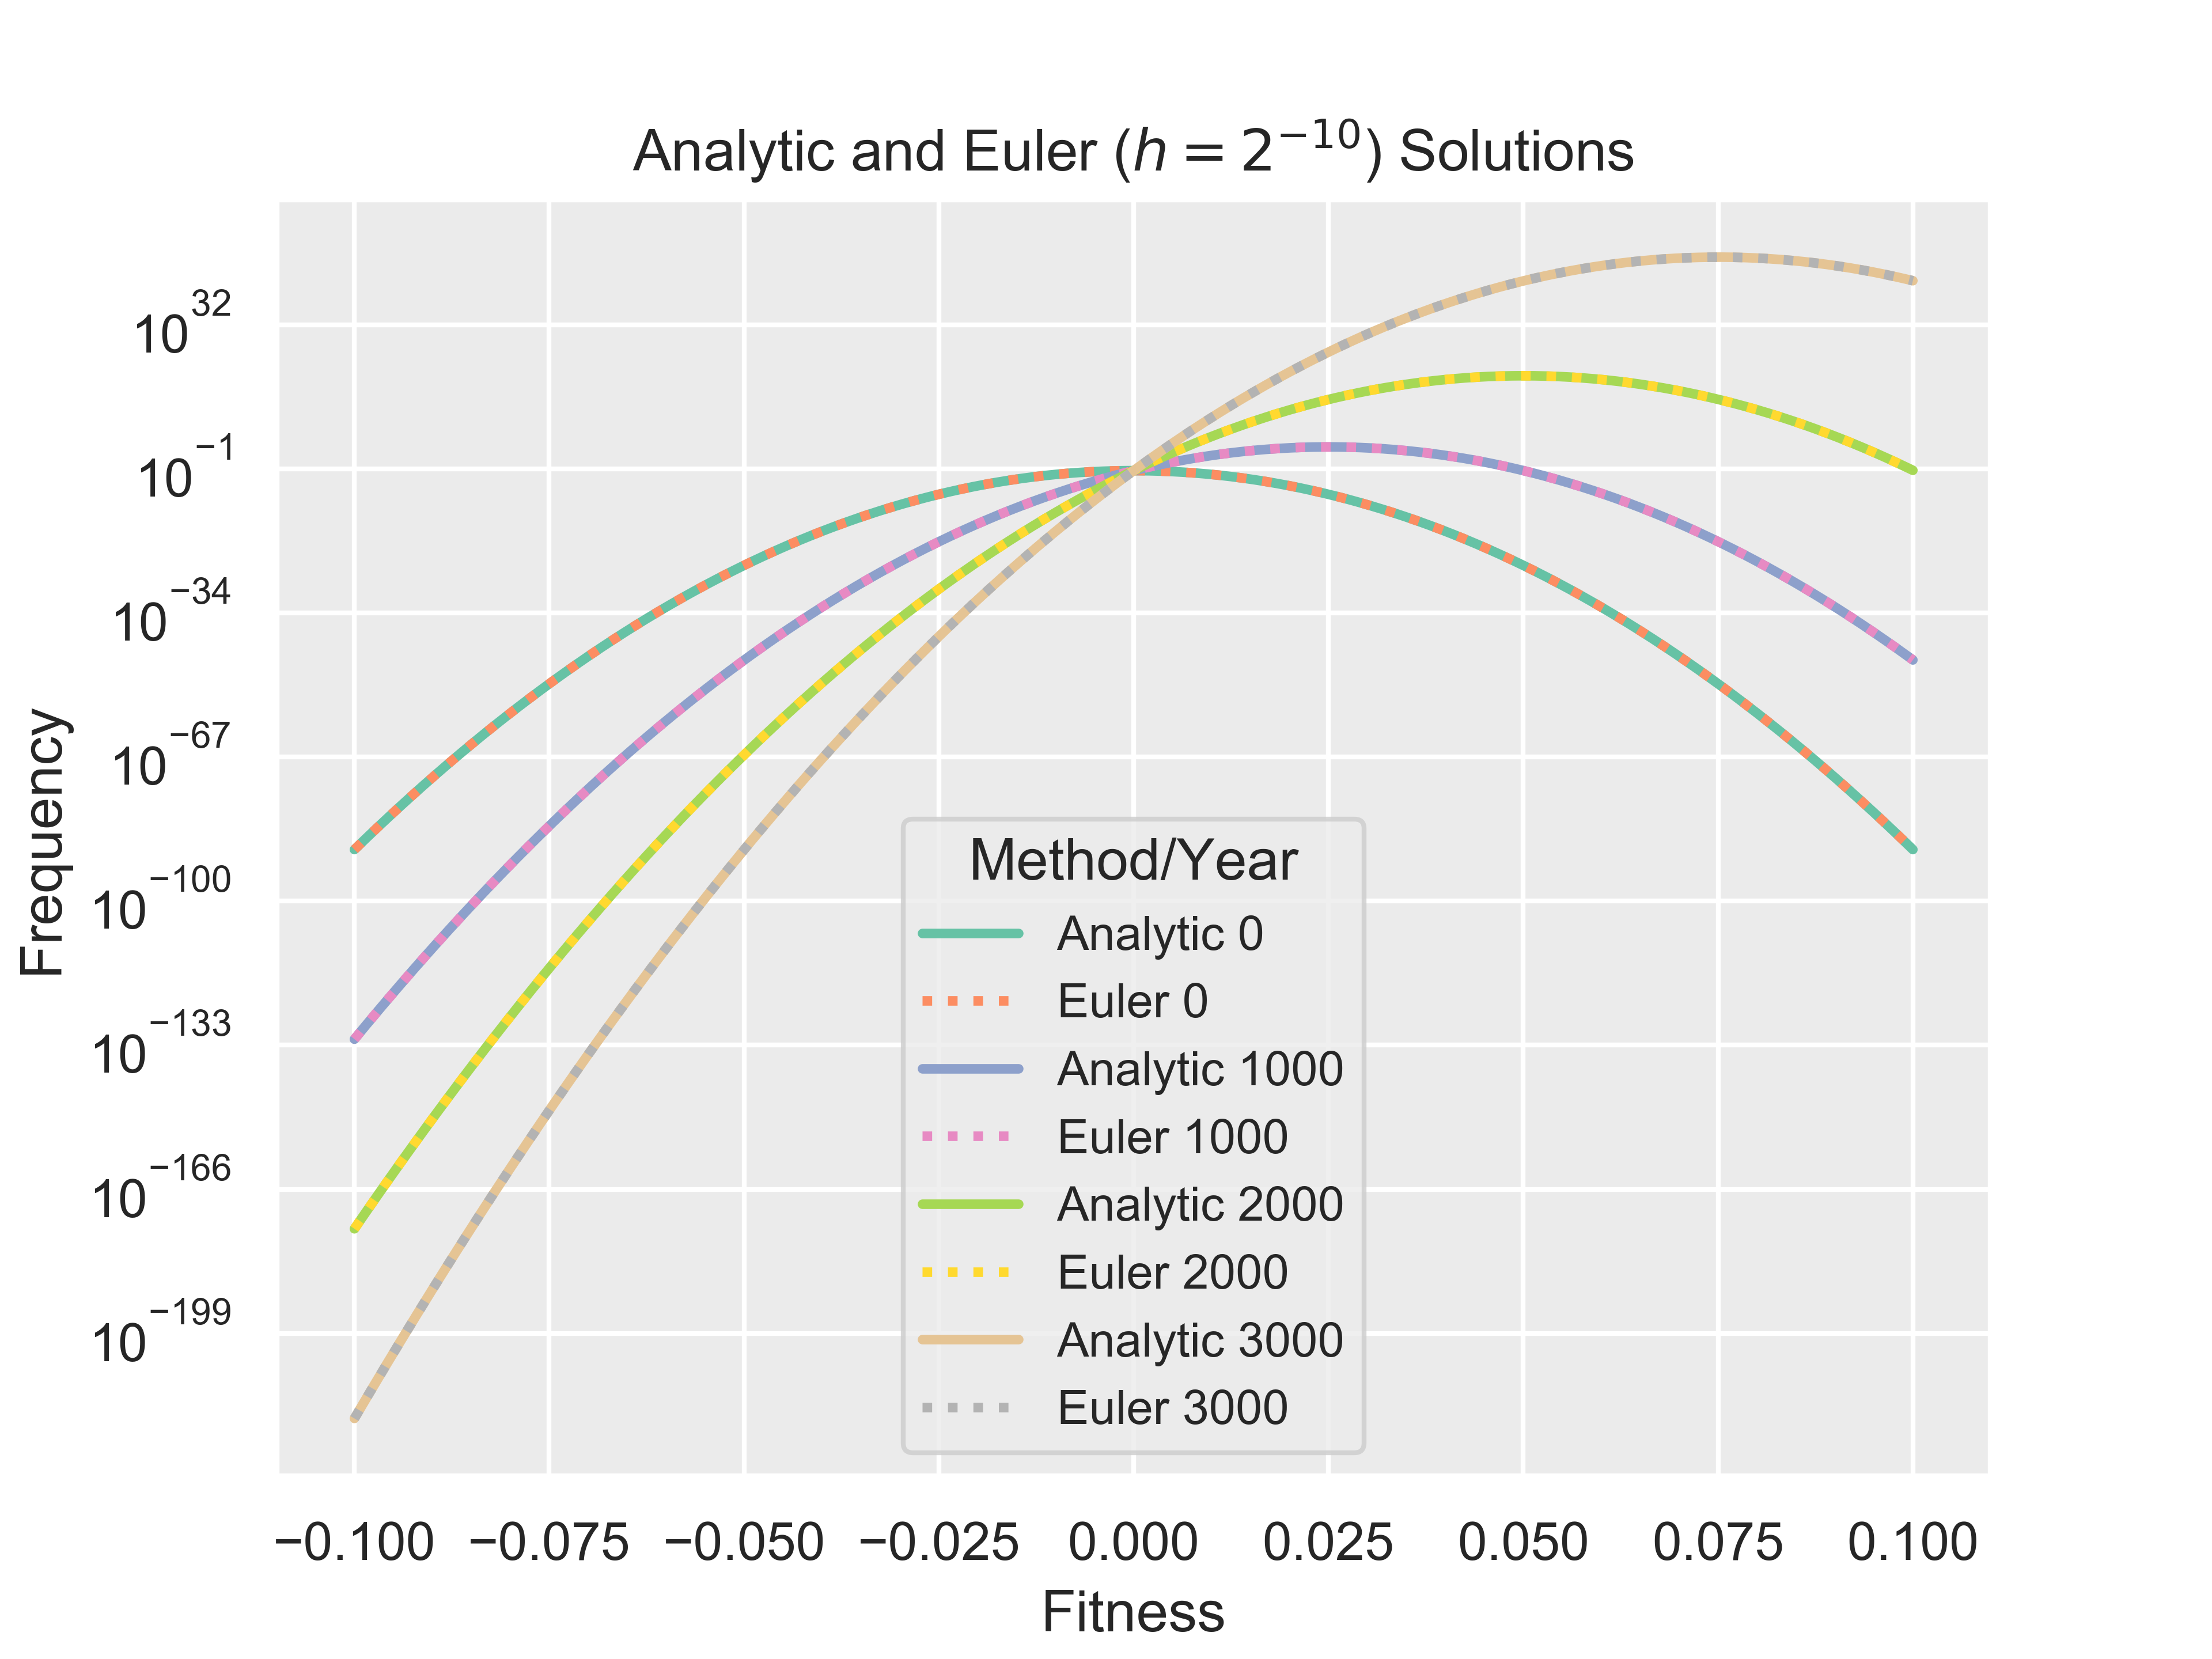

In [54]:
check.plot_solutions()

In the following plot, the solutions are normalized. The variance in fitness, initially about $0.005^2 = 2.5 \times 10^{-5}\!,$ changes very little over 3000 years. For each interval of $1000 = 10^3$ years, the increase in mean fitness is about 

\begin{equation*}
   10^3 \times 2.5 \times 10^{-5} = 2.5 \times 10^{-2} = 0.025,
\end{equation*}

in accordance with Fisher's Fundamental Theorem of Natural Selection.

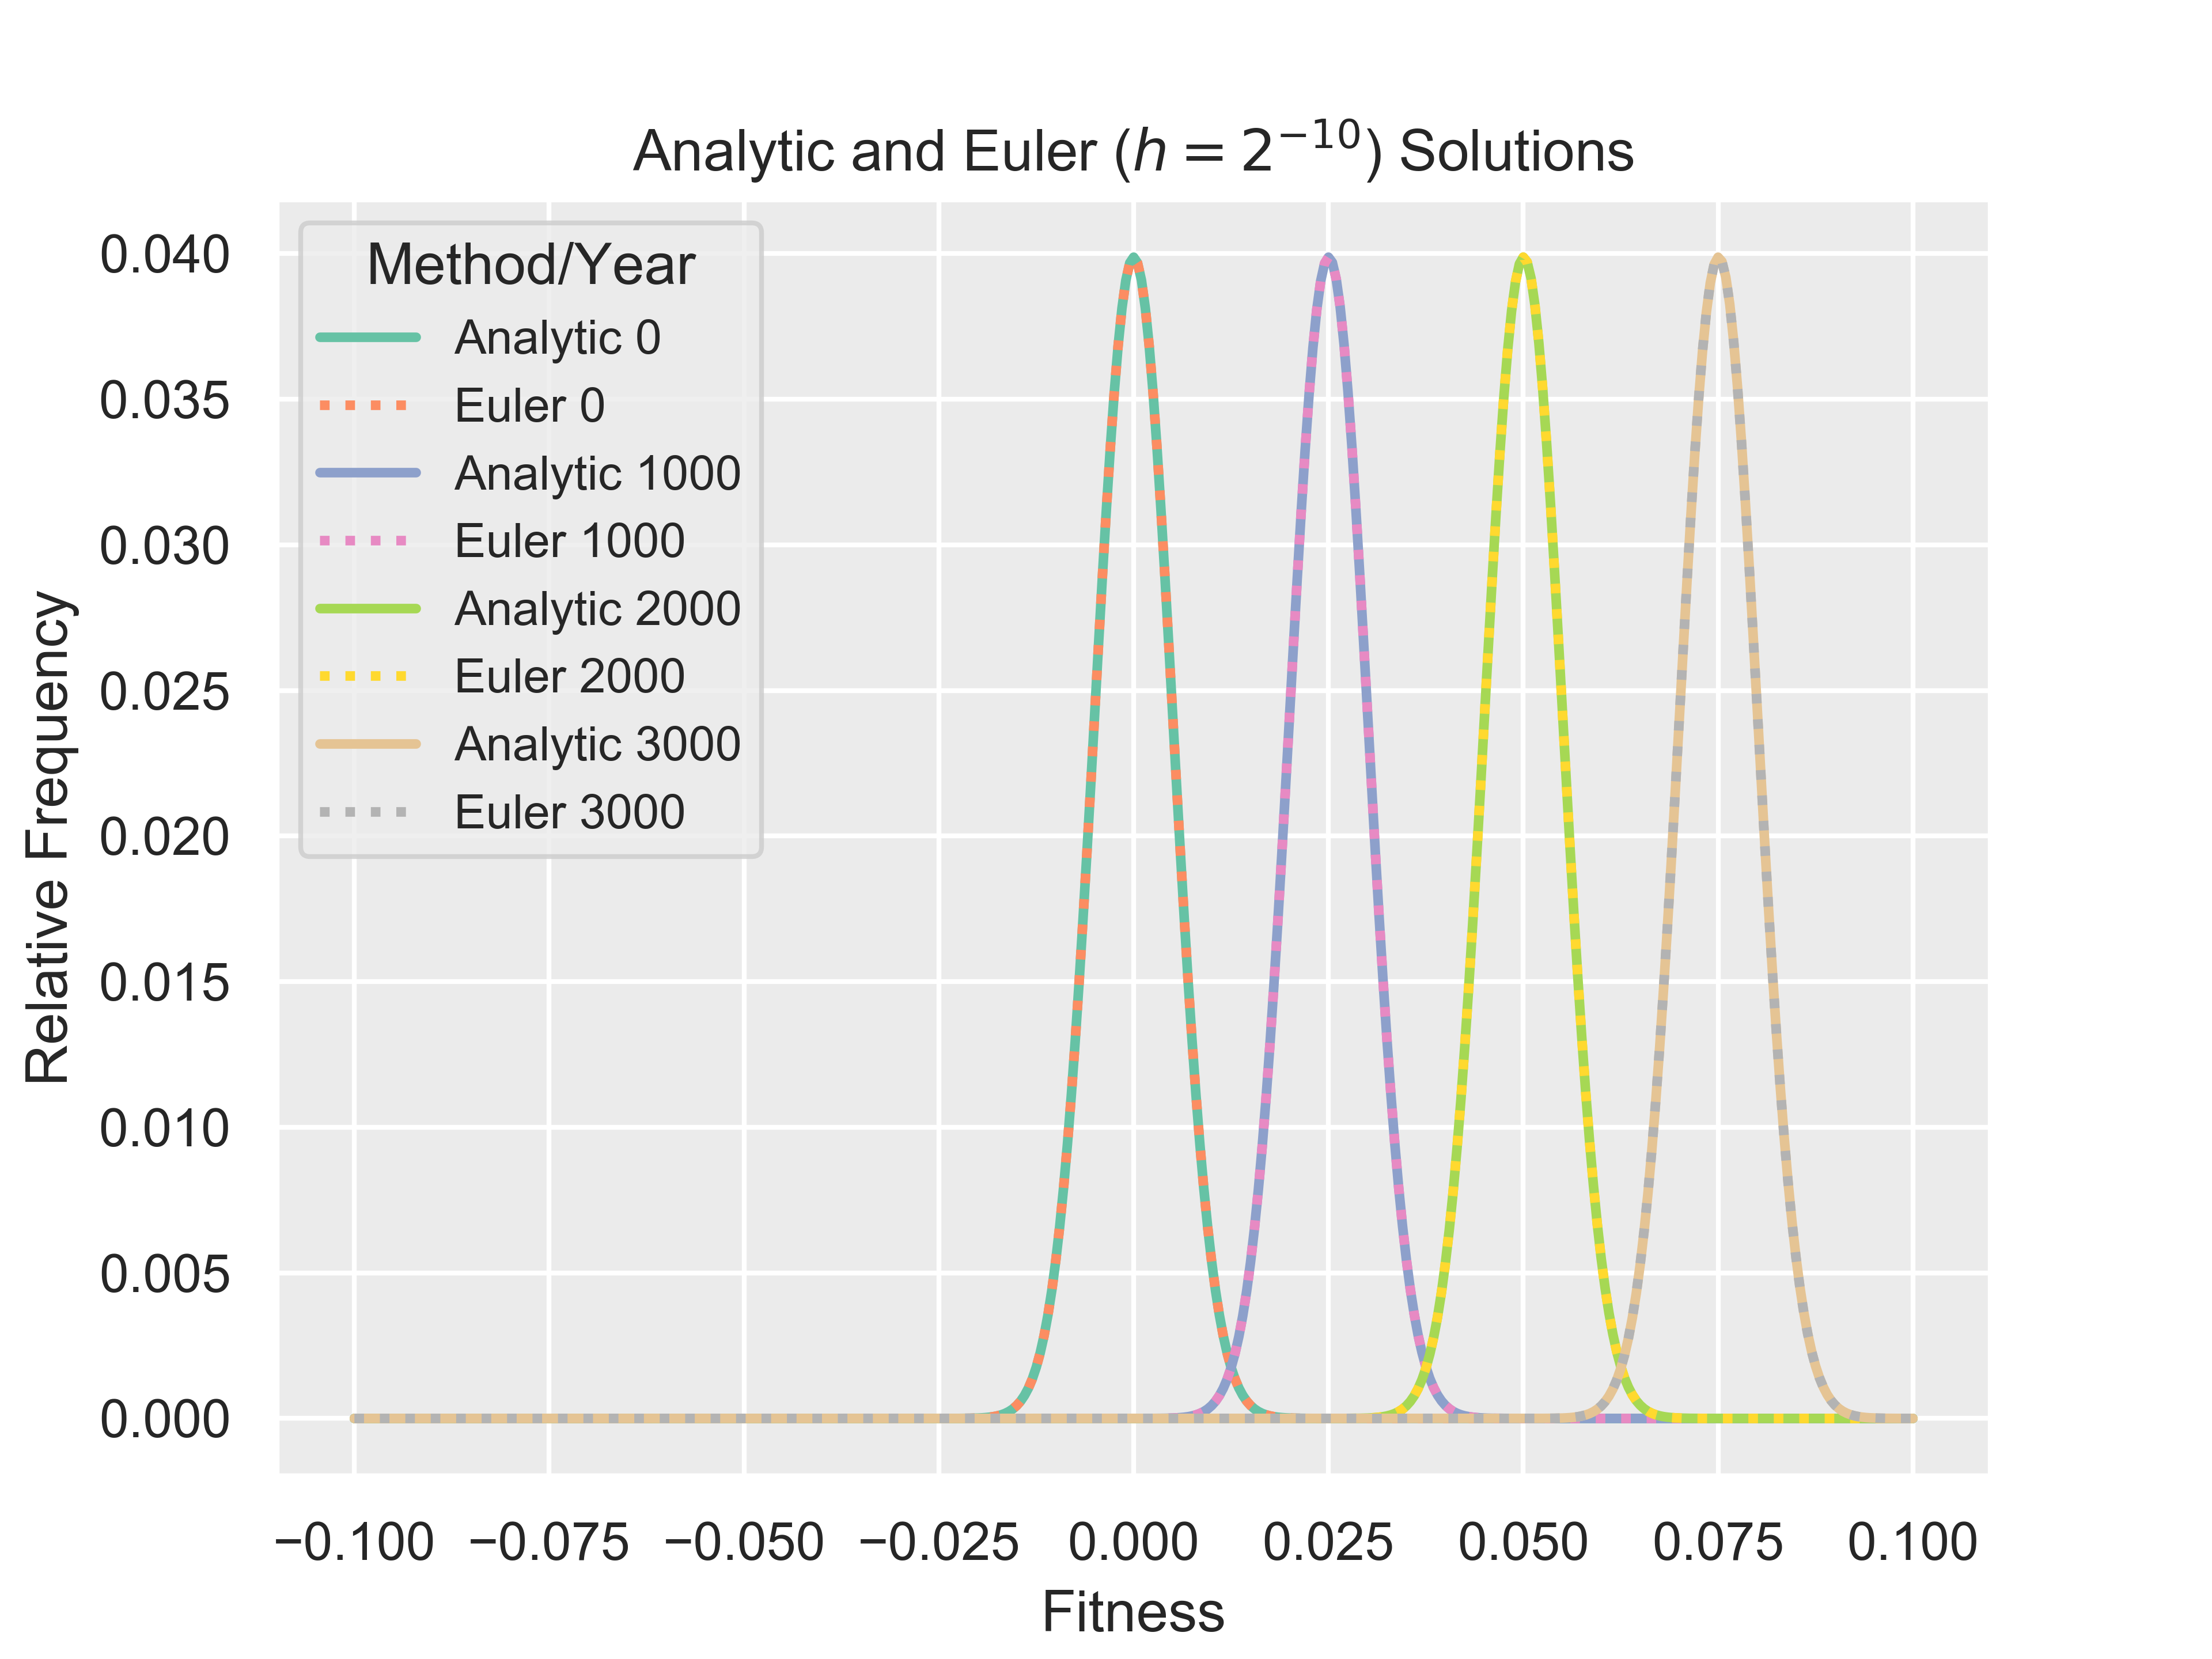

In [55]:
check.plot_solutions(normed=True)

Verify that the variance in fitness, calculated for the analytic solutions, changes little in the first 3000 years. Furthermore, in years 1000, 2000, and 3000, the increase in mean fitness over the preceding 1000 years is 1000 times the current variance in fitness.

In [56]:
for year, dist in zip(check.years, check.analytic):
    mean, var = mean_var(dist, check.m)
    mean = float(mean)
    var = float(var)
    print('Year {:4d} mean {:8.6f} var {:11.9f}'.format(year, mean, var))

Year    0 mean 0.000000 var 0.000025021
Year 1000 mean 0.025021 var 0.000025021
Year 2000 mean 0.050041 var 0.000025020
Year 3000 mean 0.075060 var 0.000025019


In the following plot, the "observed" ratio of solutions is calculated according to the formula

\begin{equation*}
   \frac{s_{k,i}}{P_i(k\:\!h)} = \frac{s_{k,i}}{P_i(0)e^{khm_i}}
\end{equation*}

for $i = 1, 2, \dotsc, n,$ with $\mathbf{s}_k$ obtained by the forward Euler method (implemented by an instance of `Solver` with threshold relative frequency of zero). The numerator is calculated with 64-bit floating-point numbers, while the denominator is calculated with multiprecision floating-point numbers. The "predicted" ratio is calculated with multiprecision floating-point numbers, according to the formula


\begin{align*}
   \frac{s_{k,i}}{P_i(k \:\! h)} 
      &= \left[ \frac{1 + h m_i}{e^{h m_i}} \right]^k,
\end{align*}

$i = 1, 2, \dotsc, n.$

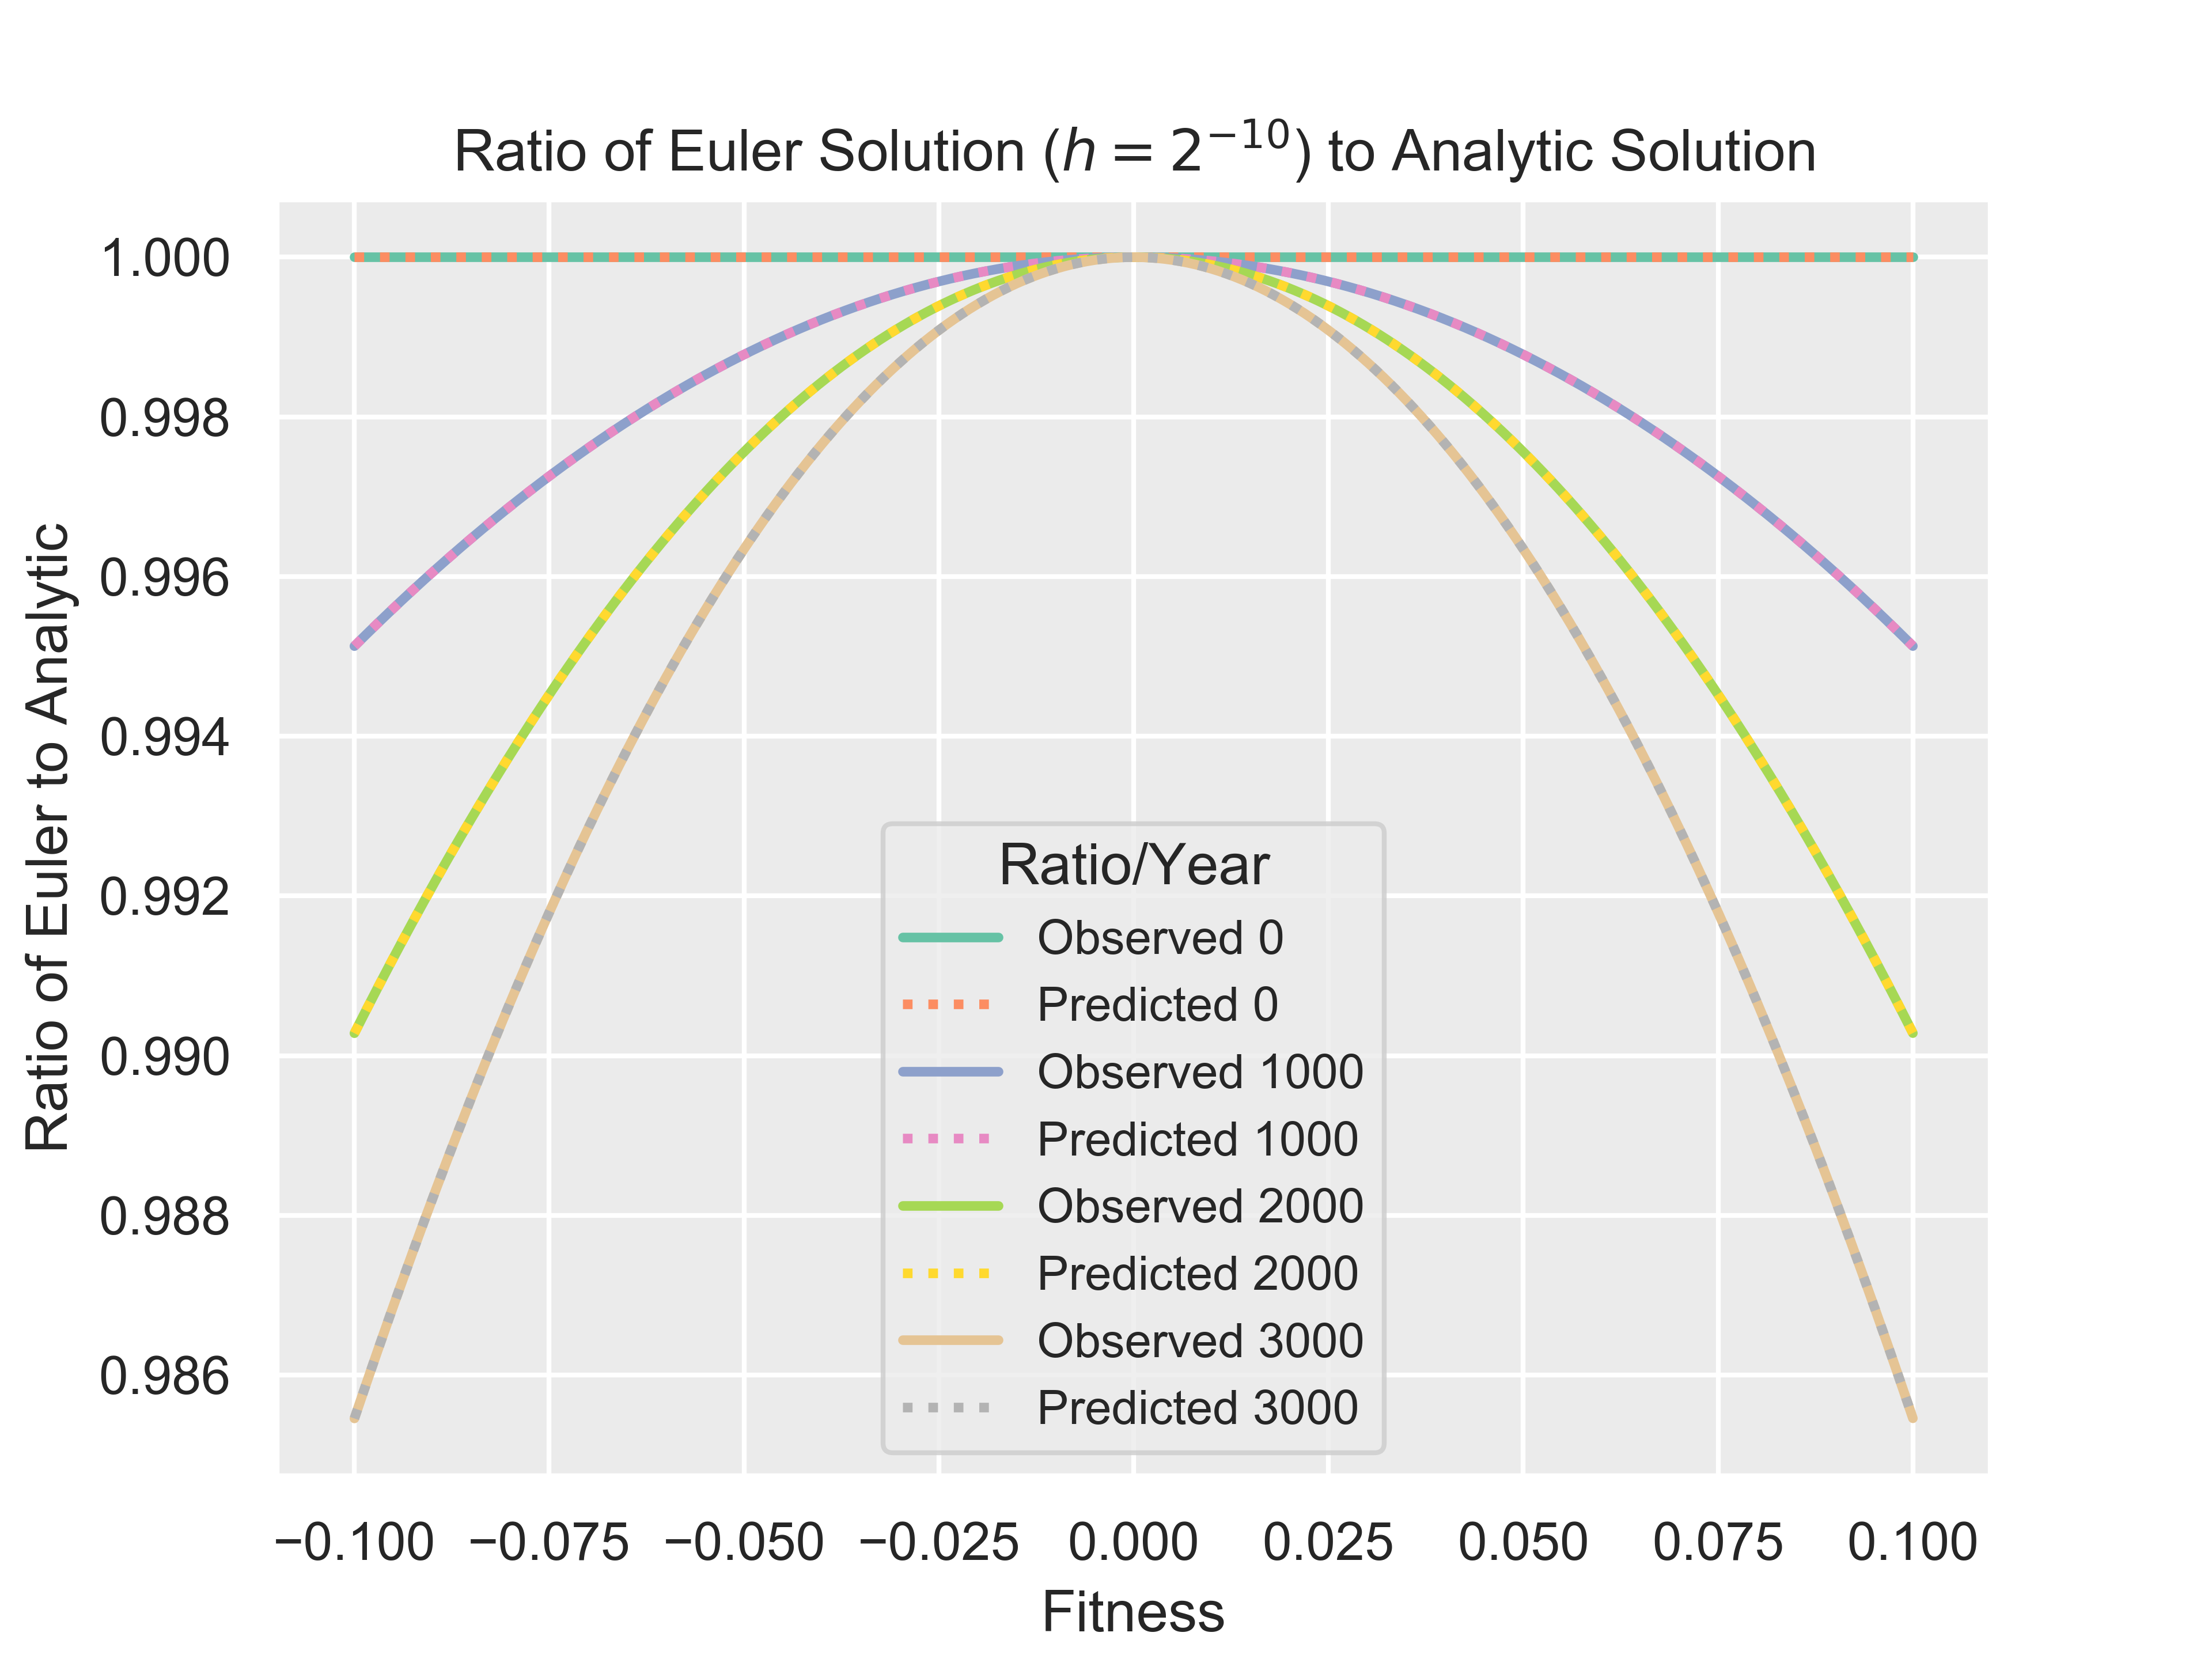

In [57]:
check.plot_ratios()

Check the maximum absolute relative error for the final numerical solution, calculated with 64-bit floats by an instance of `Solver` (implementing the forward Euler method), and the alternative calculation of

$$s_{k,i} = P_i(0) (1 + h m_i)^k$$

with multiprecision floats.

In [58]:
check.report_mare()

Year    0 MARE: 0.0
Year 1000 MARE: 2.0422858969437203e-13
Year 2000 MARE: 2.47242367286368e-13
Year 3000 MARE: 2.085492042958641e-13


#### Check Euler solutions with step size $h=1$

We determine the impact of setting $h=1$ in the Euler method, as Basener's code does.

In [59]:
%%time 

check = CheckNoMutation([0, 1000, 2000, 3000], log_steps_per_year=0)

CPU times: user 8.55 s, sys: 374 ms, total: 8.92 s
Wall time: 3.87 s


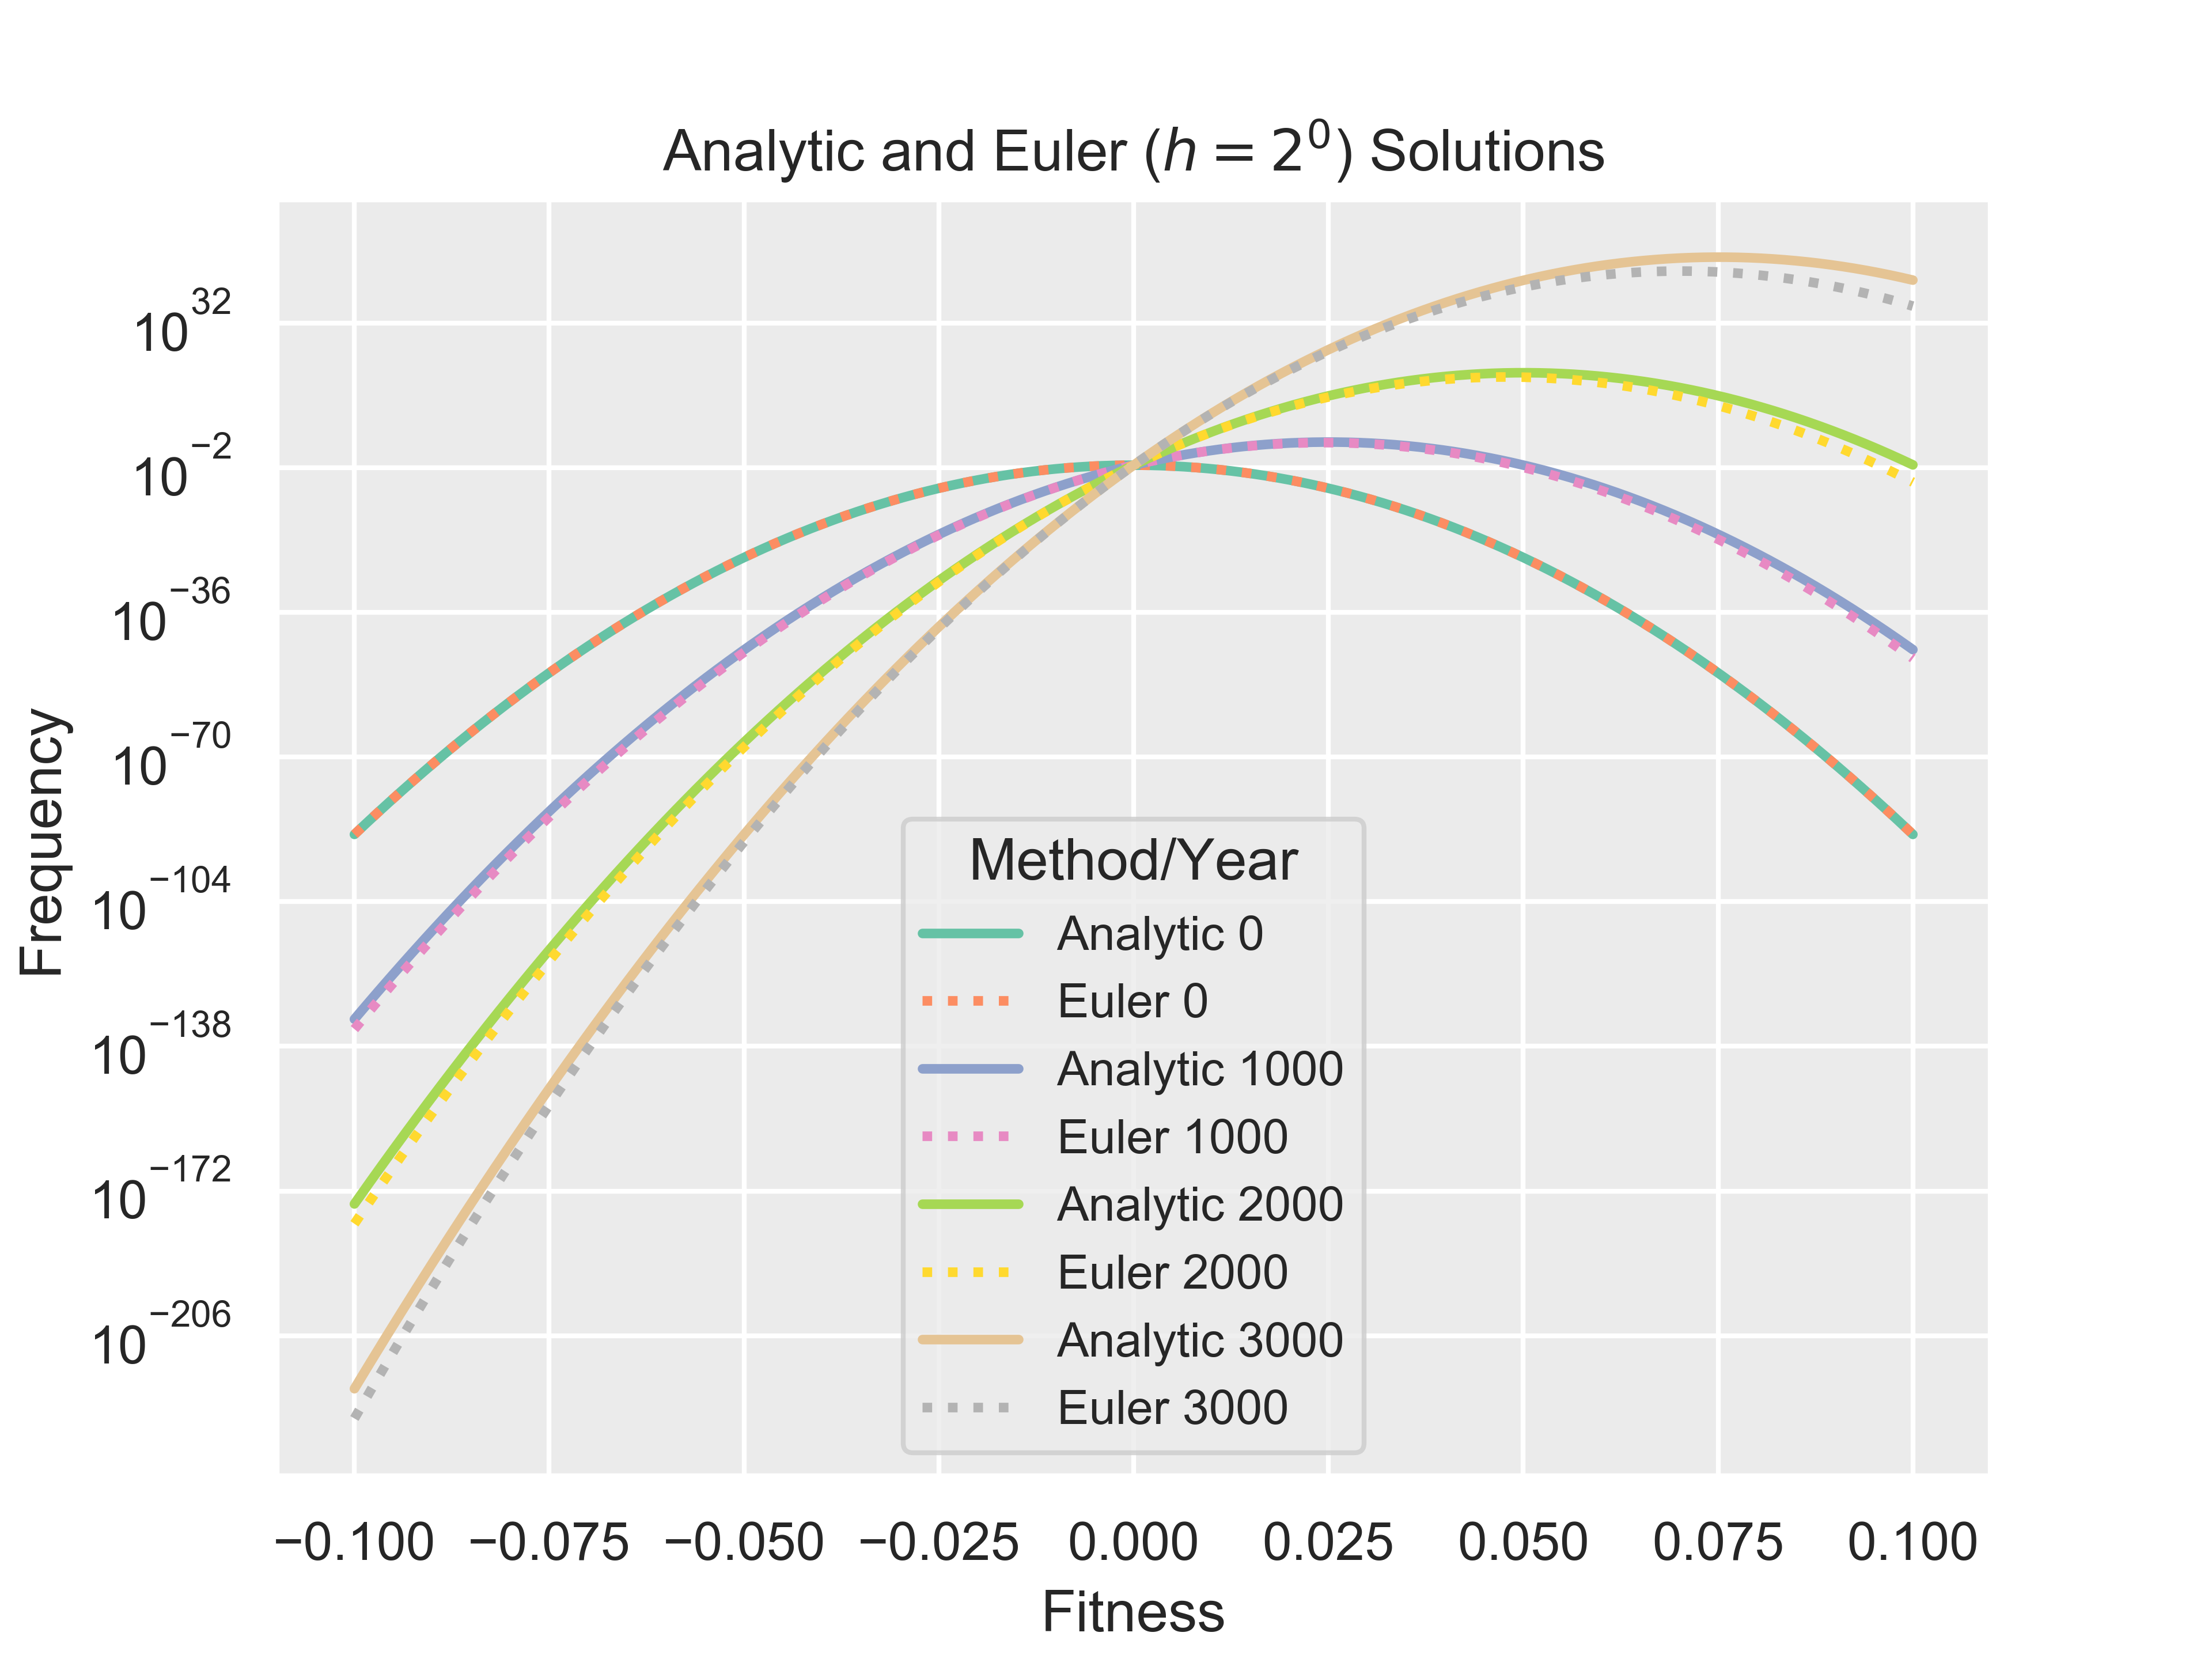

In [60]:
check.plot_solutions()

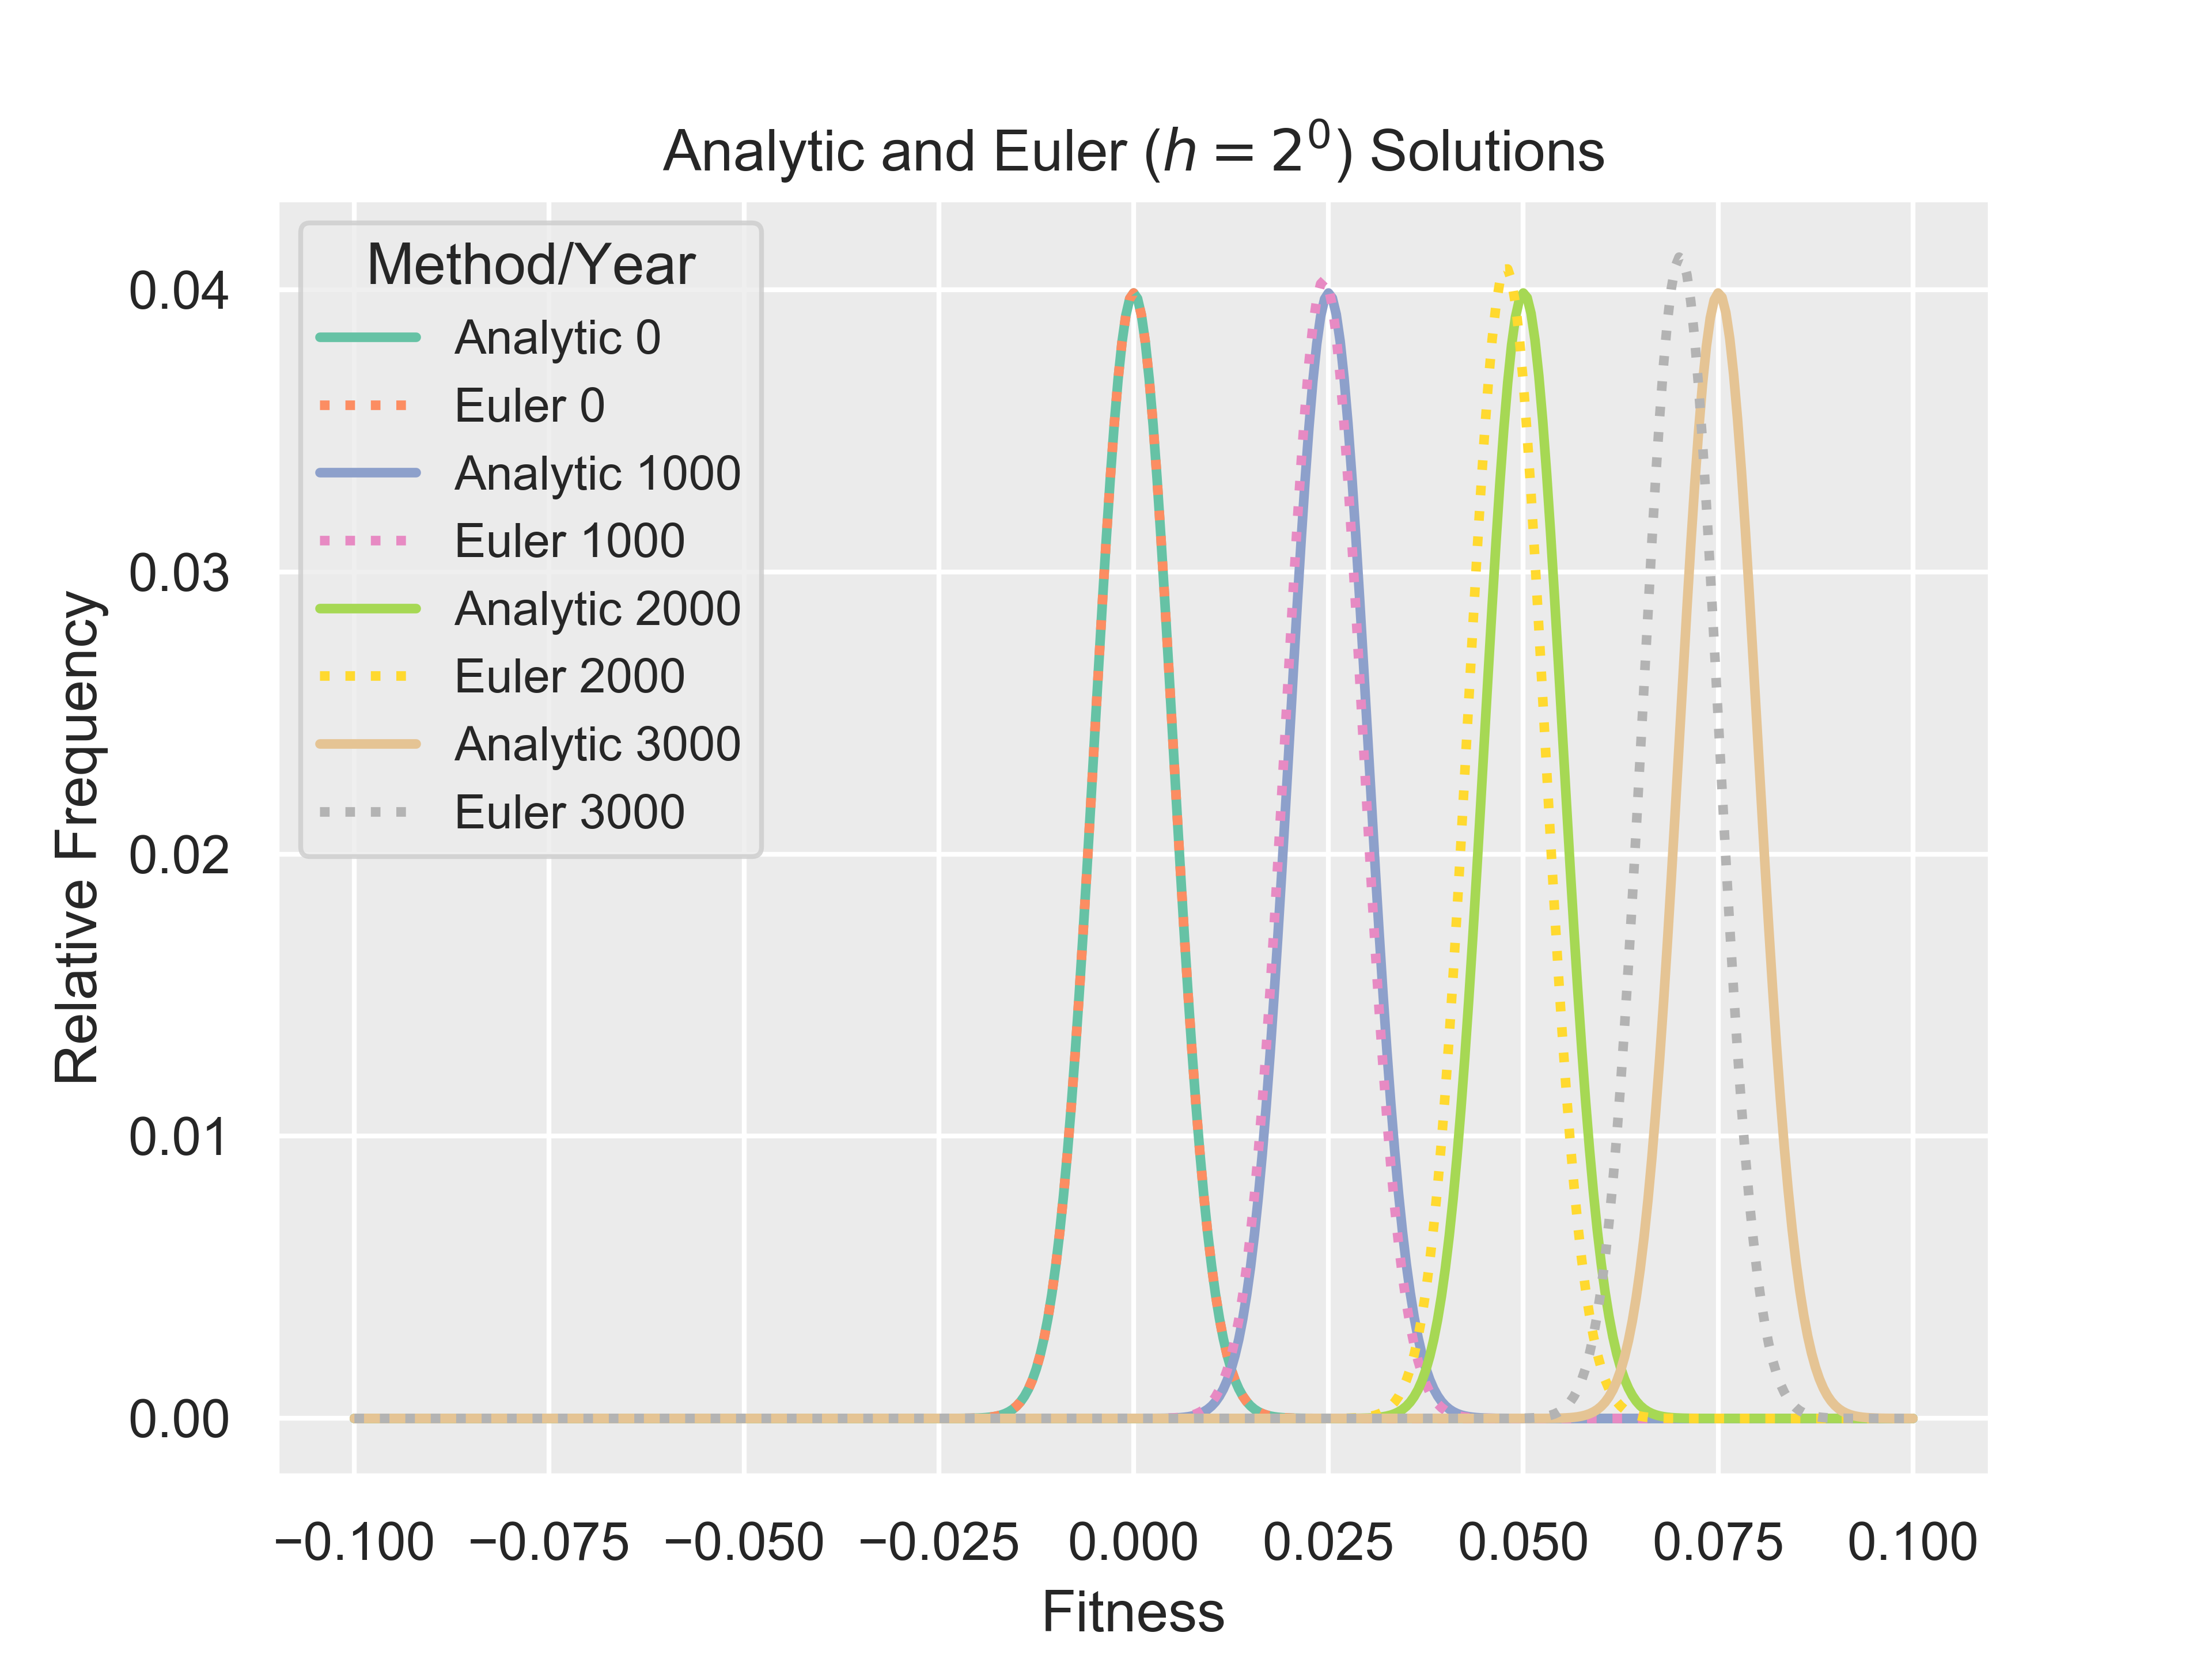

In [61]:
check.plot_solutions(normed=True)

The discrepancies of unnormalized Euler solutions and unnormalized analytic solutions are much greater than the preceding plot of normalized solutions would suggest. The following plot makes it clear that most of the components of the Euler solutions are much smaller than the corresponding components of the analytic solutions.

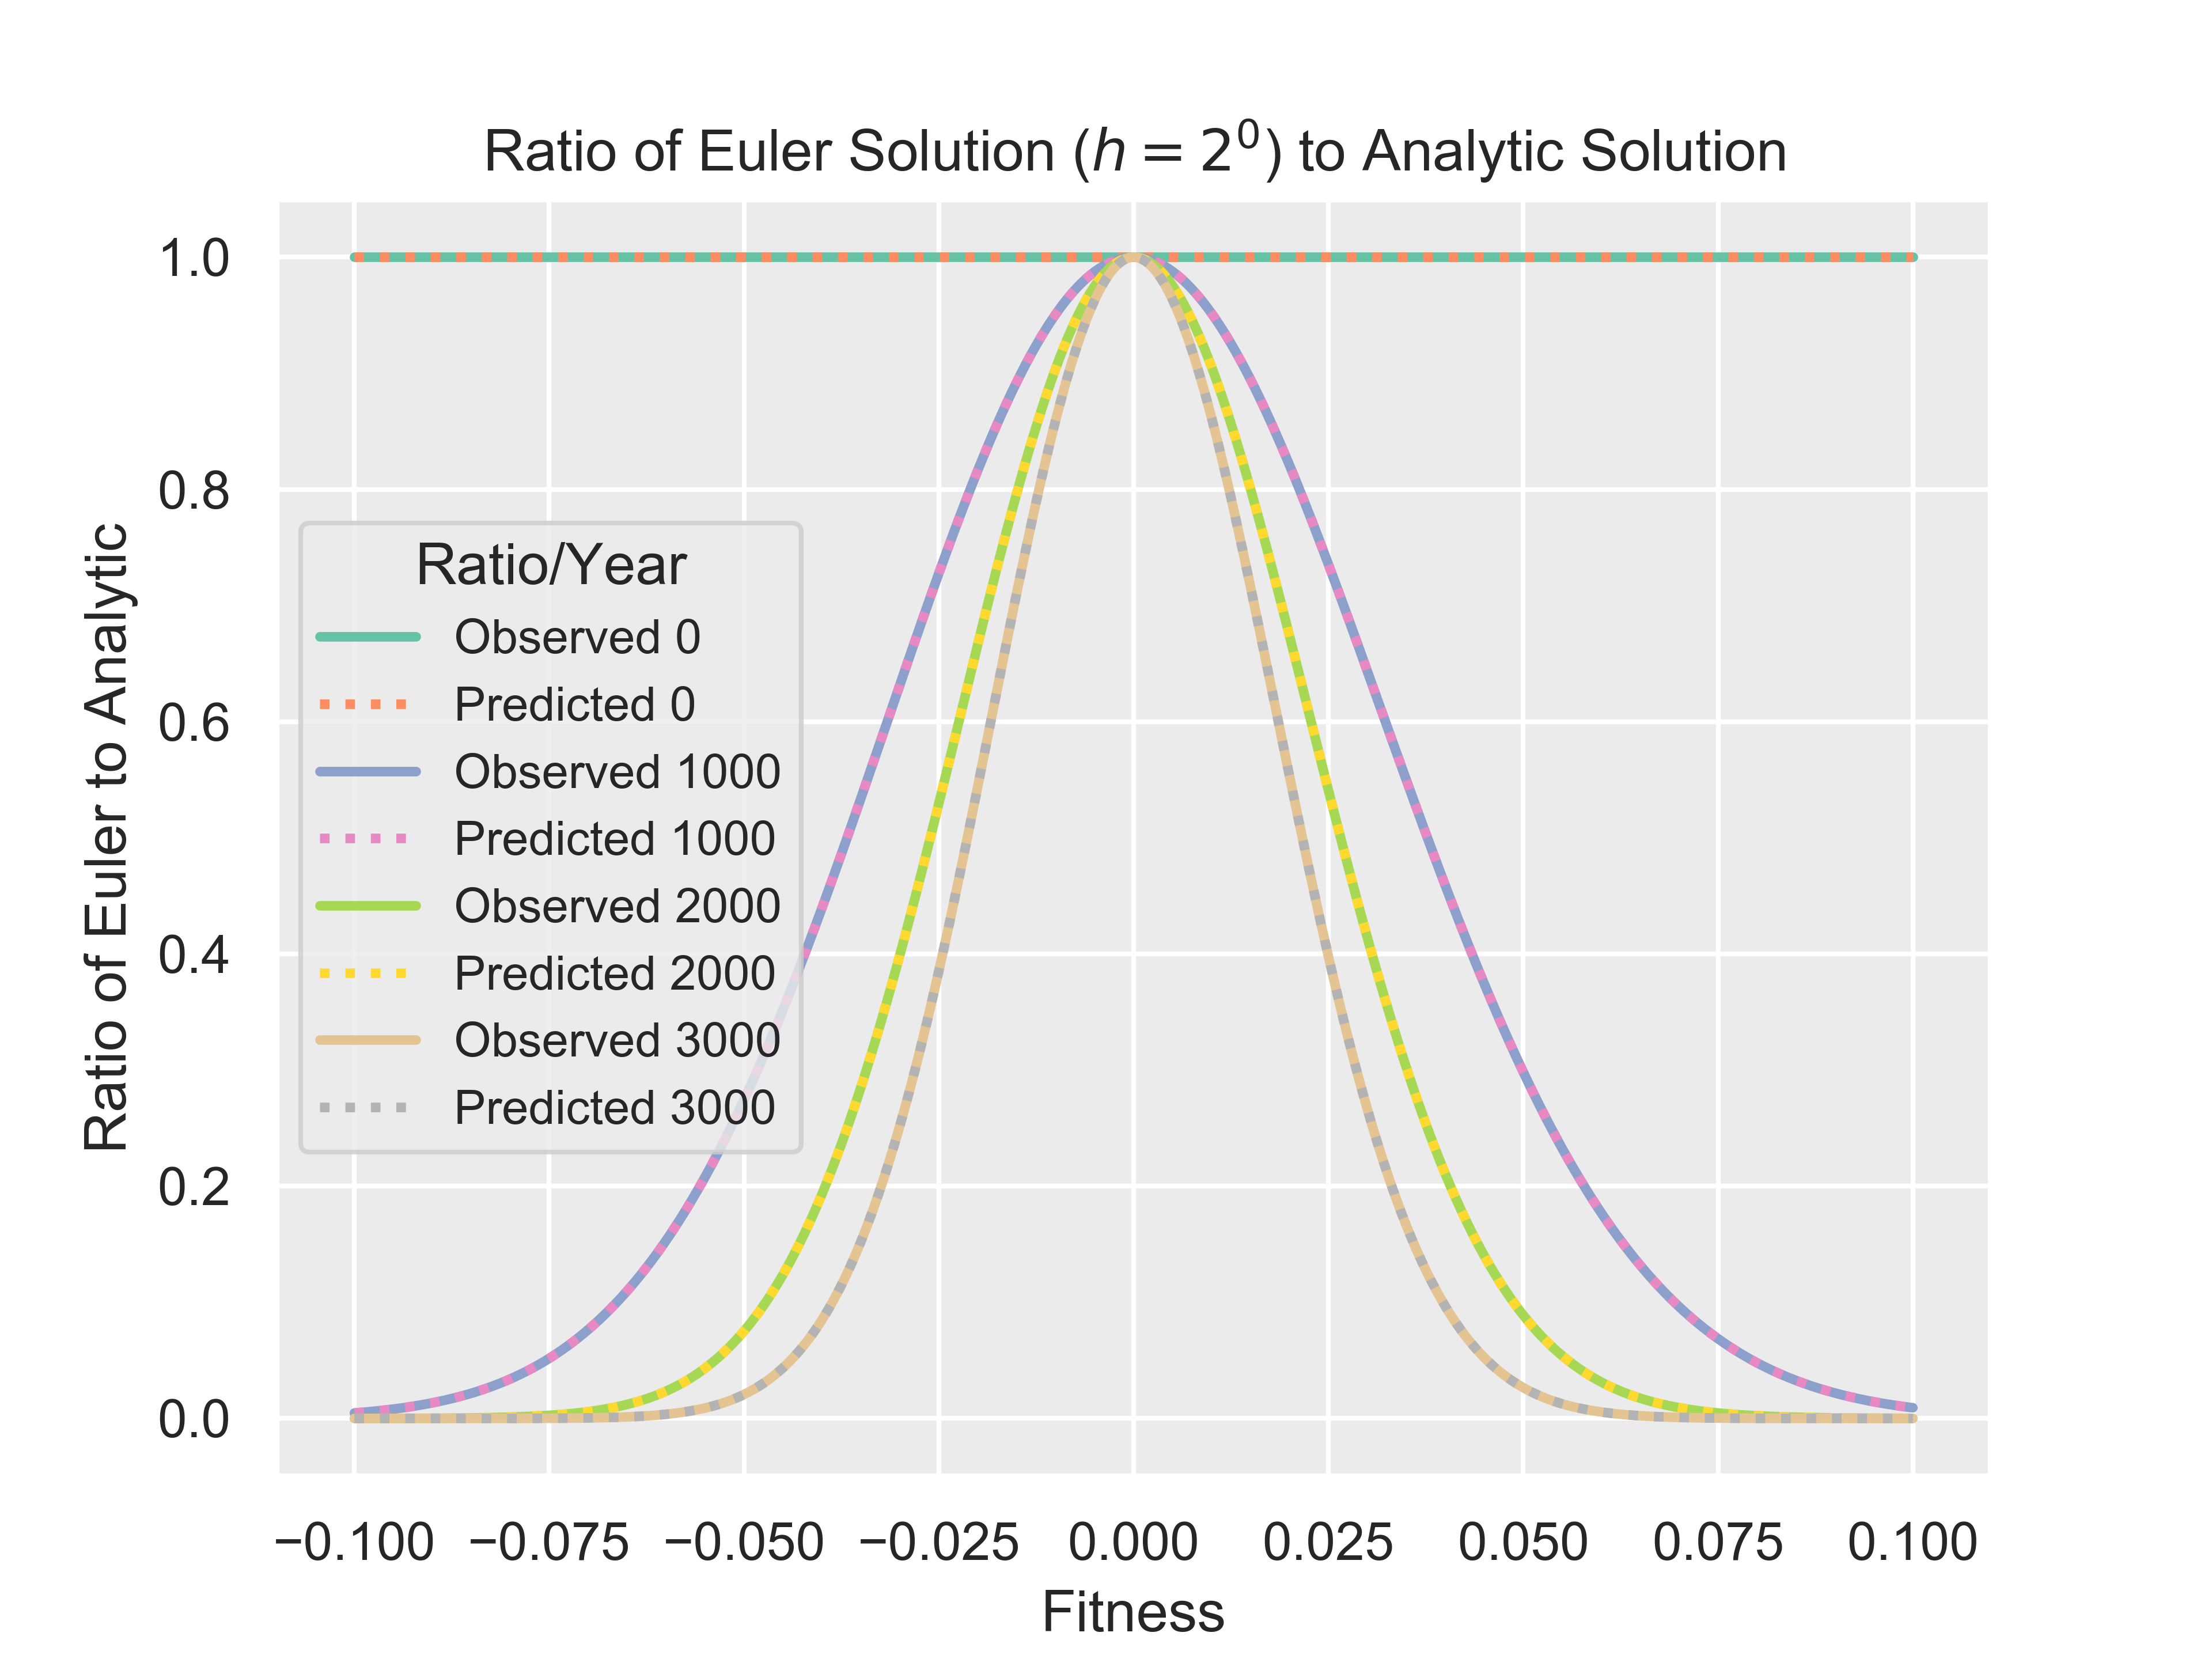

In [62]:
check.plot_ratios()

### Compare Euler solutions to Runge-Kutta 4(5) solutions

With the threshold relative frequency of zero, an instance of class `Solver` implements the Euler method, and solves for unnormalized frequencies $\mathbf{P}(k\:\!h)$ in the infinite-population model. As in Supporting Materials 1, we set the step size $h=2^{-10}\!.$ For the Euler method, also known as the Runge-Kutta 2(1) method, the error in each individual step is $O(h^2),$ and accumulated error is $O(h)$ at all times. For the Runge-Kutta 4(5) method, the error in each individual step is $O(h^5),$ and the accumulated error is $O(h^4)$ at all times. However, we are interested primarily in relative (normalized) frequencies. Irrespective of which solution method is applied, the calculated relative frequencies approach an equilibrium, and the accumulated error eventually becomes very small. The main question addressed here is whether the Euler solutions (for *relative* frequencies) are reasonably close to the Runge-Kutta 4(5) solutions *prior to convergence to the equilibrium distribution.*

**Solution by Euler and Runge-Kutta 4(5) methods**

Solution by the Runge-Kutta 4(5) method is an option provided by the `solve_ivp` function of Scientific Python (SciPy).

In [63]:
%%time
"""
We use a library routine for solving the initial value problem.
"""
from scipy.integrate import solve_ivp

def euler_solutions(params, n_years, log_steps_per_year=10, threshold=0):
    """
    Returns `Solver` instance run for `n_years` with threshold zero.
    """    
    W = params.W.astype(float)
    initial_freqs = params.initial_freqs().astype(float)
    solver = Solver(W, initial_freqs, log_steps_per_year, threshold)
    solver(n_years)
    return solver

def rk45_solutions(params, n_years, step_size):
    """
    Calculates solutions using the Runge-Kutta 4(5) method.

    Returns
    * normalized solutions at times 0, 1, ..., `max_year`, with the
      solution for year 0 equal to `params.initial_freqs()`
    * unnormalized solution at time `max_year`.
    
    The derivative operator is `params.W`. The solver takes time steps
    of size `step_size`.
    """
    # Define a function for calculation of the derivative. It will
    # be called with the time as the first parameter, even though the
    # derivative does not depend on the time.
    W = params.W.astype(float)
    derivative = lambda t, s: W @ s
    #
    # Scale the initial frequencies to avoid over(under)flow in
    # derivative calculations.
    init = 2**512 * params.initial_freqs().astype(float)
    #
    # The initial-value-problem solver must be given the times at
    # which to produce solutions.
    times = np.linspace(0.0, n_years, n_years + 1)
    interval = (times[0], times[-1] + step_size)
    result = solve_ivp(derivative, interval, init, method='RK45',
                       t_eval=times, max_step=step_size, rtol=1e-13,
                       atol=1e-11)
    print(result.message)
    #
    # Transpose the array of solutions to make rows correspond to
    # times. Then normalize the solutions at each time, using `fsum()`
    # to calculate sums accurately.
    solutions = result.y.T
    unnormalized_last_solution = 2**-512 * solutions[-1]
    for i in range(len(solutions)):
        solutions[i] /= fsum(solutions[i])
    return solutions, unnormalized_last_solution

params = Parameters(b_max=0.25, gamma='1e-3')
euler = euler_solutions(params, 1600, log_steps_per_year=10)
rk45, last_rk45 = rk45_solutions(params, len(euler)-1, euler.step_size)

The solver successfully reached the end of the integration interval.
CPU times: user 1h 1min 30s, sys: 1min 53s, total: 1h 3min 24s
Wall time: 16min 48s


Check the maximum absolute difference of final (unnormalized) frequencies calculated by the two methods.

In [64]:
mad(euler.get_last_solution(), last_rk45)

7.121343425656608e+26

Although the maximum absolute difference in unnormalized solutions is huge, the maximum absolute relative error is fairly small.

In [65]:
mare(euler.get_last_solution(), last_rk45)

0.002933095004234469

Compare the sums of final (unnormalized) frequencies calculated by the two methods.

In [66]:
float(fsum(euler.get_last_solution())), fsum(last_rk45)

(1.5267227686899486e+31, 1.5312042314837914e+31)

**Numerical comparison of Euler and Runge-Kutta 4(5) solutions**

Verify not only that the discrepancy of relative frequencies calculated by the Euler and Runge-Kutta 4(5) methods is small, but also that the discrepancy is reduced when the step size is reduced in the Euler method.

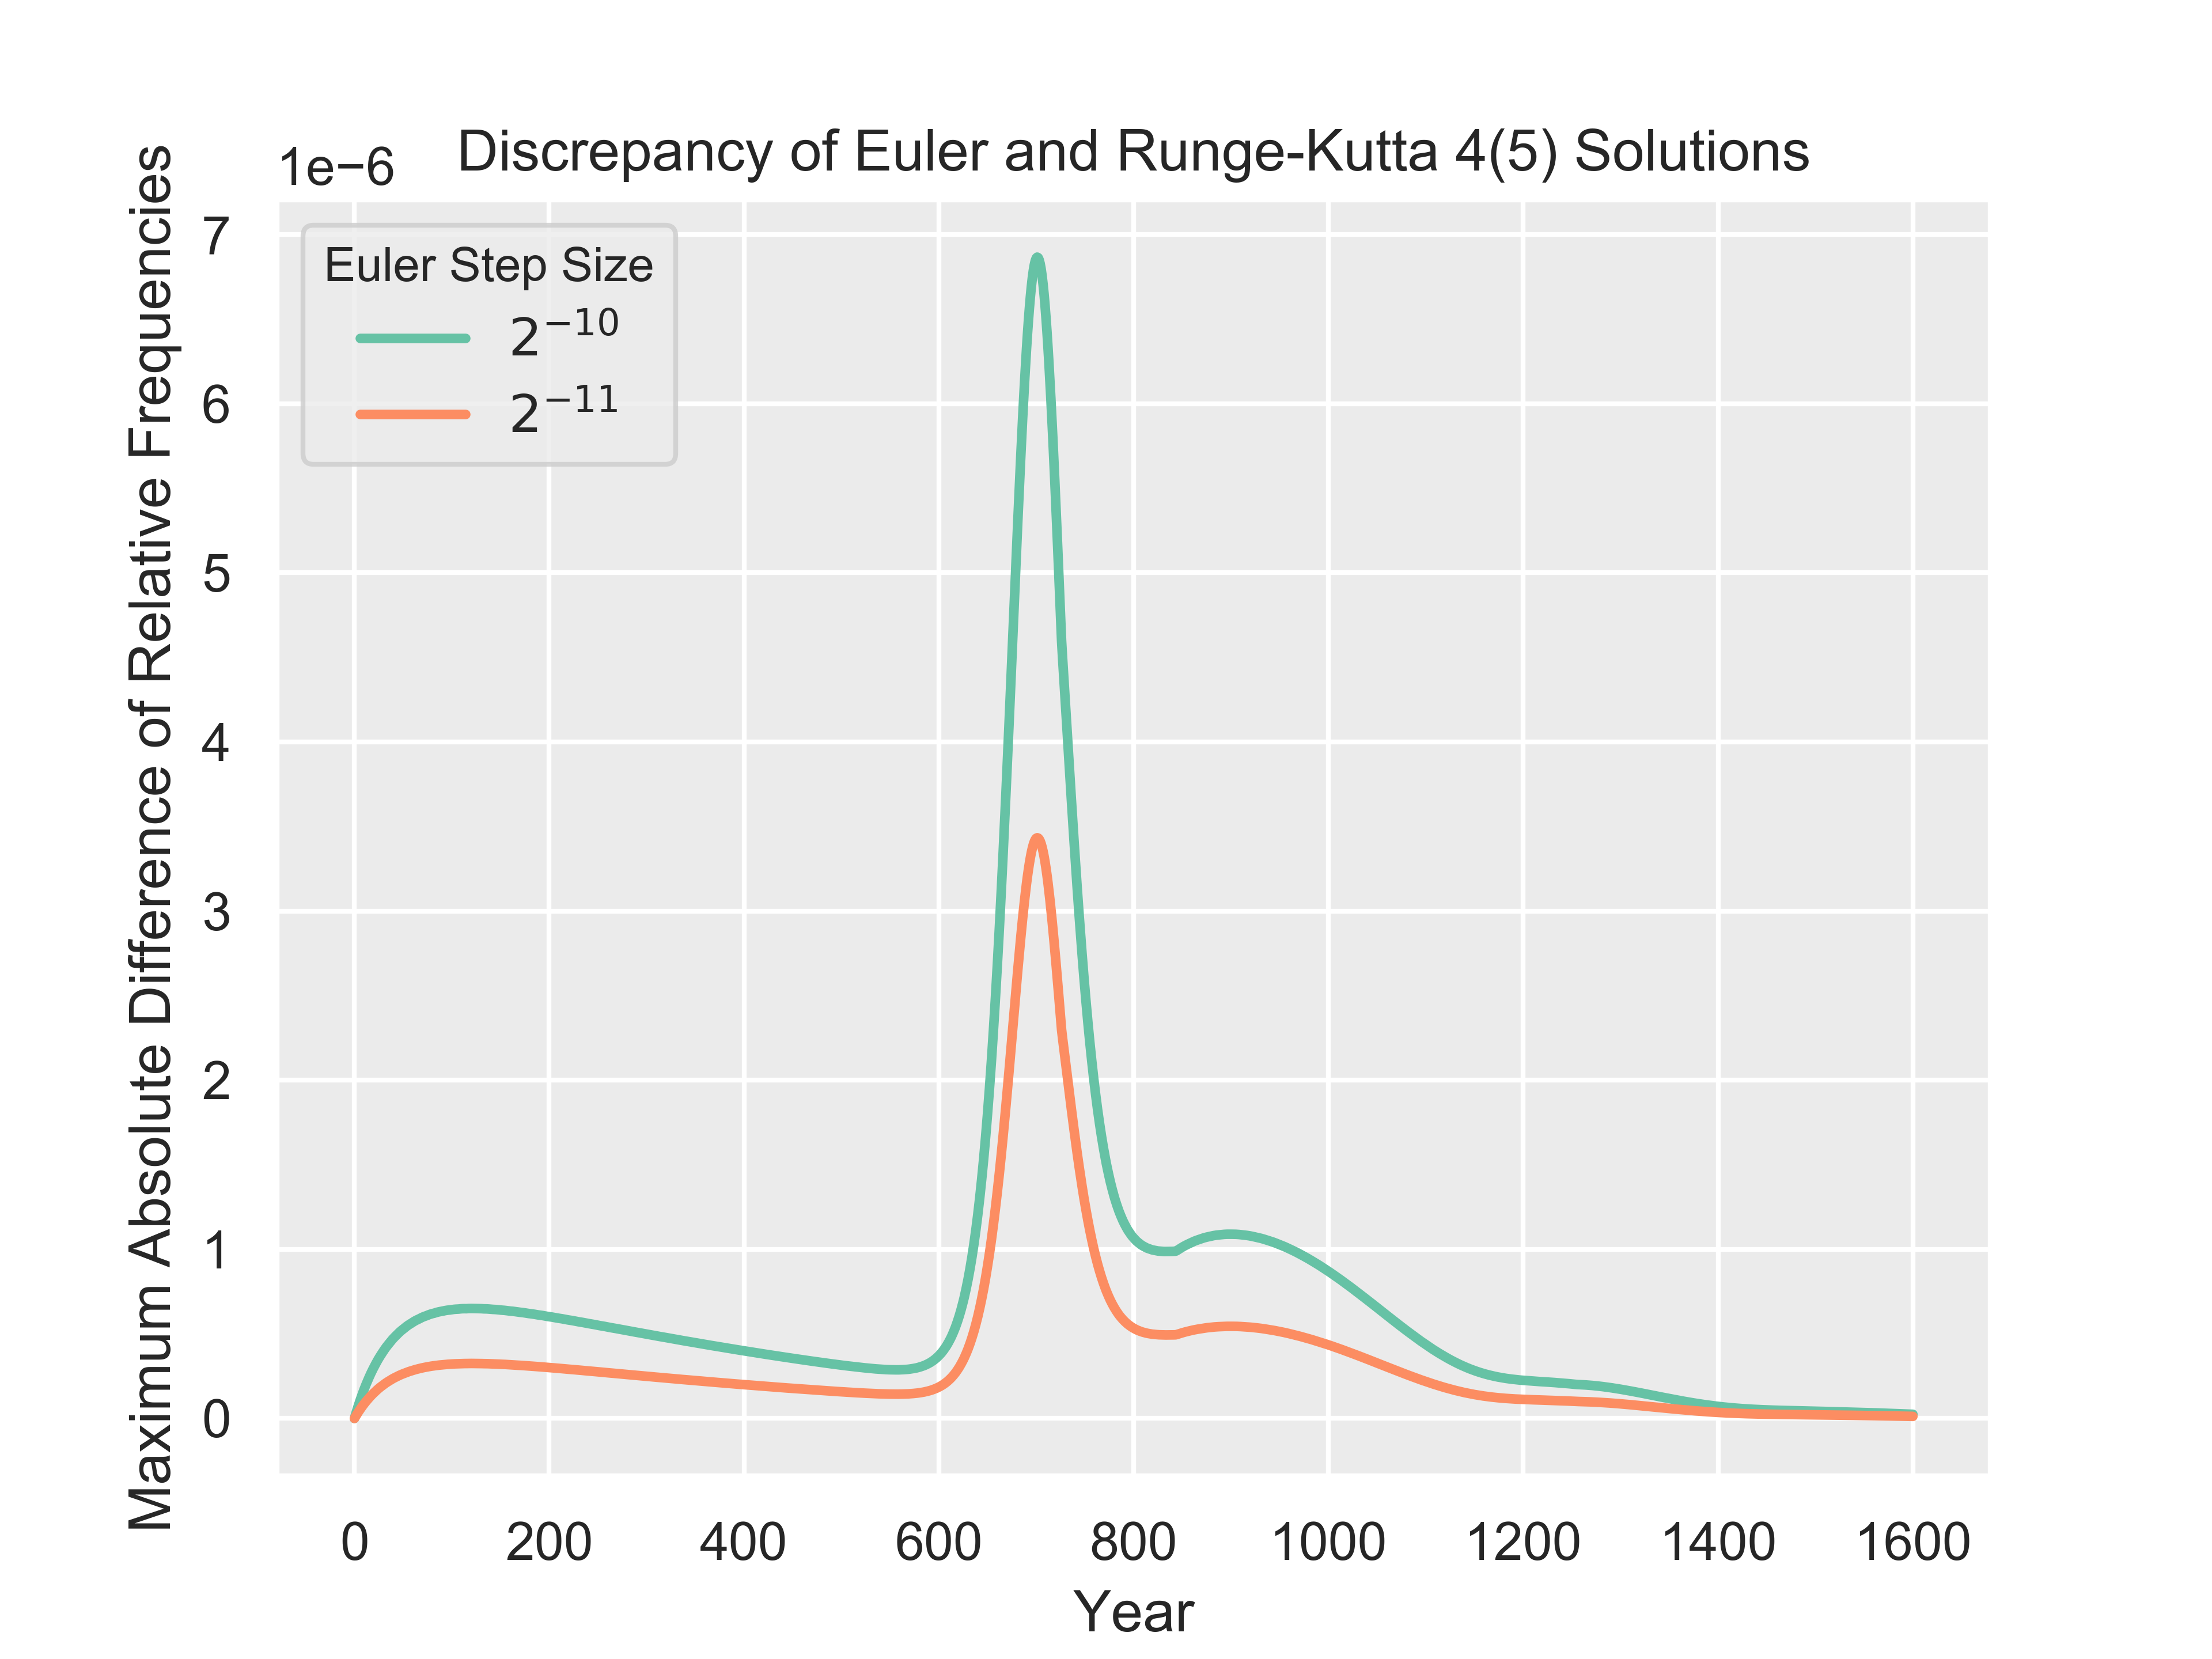

CPU times: user 10min 58s, sys: 18.7 s, total: 11min 17s
Wall time: 3min 5s


In [67]:
%%time

def plot_mad(eulers, rk45s):
    fig, ax = plt.subplots()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xlabel('Year')
    ax.set_ylabel('Maximum Absolute Difference of Relative Frequencies')
    t = 'Discrepancy of Euler and Runge-Kutta 4(5) Solutions'
    ax.set_title(t)
    for euler, rk45 in zip(eulers, rk45s):
        errs = [mad(s, rk) for s, rk in zip(euler, rk45)]
        ax.plot(errs, label=exp_latex(euler.step_size))
    ax.legend(title='Euler Step Size', loc='upper left', 
              title_fontsize='small')
    save_and_display(fig, DIR + 'tmp.png')

better_euler = euler_solutions(params, len(euler)-1, 11)
plot_mad([euler, better_euler], [rk45, rk45])

**Visual comparison of Euler and Runge-Kutta 4(5) solutions**

In the following plot of solutions in select years, we include years in which the discrepancy of Euler and Runge-Kutta 4(5) solutions peaks.

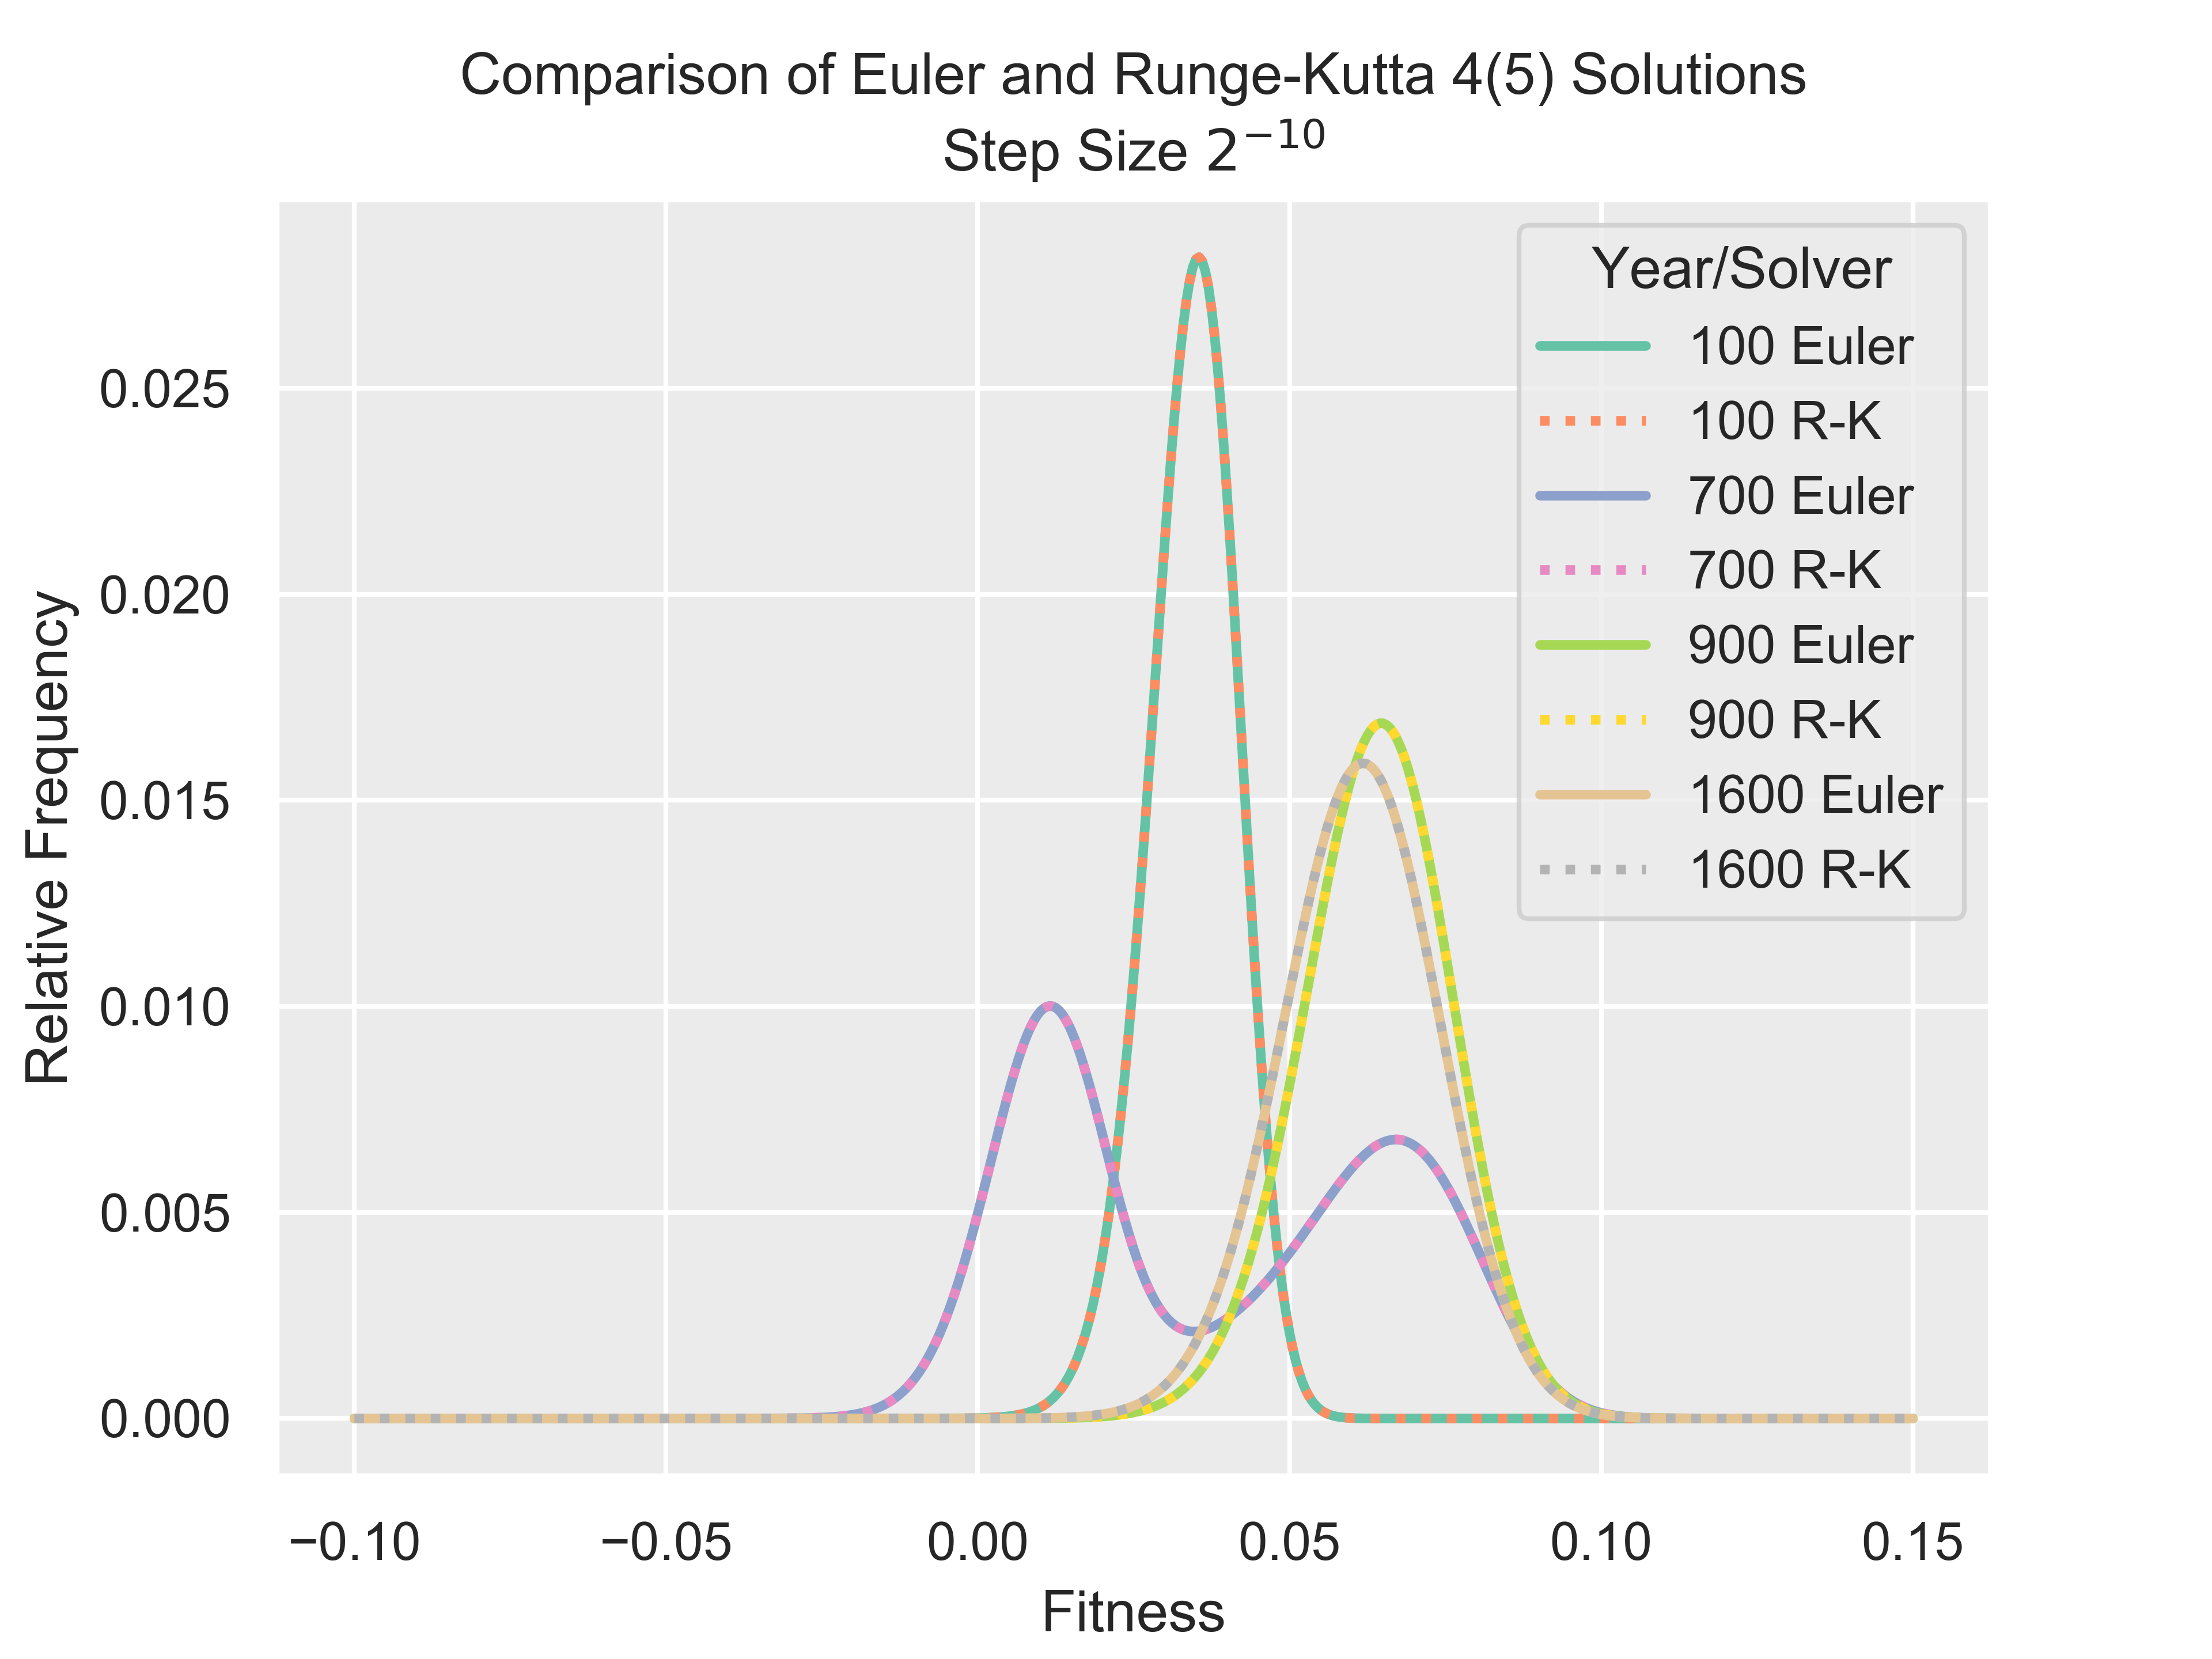

In [68]:
def plot_euler_rk(euler, rk, years):
    """
    Plot `euler` and `rk` solutions for given `years`.
    """
    n_colors = 2 * len(years)
    sns.set_palette(sns.color_palette("Set2", n_colors))
    fig, ax = plt.subplots()
    t = 'Comparison of Euler and Runge-Kutta 4(5) Solutions\n'
    t = t + 'Step Size {}'.format(exp_latex(euler.step_size))
    ax.set_title(t)
    ax.set_xlabel('Fitness')
    ax.set_ylabel('Relative Frequency')
    #
    for i in years:
        ax.plot(params.m, euler[i], label='{:d} Euler'.format(i)) 
        ax.plot(params.m, rk[i], label='{:d} R-K'.format(i), ls=':')
    ax.legend(title='Year/Solver', loc='best')
    save_and_display(fig, DIR + 'tmp.png')

plot_euler_rk(euler, rk45, [100, 700, 900, len(euler)-1])

**Verify that all elements of the solutions are positive**

In [69]:
(euler[:] > 0).all(), (rk45 > 0).all()

(True, True)

**Verify that the Euler solver has not modified the derivative operator**

In [70]:
np.array_equal(euler.W, params.W.astype(float))

True

## Zeroing of relatively small frequencies

The class `PoorSolver` differs from its parent class `Solver` only in the method `_zero`. The `PoorSolver` version of `_zero` merely omits the last line of the `Solver` version, which zeroes rows of the derivative operator `W` corresponding to zeroed elements of the solution:

```python  
def _zero(self):   # class `Solver`
    if self.threshold > 0.0:
        zeroed = self._zero_subthreshold_frequencies()
        self.W[zeroed,:] = 0.0

def _zero(self):   # class `PoorSolver`
    if self.threshold > 0.0:
        self._zero_subthreshold_frequencies()
```

The following code cell verifies that both versions of `_zero` operate as expected. The expected behavior is spelled out in comments.

In [71]:
%%time

class CheckSolverZeroing(Solver):
    def __init__(self, W, initial_freqs, log_steps_per_year, threshold):
        """
        Invoke superclass initializer after:
        * storing a copy of `W` and
        * setting Boolean array `self.zeroed` to indicate that no
          elements of the solution have been zeroed yet.
        """
        self.W_init = np.array(W)
        self.zeroed = np.zeros(W.shape[0], dtype=bool)
        super().__init__(W, initial_freqs, log_steps_per_year, threshold)
        
    def check_W(self):
        """
        Asserts
        * All rows of `self.W` corresponding to zero elements of the
          current solution `self.s` contain only zeros.
        * All other rows of `self.W` are unchanged.
        """
        zero = self.s == 0.0
        pos = np.logical_not(zero)
        assert (self.W[zero,:] == 0.0).all()
        assert np.array_equal(self.W[pos,:], self.W_init[pos,:])
        
    def __call__(self, n_years):
        """
        Executes superclass `__call__(1)` in `n_years` iterations.
        
        Asserts on entry, and at the end of each iteration:
        * The end-of-year solution is the normalized current solution. 
        * Rows of the mutation operator `W` corresponding to zeroed
          frequencies contain only zeros, and other rows are unchanged.
        Asserts on exit:
        * Elements of the latest end-of-year solution are zero if and
          only if corresponding elements of the current solution are
          zero.
        """
        assert np.array_equal(self.solutions[-1], self.s/fsum(self.s))
        self.check_W()
        for _ in range(n_years):
            super().__call__(1)
            assert np.array_equal(self.solutions[-1], self.s/fsum(self.s))
            self.check_W()
        assert np.array_equal(self.s == 0.0, self.solutions[-1] == 0.0)
        
    def _zero_subthreshold_frequencies(self):
        """
        Returns value returned by superclass version of this method.
        
        Asserts on entry:
        * All previously zeroed frequencies remain zero.
        * All frequencies not previously zeroed are positive.
        Asserts on exit:
        * Elements of `s` are zero if and only if they were below
          threshold on entry.
        * Nonzero elements of `s` remain what they were on entry.
        """
        assert (self.s[self.zeroed] == 0.0).all()
        assert (self.s[np.logical_not(self.zeroed)] > 0.0).all()
        s = np.array(self.s)
        nonzeros = self.s >= self.threshold * np.sum(s)
        self.zeroed = super()._zero_subthreshold_frequencies()
        assert ((self.s != 0.0) == nonzeros).all()
        assert np.array_equal(self.s[nonzeros], s[nonzeros])
        return self.zeroed


class CheckPoorSolverZeroing(PoorSolver):
    def __call__(self, n_years):
        """
        Executes superclass `__call__(1)` in `n_years` iterations.

        Asserts on entry, and at the end of each iteration:
        * The end-of-year solution is the normalized current solution. 
        Asserts on exit:
        * The derivative operator `W` is unchanged.
        * Elements of the latest end-of-year solution are zero if and
          only if corresponding elements of the current solution are
          zero.
        """
        assert np.array_equal(self.solutions[-1], self.s/fsum(self.s))
        W_init = np.array(self.W)
        for _ in range(n_years):
            super().__call__(1)
            assert np.array_equal(self.solutions[-1], self.s/fsum(self.s))
        assert np.array_equal(self.W, W_init)
        assert np.array_equal(self.s == 0.0, self.solutions[-1] == 0.0)
        
    def _zero_subthreshold_frequencies(self):
        """
        Returns value returned by superclass version of this method.
        
        Asserts on entry:
        * All elements of the current solution `s` are positive.
        Asserts on exit:
        * Elements of `s` are zero if and only if they were below
          threshold on entry.
        * Nonzero elements of `s` remain what they were on entry.
        """
        assert (self.s > 0.0).all()
        s = np.array(self.s)
        nonzeros = self.s >= self.threshold * np.sum(s)
        zeroed = super()._zero_subthreshold_frequencies()
        assert ((self.s != 0.0) == nonzeros).all()
        assert np.array_equal(self.s[nonzeros], s[nonzeros])
        return zeroed


def check_zeroing(n_years):
    """
    Runs instances of `Check...Zeroing` classes for `n_years`.
    """
    params = Parameters()
    W = params.W.astype(float)
    init_freqs = params.initial_freqs().astype(float)
    good_solver = CheckSolverZeroing(W, init_freqs, 2, 1e-9)
    print('Checking class Solver')
    good_solver(n_years)
    assert len(good_solver) == n_years + 1
    print('All assertions hold.\n')
    poor_solver = CheckPoorSolverZeroing(W, init_freqs, 2, 1e-9)
    print('Checking class PoorSolver')
    poor_solver(n_years)
    assert len(poor_solver) == n_years + 1
    print('All assertions hold.\n')


check_zeroing(3000)

Checking class Solver
All assertions hold.

Checking class PoorSolver
All assertions hold.

CPU times: user 2min 17s, sys: 29.5 s, total: 2min 46s
Wall time: 47 s


# Validation of `eigen.py`

In [72]:
# %load ./Code/eigen.py
from scipy import linalg
import warnings


def largest_real_eig(W):
    """
    Returns largest real eigenvalue of `W` and an associated eigenvector.
    
    The eigenpair is obtained using the `eig` function in the SciPy
    linear algebra package, which requires that square matrix `W`
    contain 64-bit floats. The largest-magnitude element of the returned
    eigenvector is positive.
    """
    # Use the `eig` function of SciPy's linear algebra package to obtain
    # all eigenvalues and eigenvectors of `W`. Ignore eigenvalues with
    # nonzero imaginary parts, and also their associated eigenvectors.
    e_values, e_vectors = linalg.eig(W)
    real = e_values.imag == 0
    e_values = e_values[real]
    e_vectors = e_vectors[:,real]
    #
    # Select the largest real eigenvalue and its associated eigenvector.
    largest = np.argmax(e_values.real)
    e_value = e_values[largest].real
    e_vector = e_vectors[:,largest].real
    #
    # Negate eigenvector if its largest-magnitude element is negative.
    max_mag = np.argmax(np.abs(e_vector))
    if e_vector[max_mag] < 0:
        e_vector = -e_vector
    return e_value, e_vector


def equilibrium(W, n_iterations=10):
    """
    Finds the equilibrium distribution for derivative operator `W`.
        
    Returns 
    * the largest real eigenvalue `e_value` of square array `W`,
    * the corresponding eigenvector `v` with elements summing to 1, and
    * the maximum absolute error of `e_value * v` relative to `W @ v`.
        
    The eigenpair is initially approximated using `largest_real_eig`.
    The approximation is subsequently improved by performing at most
    `n_iterations` iterations of the inverse power method. 
    """
    # Get a first approximation of the largest real eigenvalue and an
    # associated eigenvector.
    e_value, e_vector = largest_real_eig(W)
    #
    # All elements of the correct eigenvector are positive. Zero the 
    # negative elements of the approximate eigenvector, and recalculate
    # the eigenvalue, along with the approximation error.
    e_vector[e_vector < 0.0] = 0.0
    e_vector /= fsum(e_vector)
    best_e_vector = e_vector
    best_e_value, best_error = rayleigh_quotient(W, best_e_vector)
    #
    # Improve the approximate eigenpair by the inverse power method
    # (see Wikipedia, https://en.wikipedia.org/wiki/Inverse_iteration).
    # The method fails if subtracting the approximate eigenvalue from
    # the main diagonal of `W` produces a singular matrix. 
    A = np.array(W)
    diag_indices = np.diag_indices(A.shape[0])
    A[diag_indices] -= best_e_value
    for _ in range(n_iterations):
        # Solve for a better approximation of the eigenvector. Ignore
        # warnings about possible numerical inaccuracy, and quit the
        # iteration on exception (presumably due to singular `A`).
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            try:
                e_vector = linalg.solve(A, e_vector)
            except:
                break
        # Calculate the associated eigenvalue and approximation error
        # for the new approximation of the eigenvector.
        e_vector /= fsum(e_vector)
        e_value, error = rayleigh_quotient(W, e_vector)
        #
        # If the approximation error is the least so far, then use the
        # eigenvalue to recalculate `A`.
        if error < best_error:
            best_error = error
            best_e_value = e_value
            best_e_vector = e_vector
            A[diag_indices] = W[diag_indices] - best_e_value
    return best_e_value, best_e_vector, best_error


def rayleigh_quotient(W, v):
    """
    Calculates the Rayleigh quotient of square matrix `W` and vector `v`.
    
    Returns
    * the Rayleigh quotient `e_value` (the approximate eigenvalue
      corresponding to approximation `v` of an eigenvector of `W`)
    * the maximum absolute error of `e_value * v` relative to `W @ v`,
      the matrix product of `W` and `v`
    
    Assumption: The elements of `W @ v` are all nonzero.
    """
    # Numerical accuracy is crucial, so we calculate the vector dot
    # product using the stable `fsum` to sum the elements of the
    # pointwise product of two vectors.
    def dot(u, v):
        return fsum(u * v)
    #
    # The Rayleigh quotient is (v.T @ W @ v) / (v.T @ v). 
    Wv_product = np.array([dot(row, v) for row in W])
    e_value = dot(v, Wv_product) / dot(v, v)
    #
    # Calculate the maximum absolute relative error, assuming that all
    # elements of `Wv_product` are nonzero. NumPy will issue a warning
    # if any of the elements are zero.
    relative_errors = (e_value*v - Wv_product) / Wv_product
    mare = np.max(np.abs(relative_errors))
    return e_value, mare

There is strong high-level validation of the functions in Supporting Materials 1. In 36 cases of $W\!,$ we applied a stringent measure of error to the approximation $\tilde{\mathbf{v}}$ of eigenvector $\mathbf{v}$ corresponding to the largest real eigenvalue $\alpha$ of $W\!,$ and found that the error was very small. In agreement with our mathematical analysis, the approximate eigenvalue $\tilde{\alpha},$ calculated using $\tilde{\mathbf{v}}$ with $\lVert \tilde{\mathbf{v}} \rVert_1 = 1,$ was very close, and sometimes identical, to the mean fitness

\begin{equation*}
   \overline{m} = \sum_i m_i \tilde{v}_i.
\end{equation*}

Here we begin by testing the functions on some simple cases.

## Simple cases

It is verified below that for matrix

\begin{equation*}
  M_1 = \begin{bmatrix}
          4 & 1\\
          6 & 3
      \end{bmatrix},
\end{equation*}

the eigenvalues are 1 and 6, and an association of eigenvalues with eigenvectors is

\begin{equation*}
   \left(6, 
         \begin{bmatrix}
           1 \\
           2
         \end{bmatrix}\right), \quad
   \left(1,
         \begin{bmatrix}
           1 \\
           -3
         \end{bmatrix}\right).      
\end{equation*}

It is also verified below that for matrix

\begin{equation*}
  M_2 = \begin{bmatrix}
          -2 & -4 & 2 \\
          -2 &  1 & 2 \\
           4 &  2 & 5
      \end{bmatrix},
\end{equation*}

the eigenvalues are 6, 3, and -5, and an association of eigenvalues with eigenvectors is:

\begin{equation*}
   \left(6, 
         \begin{bmatrix}
           1 \\
           6 \\
           16
         \end{bmatrix}\right), \quad
   \left(3, 
         \begin{bmatrix}
           2 \\
           -3 \\
           -1
         \end{bmatrix}\right), \quad
   \left(-5, 
         \begin{bmatrix}
           2 \\
           1 \\
           -1
         \end{bmatrix}\right).
\end{equation*}

In [73]:
class EigenCheck(object):
    def __init__(self, M, *e_pairs):
        self.M = np.array(M, dtype=float)
        self.e_pairs = [(mu, np.array(v, dtype=float))
                           for mu, v in e_pairs]
    
    def check_eigenpairs(self):
        print('M@e_vector == e_value*e_vector?')
        for e_value, e_vector in self.e_pairs:
            check = np.array_equal(e_value*e_vector, self.M@e_vector)
            print(e_value, e_vector, check)
    
    def check_rayleigh_quotient(self):
        print('rayleigh_quotient(M, e_vector) == (e_value, 0)?')
        for e_value, e_vector in self.e_pairs:
            check = rayleigh_quotient(self.M, e_vector) == (e_value, 0)
            print(e_value, e_vector, check)
    
    def check_equilibrium(self):
        e_value, e_vector = self.e_pairs[0]
        e_val, e_vec, error = equilibrium(self.M)
        e_vec = mp_float(e_vec)
        e_vec /= e_vec[0]
        print('Correct   :', e_value, e_vector)
        print('Calculated:', e_val, e_vec.astype(float))
        print('Error     :', error)
            

eig1 = EigenCheck([[4, 1],
                   [6, 3]], 
                  [6., [1, 2]],
                  [1., [1, -3]])

eig2 = EigenCheck([[-2, -4, 2],
                   [-2,  1, 2],
                   [ 4,  2, 5]],
                  [6., [1, 6, 16]],
                  [3., [2, -3, -1]],
                  [-5., [2, 1, -1]])

**Check the eigenpairs**

For each eigenpair $(\alpha, \mathbf{v})$ associated with matrix $M,$
   $M \mathbf{v} = \alpha \mathbf{v}.$

In [74]:
eig1.check_eigenpairs()
eig2.check_eigenpairs()

M@e_vector == e_value*e_vector?
6.0 [1. 2.] True
1.0 [ 1. -3.] True
M@e_vector == e_value*e_vector?
6.0 [ 1.  6. 16.] True
3.0 [ 2. -3. -1.] True
-5.0 [ 2.  1. -1.] True


**Check function `rayleigh_quotient`**

Given a matrix and one of its eigenvectors, function `eigen_error` returns zero error along with the exact eigenvalue associated with the given eigenvector.

In [75]:
eig1.check_rayleigh_quotient()
eig2.check_rayleigh_quotient()

rayleigh_quotient(M, e_vector) == (e_value, 0)?
6.0 [1. 2.] True
1.0 [ 1. -3.] True
rayleigh_quotient(M, e_vector) == (e_value, 0)?
6.0 [ 1.  6. 16.] True
3.0 [ 2. -3. -1.] True
-5.0 [ 2.  1. -1.] True


**Check function `equilibrium`**

Given a square matrix $M$ for which the largest real eigenvalue is $\mu,$ function `equilibrium` returns an eigenvalue that is very close to $\mu,$ along with an eigenvector that is very close to an eigenvector associated with $\mu.$ The reported eigenvalue and error are calculated for the normalized eigenvector, not the eigenvector scaled to make its first element equal to 1.

In [76]:
eig1.check_equilibrium()
print()
eig2.check_equilibrium()

Correct   : 6.0 [1. 2.]
Calculated: 6.0 [1. 2.]
Error     : 0.0

Correct   : 6.0 [ 1.  6. 16.]
Calculated: 6.000000000000001 [ 1.  6. 16.]
Error     : 2.127927463864882e-16


## Function `equilibrium`

We define a function `alt_equilibrium` that obtains an equilibrium distribution by running the Euler solver (an instance of class `Solver` with threshold relative frequency set to zero) with random initial frequencies, and then compares the equilibrium and associated eigenvalue to those calculated by function `equilibrium`. By design, the two methods of calculating the equilibrium are quite dissimilar in operation. Obtaining very similar results by the two methods is strong evidence that both are correct. Note particularly that the alternative calculation of the approximate eigenvalue $\tilde{\alpha}$ corresponding to approximate eigenvector (frequency distribution) $\tilde{\mathbf{v}}$ with $\sum_i \tilde{v}_i  = 1$ is:

\begin{align*}
   \tilde{\alpha} 
      &= \sum_i (W \tilde{\mathbf{v}} )_i,
\end{align*}

where $(W \tilde{\mathbf{v}} )_i$ is the $i$-th element of vector $W \tilde{\mathbf{v}}.$ If $\tilde{\mathbf{v}}$ is precisely equal to an eigenvector $\mathbf{v}$ of $W\!,$ and $\mathbf{v}$ is associated with eigenvalue $\alpha,$ then $\tilde{\alpha}$ is precisely equal to $\alpha$:

\begin{align*}
   \alpha \mathbf{v} 
      &= W \mathbf{v} \\
   \alpha \tilde{\mathbf{v}} 
      &= W \tilde{\mathbf{v}} \\
   \sum_i \alpha \tilde{v}_i 
      &= \sum_i (W \tilde{\mathbf{v}} )_i \\
   \alpha \sum_i \tilde{v}_i 
      &= \sum_i (W \tilde{\mathbf{v}} )_i \\
   \alpha \cdot 1
      &= \sum_i (W \tilde{\mathbf{v}} )_i \\
   \alpha 
      &= \sum_i (W \tilde{\mathbf{v}} )_i .
\end{align*}

The comments of `alt_equilibrium` give further details.

In [77]:
def alt_equilibrium(W, max_error=1e-17, maxiter=10**5):
    """
    Uses a randomly initialized Euler solver to find the equilibrium.
    
    Returns 
    * the largest real eigenvalue `e_value` of square array `W`,
    * the corresponding eigenvector `v` with elements summing to 1, and
    * the maximum absolute difference of `e_value * v` and `W @ v`.
    
    The calculation of the eigenpair `(e_value, e_vector)` proceeds
    while the maximum absolute difference of `W @ e_vector` and 
    `e_value * e_vector` is greater than `max_error`, and the number
    iterations is less than `max_iterations`.
    """
    def eigenvalue(W, v):
        # Calculate the eigenvalue associated with normalized `v`, 
        # assuming that` v` actually is an eigenvector of `W`.
        Wv = W @ v
        e_value = math.fsum(Wv)
        mad = np.max(np.abs(Wv - e_value*v))
        return e_value, mad
    
    # Starting with random frequencies, run the solver repeatedly. Stop
    # when the solution converges to an eigenvector of `W` or the
    # maximum number of iterations is exceeded.
    n = 0
    e_vector = rand.random(W.shape[0])
    e_value, mad = eigenvalue(W, e_vector)
    while mad > max_error and n < maxiter:
        solver = Solver(W, e_vector, log_steps_per_year=0, threshold=0)
        solver(1000)
        n += 1000
        e_vector = np.array(solver[-1])
        e_value, mad = eigenvalue(W, e_vector)
    if mad > max_error:
        warnings.warn('Maximum number of iterations exceeded')
    return e_value, e_vector, mad

Here we check `equilibrium` against `alt_equilibrium` for just one case of `W`. In the following section, we check all 36 cases that we present in our article.

In [78]:
def check_equilibrium(params):
    W = params.W.astype(float)
    e_val, e_vec, err = equilibrium(W)
    alt_e_val, alt_e_vec, alt_err = alt_equilibrium(W)
    e_val_diff = abs(e_val - alt_e_val)
    e_vec_mad = mad(e_vec, alt_e_vec)
    print('Absolute difference of eigenvalues     :', e_val_diff)
    print('Max absolute difference of eigenvectors:', e_vec_mad)

check_equilibrium(Parameters(b_max='0.175', gamma='1e-6', d=0))

Absolute difference of eigenvalues     : 5.551115123125783e-16
Max absolute difference of eigenvectors: 9.367506770274758e-16


# Validation of `equilibria.py`

In [79]:
# %load ./Code/equilibria.py
from scipy import stats


class Equilibria(object):
    """
    Container for an array of equilibria and associated statistics.
    
    Each row of the array corresponds to a weighting of beneficial
    mutational effects, and each column corresponds to an upper limit
    on fitness.
    
    Equilibria are calculated with death parameter `d` equal to zero. 
    The plotting methods adjust for nonzero `d`.
    """    
    def __init__(self, gammas, b_maxes, Params=Parameters):
        """
        Create array of equilibria, and calculate associated statistics.
        
        Parameters
        * `gammas`: weightings of beneficial mutational effects
        * `b_maxes`: upper limits on the birth parameter
        * `Params`: subclass of `Parameters`
        
        The `gammas` must be integer powers of 2 or 10.
        """
        # Create arrays to hold results, with rows corresponding to
        # probability distributions over mutational effects, and columns
        # corresponding to upper limits on birth parameter.
        m, n = len(gammas), len(b_maxes)
        self.params = np.empty((m, n), dtype=object)
        self.eq = np.empty((m, n), dtype=object)
        self.e_value = np.empty((m, n))
        self.eigen_error = np.empty((m, n))
        self.mean = np.empty((m, n))
        self.var = np.empty((m, n))
        #
        # Calculate equilibria along with means/variances of fitnesses,
        # with death parameter `d` set to zero.
        d = 0
        for i in range(m):
            for j in range(n):
                self.params[i,j] = Params(b_maxes[j], d, gamma=gammas[i])
                m = self.params[i,j].m
                W = self.params[i,j].W.astype(float)
                e_value, e_vector, error = equilibrium(W)
                self.e_value[i,j] = e_value
                self.eq[i,j] = e_vector
                self.eigen_error[i,j] = error
                self.mean[i,j], self.var[i,j] = mean_var(self.eq[i,j], m)

    def plot_stats(self, d='0.1'):
        """
        Plot the means and variances in fitness for all equilibria.
        """
        # Set up two axis systems, one for means, the other for variances.
        sns.set_palette(sns.color_palette("Set2", len(self.mean)))
        fig, ax_m = plt.subplots()
        ax_v = ax_m.twinx()
        ax_v.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_v.grid(False)
        #
        # Plot the means and variances as functions of the upper limit
        # on fitness, row by row. Each row corresponds to a weighting 
        # `gamma` of beneficial mutational effects.
        lims = [float(p.b[-1] - mp_float(d)) for p in self.params[0,:]]
        gammas = [exp_latex(p.gamma, '\gamma=') for p in self.params[:,0]]
        mean = self.mean - float(d)
        for m, v, g in zip(mean, self.var, gammas):
            ax_m.plot(lims, m, label=g, marker='+', ls='none')
            ax_v.plot(lims, v, label=g, marker='o', mfc='none', ls='none')
        #
        # Fit lines to means by linear regression, and plot them.
        xlim = ax_m.get_xlim()
        ylim = ax_m.get_ylim()
        ends = np.array(xlim)
        for means in mean:
            r = stats.linregress(lims, means)
            fitted_line = r.slope*ends + r.intercept
            ax_m.plot(ends, fitted_line, color='k', lw=0.5, zorder=1)
        #
        # Keep the x and y limits where they were prior to plotting
        # the fitted lines.
        ax_m.set_xlim(*xlim)
        ax_m.set_ylim(*ylim)
        #
        # Add title, axis labels, and legends.
        ax_m.xaxis.set_major_locator(plt.MaxNLocator(len(lims)))
        t = 'Linear Relations of Fitness Limit and Equilibrium Moments\n'
        t = t + 'Infinite Population, Beneficial Effects Weight $\gamma$'
        ax_m.set_title(t, size='large', pad=12)
        ax_m.set_xlabel('Upper Limit on Fitness')
        ax_m.set_ylabel('Mean Fitness at Equilibrium')
        ax_v.set_ylabel('Variance in Fitness at Equilibrium')
        ax_m.legend(title='Mean', loc='upper left')
        ax_v.legend(title='Variance', loc='lower right')
        #
        self.fig, self.ax_m, self.ax_v = fig, ax_m, ax_v
    
    def _begin_plot_curves(self, eq):
        # Set up an axis system and a color palette for a plot of
        # equlibria in one row or one column of the array.
        sns.set_palette(sns.color_palette("Set2", len(eq)))
        self.fig, self.ax = plt.subplots()
        self.lines = np.empty(len(eq), dtype=object)
        max_y = max([e.max() for e in eq])
        self.ax.set_ylim([-0.0003, 1.05 * max_y])
        
    def plot_column(self, j, d='0.1'):
        """
        Plot equilibria for `j`-th upper limit on fitness.
        """
        eq = self.eq[:,j]
        params = self.params[:,j]
        fitness = (params[0].b - mp_float(d)).astype(float)
        variable_name = 'Beneficial Effects Weight'
        abbrev_var_name = 'Weight $\gamma$'
        constant_name = 'Fitness Upper Limit {:5.3f}'.format(fitness[-1])
        self._begin_plot_curves(eq)
        for i in range(len(eq)):
            gamma = exp_latex(float(params[i].gamma), '\gamma=')
            self.lines[i], = plt.plot(fitness, eq[i], label=gamma)
        self._finish_plot_curves(variable_name, abbrev_var_name,
                                 constant_name)

    def plot_row(self, i, d='0.1'):
        """
        Plot equilibria for `i`-th weighting of beneficial effects.
        """
        eq = self.eq[i,:]
        params = self.params[i,:]
        gamma = exp_latex(float(params[0].gamma), '\gamma=')
        variable_name = 'Fitness Upper Limit'
        abbrev_var_name = 'Fitness Limit'
        constant_name = 'Beneficial Effects Weight {}'.format(gamma)
        self._begin_plot_curves(eq)
        for j in range(len(eq)):
            fitness = (params[j].b - mp_float(d)).astype(float)
            fitness_limit = '{:5.3f}'.format(fitness[-1])
            self.lines[j], = plt.plot(fitness, eq[j], label=fitness_limit)
            self.lines[j].set_zorder(100 - j)
        self._finish_plot_curves(variable_name, abbrev_var_name,
                                 constant_name)

    def _finish_plot_curves(self, variable_name, abbrev_var_name,
                                  constant_name):
        # Set titles and label axes.
        self.ax.set_ylabel('Relative Frequency')
        self.ax.set_xlabel('Fitness')
        title = 'Dependence of Equilibrium on {}\nInfinite Population, {}'
        title = title.format(variable_name, constant_name)
        self.ax.set_title(title, size='large', pad=12)
        self.ax.legend(title=abbrev_var_name, loc='best')
        self.ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    def save_and_display(self, filename):
        """
        Saves the figure to disk, displays it, and closes the plot.
        """
        save_and_display(self.fig, filename)

    def __getitem__(self, key):
        """
        Returns an equilibrium along with mean and variance.
        """
        return self.eq[key], self.mean[key], self.var[key]

Subclass `ExtendedEquilibria`, defined in the following cell, overrides four methods of class `Equilibria`. Each of the four methods begins by invoking the parent classes versions of the methods. Nothing that the parent-class methods do is changed. Only additional calculations and plotting are done by the subclass.

- `__init__` uses `alt_equilibrium` to recalculate the equilibria (eigenvector) and the associated eigenvalues, and then recalculates the mean fitnessess and variance in fitnesses for each of the equilibria.
- `plot_stats`, `plot_columns`, and `plot_rows` plot recalculated results, in black. The black lines and markers should match the colored lines and markers for the original results (reported in our article).

In [80]:
class ExtendedEquilibria(Equilibria):
    def __init__(self, gammas, b_maxes, Params=Parameters):
        """
        Create array of equilibria, and calculate associated statistics.
        
        Parameters
        * `gammas`: weightings of beneficial mutational effects
        * `b_maxes`: upper limits on the birth parameter
        * `Params`: subclass of `Parameters`
        
        The `gammas` must be integer powers of 2 or 10.
        """
        super().__init__(gammas, b_maxes, Params)
        #
        # Create arrays to hold additional results.
        self.alt_eq = np.empty_like(self.eq)
        self.alt_e_value = np.empty_like(self.e_value)
        self.alt_eigen_error = np.empty_like(self.eigen_error)
        self.alt_mean = np.empty_like(self.mean)
        self.alt_var = np.empty_like(self.var)
        #
        # Recalculate equilibria and associated statistics.
        m, n = self.alt_eq.shape
        for i in range(m):
            for j in range(n):
                W = self.params[i,j].W.astype(float)
                e_value, e_vector, error = alt_equilibrium(W)
                self.alt_e_value[i,j] = e_value
                self.alt_eq[i,j] = e_vector
                self.alt_eigen_error[i,j] = error
                mean, var = mean_var(e_vector, self.params[i,j].m)
                self.alt_mean[i,j] = mean
                self.alt_var[i,j] = var

    def plot_stats(self, d='0.1'):
        """
        Plot the means and variances in fitness for all equilibria.
        
        Add black Xs for recalculated means, and black dots for
        recalculated variances.
        """
        super().plot_stats(d)
        ax_m = self.ax_m
        ax_v = self.ax_v
        #
        # Plot the recalculated means and variances.
        alt_mean = self.alt_mean - float(d)
        lims = [float(p.b[-1] - mp_float(d)) for p in self.params[0,:]]
        for m, v in zip(alt_mean, self.alt_var):
            ax_m.plot(lims, m, marker='x', c='k', ls='none')
            ax_v.plot(lims, v, marker='.', c='k', ls='none')
            
    def plot_column(self, j, d='0.1'):
        """
        Plot equilibria for `j`-th upper limit on fitness.
        
        Add black, dashed lines for recalculated equilibria.
        """
        super().plot_column(j, d)
        eq = self.alt_eq[:,j]
        params = self.params[:,j]
        fitness = (params[0].b - mp_float(d)).astype(float)
        for i in range(len(eq)):
            plt.plot(fitness, eq[i], c='k', ls=':', zorder=200)

    def plot_row(self, i, d='0.1'):
        """
        Plot equilibria for `i`-th weighting of beneficial effects.
        
        Add black, dashed for recalculated equilibria.
        """
        super().plot_row(i, d)
        eq = self.alt_eq[i,:]
        params = self.params[i,:]
        for j in range(len(eq)):
            fitness = (params[j].b - mp_float(d)).astype(float)
            plt.plot(fitness, eq[j], c='k', ls=':', zorder=200)

Create instances of `ExtendedEquilibria` for the 36 equilibria addressed in our article.

In [81]:
%%time

# Seed the random number generator to ensure that `alt_equilibrium`
# results are replicable.
rand.seed(0)

mixture_weights = mp_float(['1e-3', '1e-6', '1e-9', '1e-12'])
birth_rate_limits = mp.linspace(mp_float('0.125'), mp_float('0.3'), 8)
eq = ExtendedEquilibria(mixture_weights, birth_rate_limits)

/Users/thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Maximum number of iterations exceeded


CPU times: user 21min 52s, sys: 1min 12s, total: 23min 5s
Wall time: 7min 1s


The warning was issued by `alt_equilibrium` for just one of the 36 cases. Below, we will check the results for that case closely.

**Verify that upper limits on fitness vary by column.**

In [82]:
def print_array(a, field_format=' {:4.2e}'):
    for row in a:
        s = field_format * len(row)
        print(s.format(*row))

print('Given upper limits on fitness')
print_array((np.array([birth_rate_limits])).astype(float))
print()
print('Matrix of upper limits on fitness')
print_array([[float(params.m[-1]) for params in row] 
                for row in eq.params])

Given upper limits on fitness
 1.25e-01 1.50e-01 1.75e-01 2.00e-01 2.25e-01 2.50e-01 2.75e-01 3.00e-01

Matrix of upper limits on fitness
 1.25e-01 1.50e-01 1.75e-01 2.00e-01 2.25e-01 2.50e-01 2.75e-01 3.00e-01
 1.25e-01 1.50e-01 1.75e-01 2.00e-01 2.25e-01 2.50e-01 2.75e-01 3.00e-01
 1.25e-01 1.50e-01 1.75e-01 2.00e-01 2.25e-01 2.50e-01 2.75e-01 3.00e-01
 1.25e-01 1.50e-01 1.75e-01 2.00e-01 2.25e-01 2.50e-01 2.75e-01 3.00e-01


**Verify that beneficial effects weights vary by row.**

In [83]:
print('Given weightings of beneficial mutational effects')
print_array([mixture_weights.astype(float)])
print()
print('Array of weightings of beneficial mutational effects')
print_array([[float(params.gamma) for params in row] 
                for row in eq.params])

Given weightings of beneficial mutational effects
 1.00e-03 1.00e-06 1.00e-09 1.00e-12

Array of weightings of beneficial mutational effects
 1.00e-03 1.00e-03 1.00e-03 1.00e-03 1.00e-03 1.00e-03 1.00e-03 1.00e-03
 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06 1.00e-06
 1.00e-09 1.00e-09 1.00e-09 1.00e-09 1.00e-09 1.00e-09 1.00e-09 1.00e-09
 1.00e-12 1.00e-12 1.00e-12 1.00e-12 1.00e-12 1.00e-12 1.00e-12 1.00e-12


**Compare plots of original and redone calculations.**

In the following plot, black markers (X and filled circle) should align with colored markers (+ and open circle).

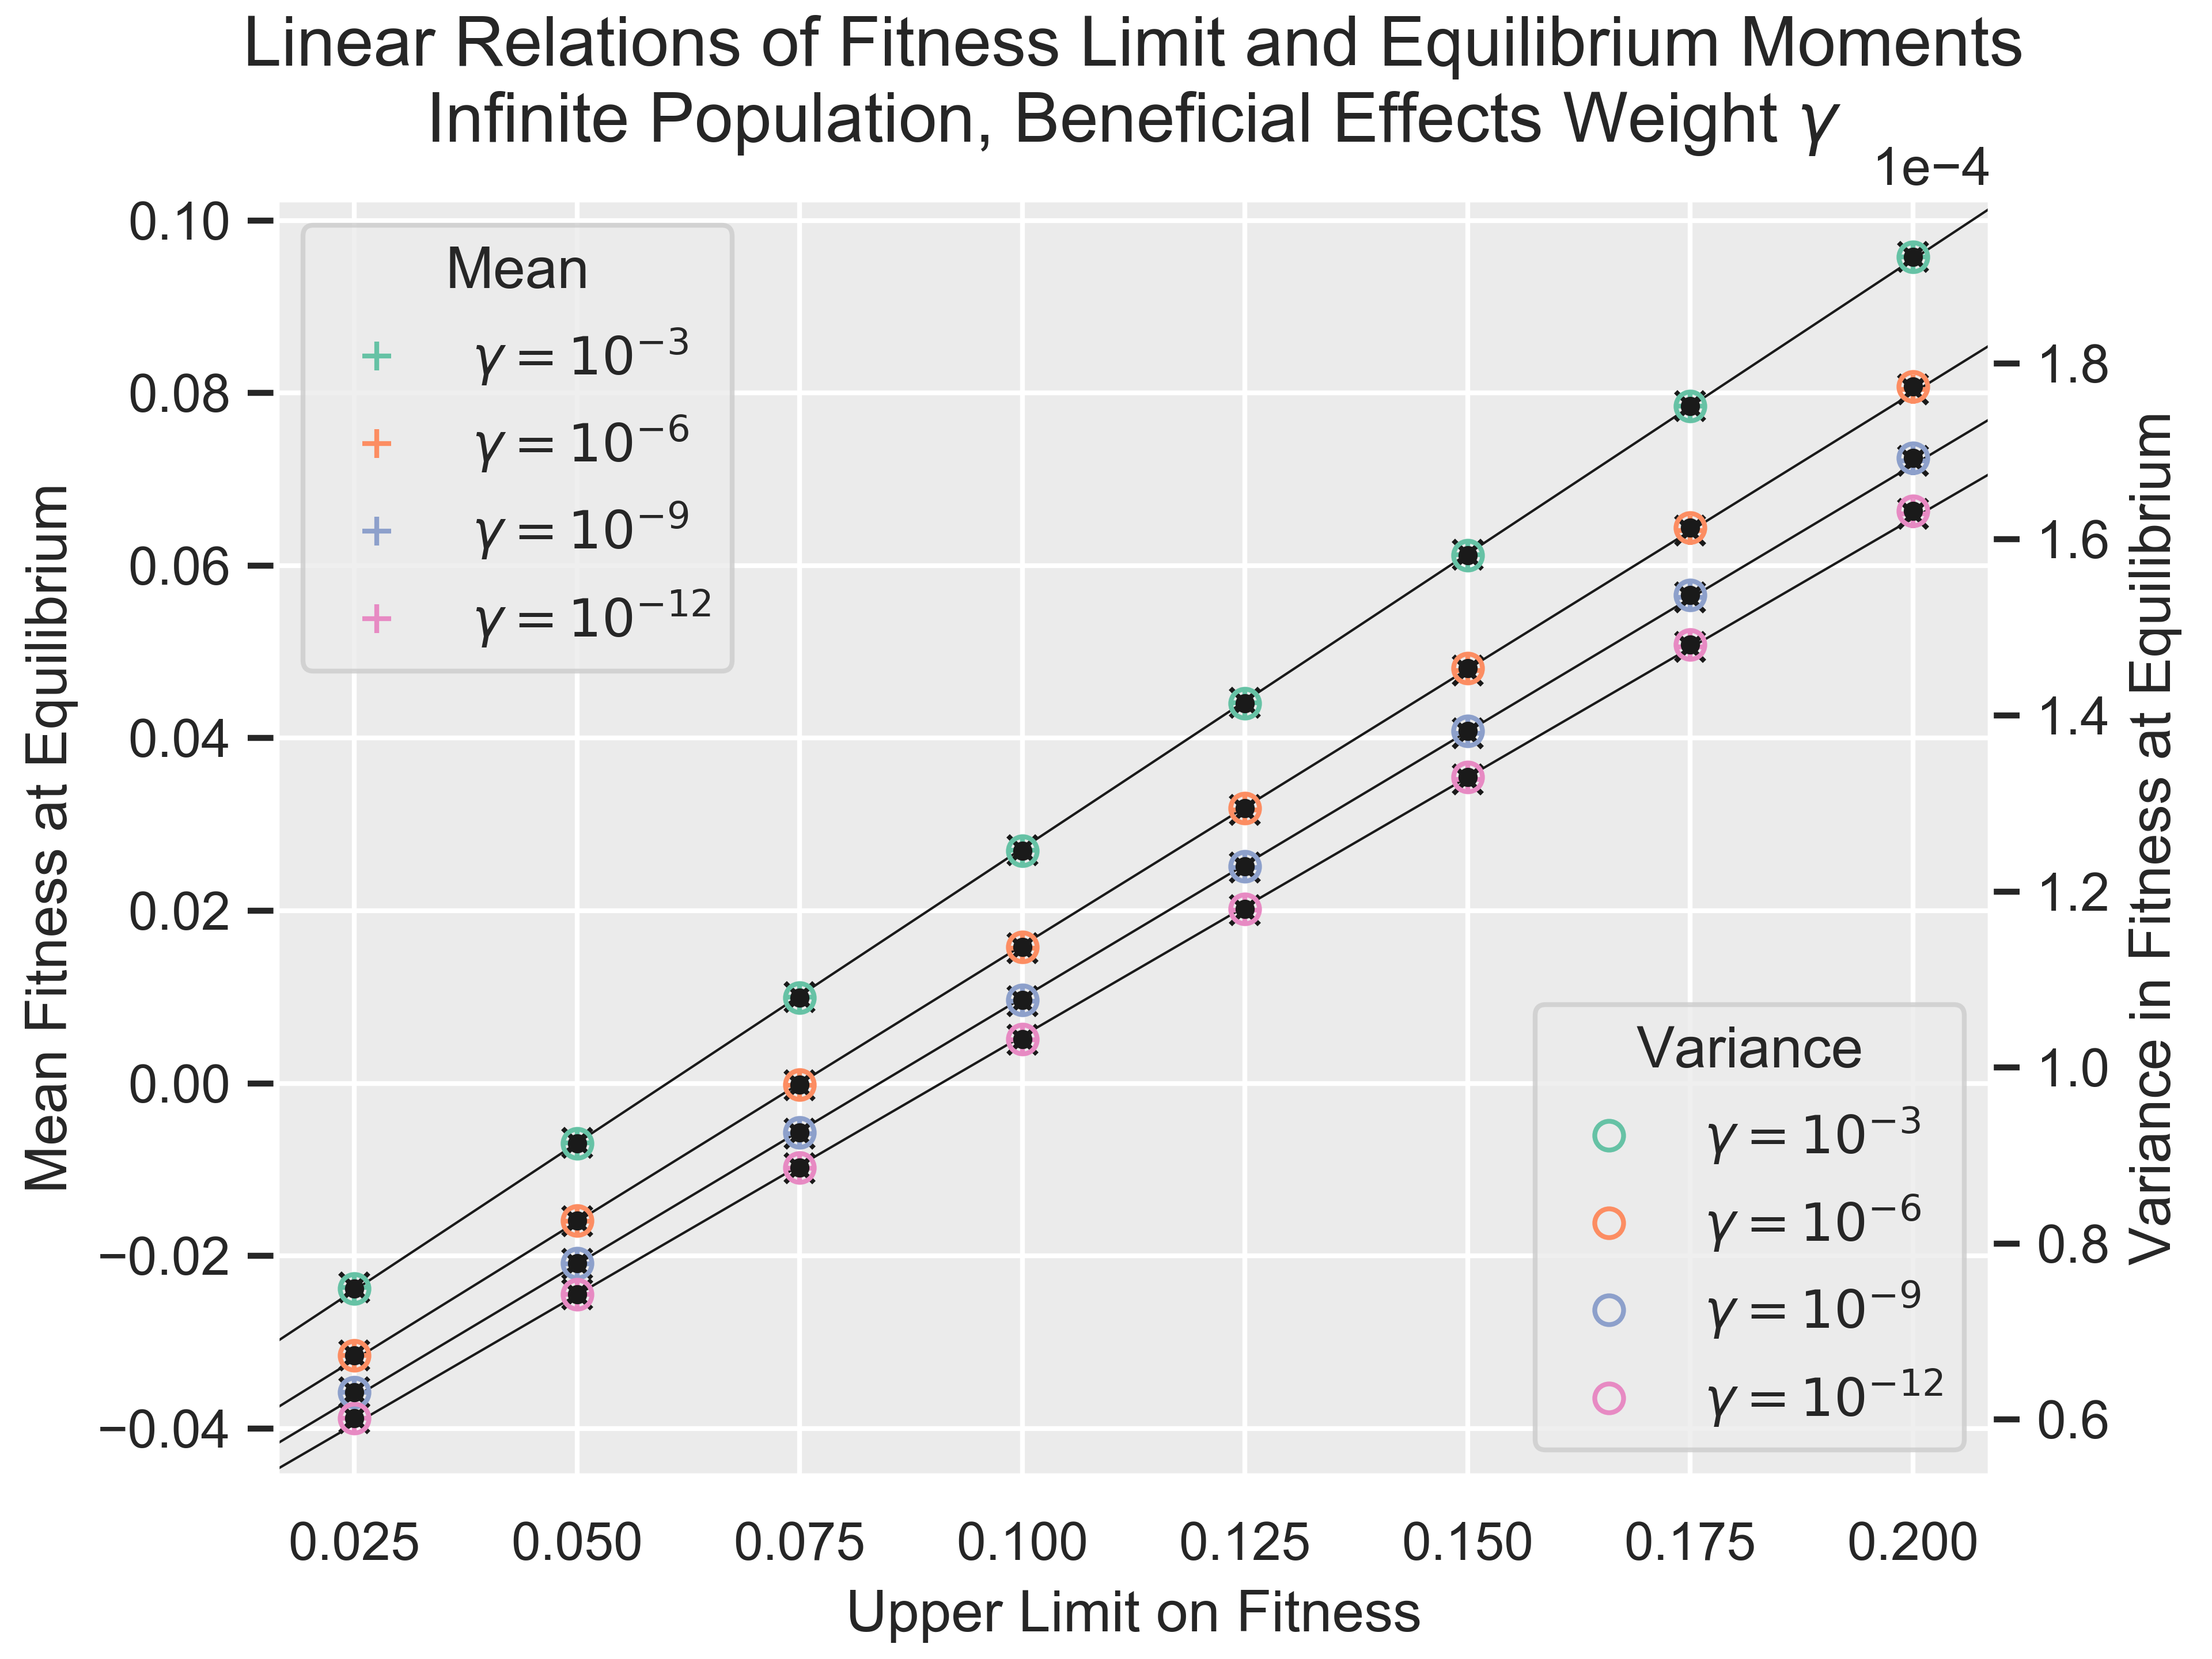

In [84]:
eq.plot_stats()
eq.save_and_display(DIR+'tmp.png')

In the following two plots, dashed black lines should appear atop colored lines.

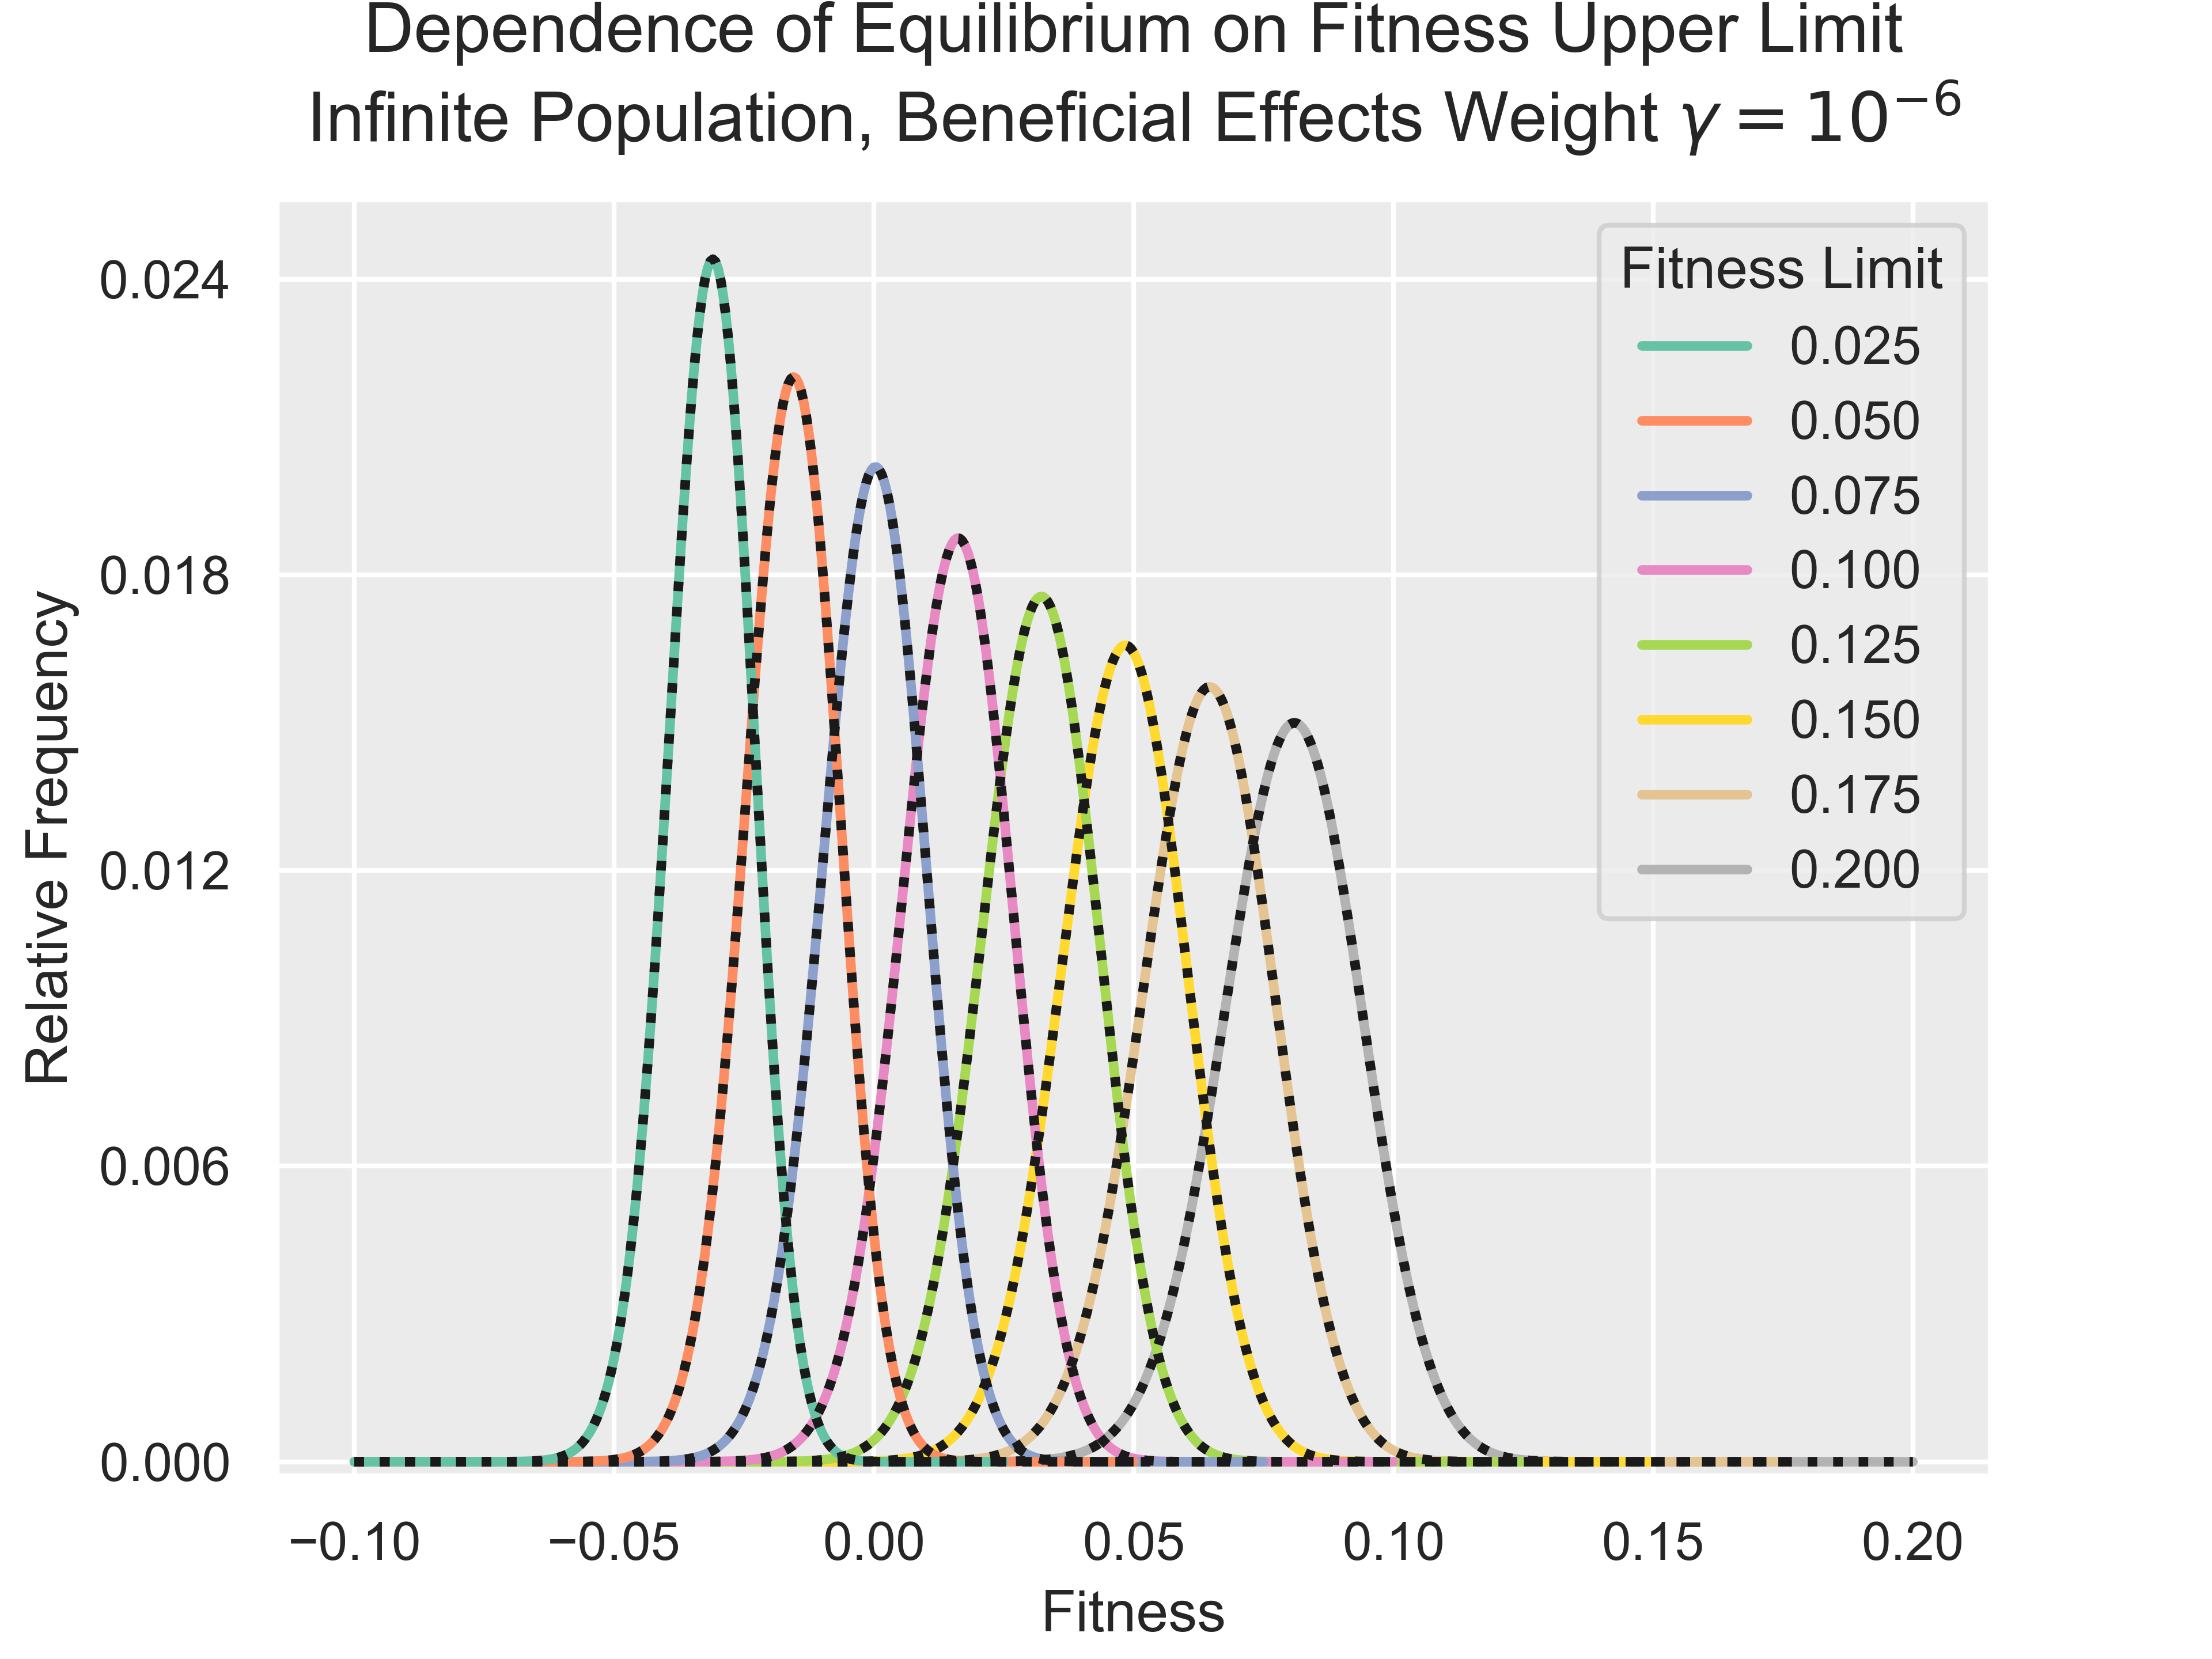

In [85]:
eq.plot_row(1)
eq.save_and_display(DIR+'tmp.png')

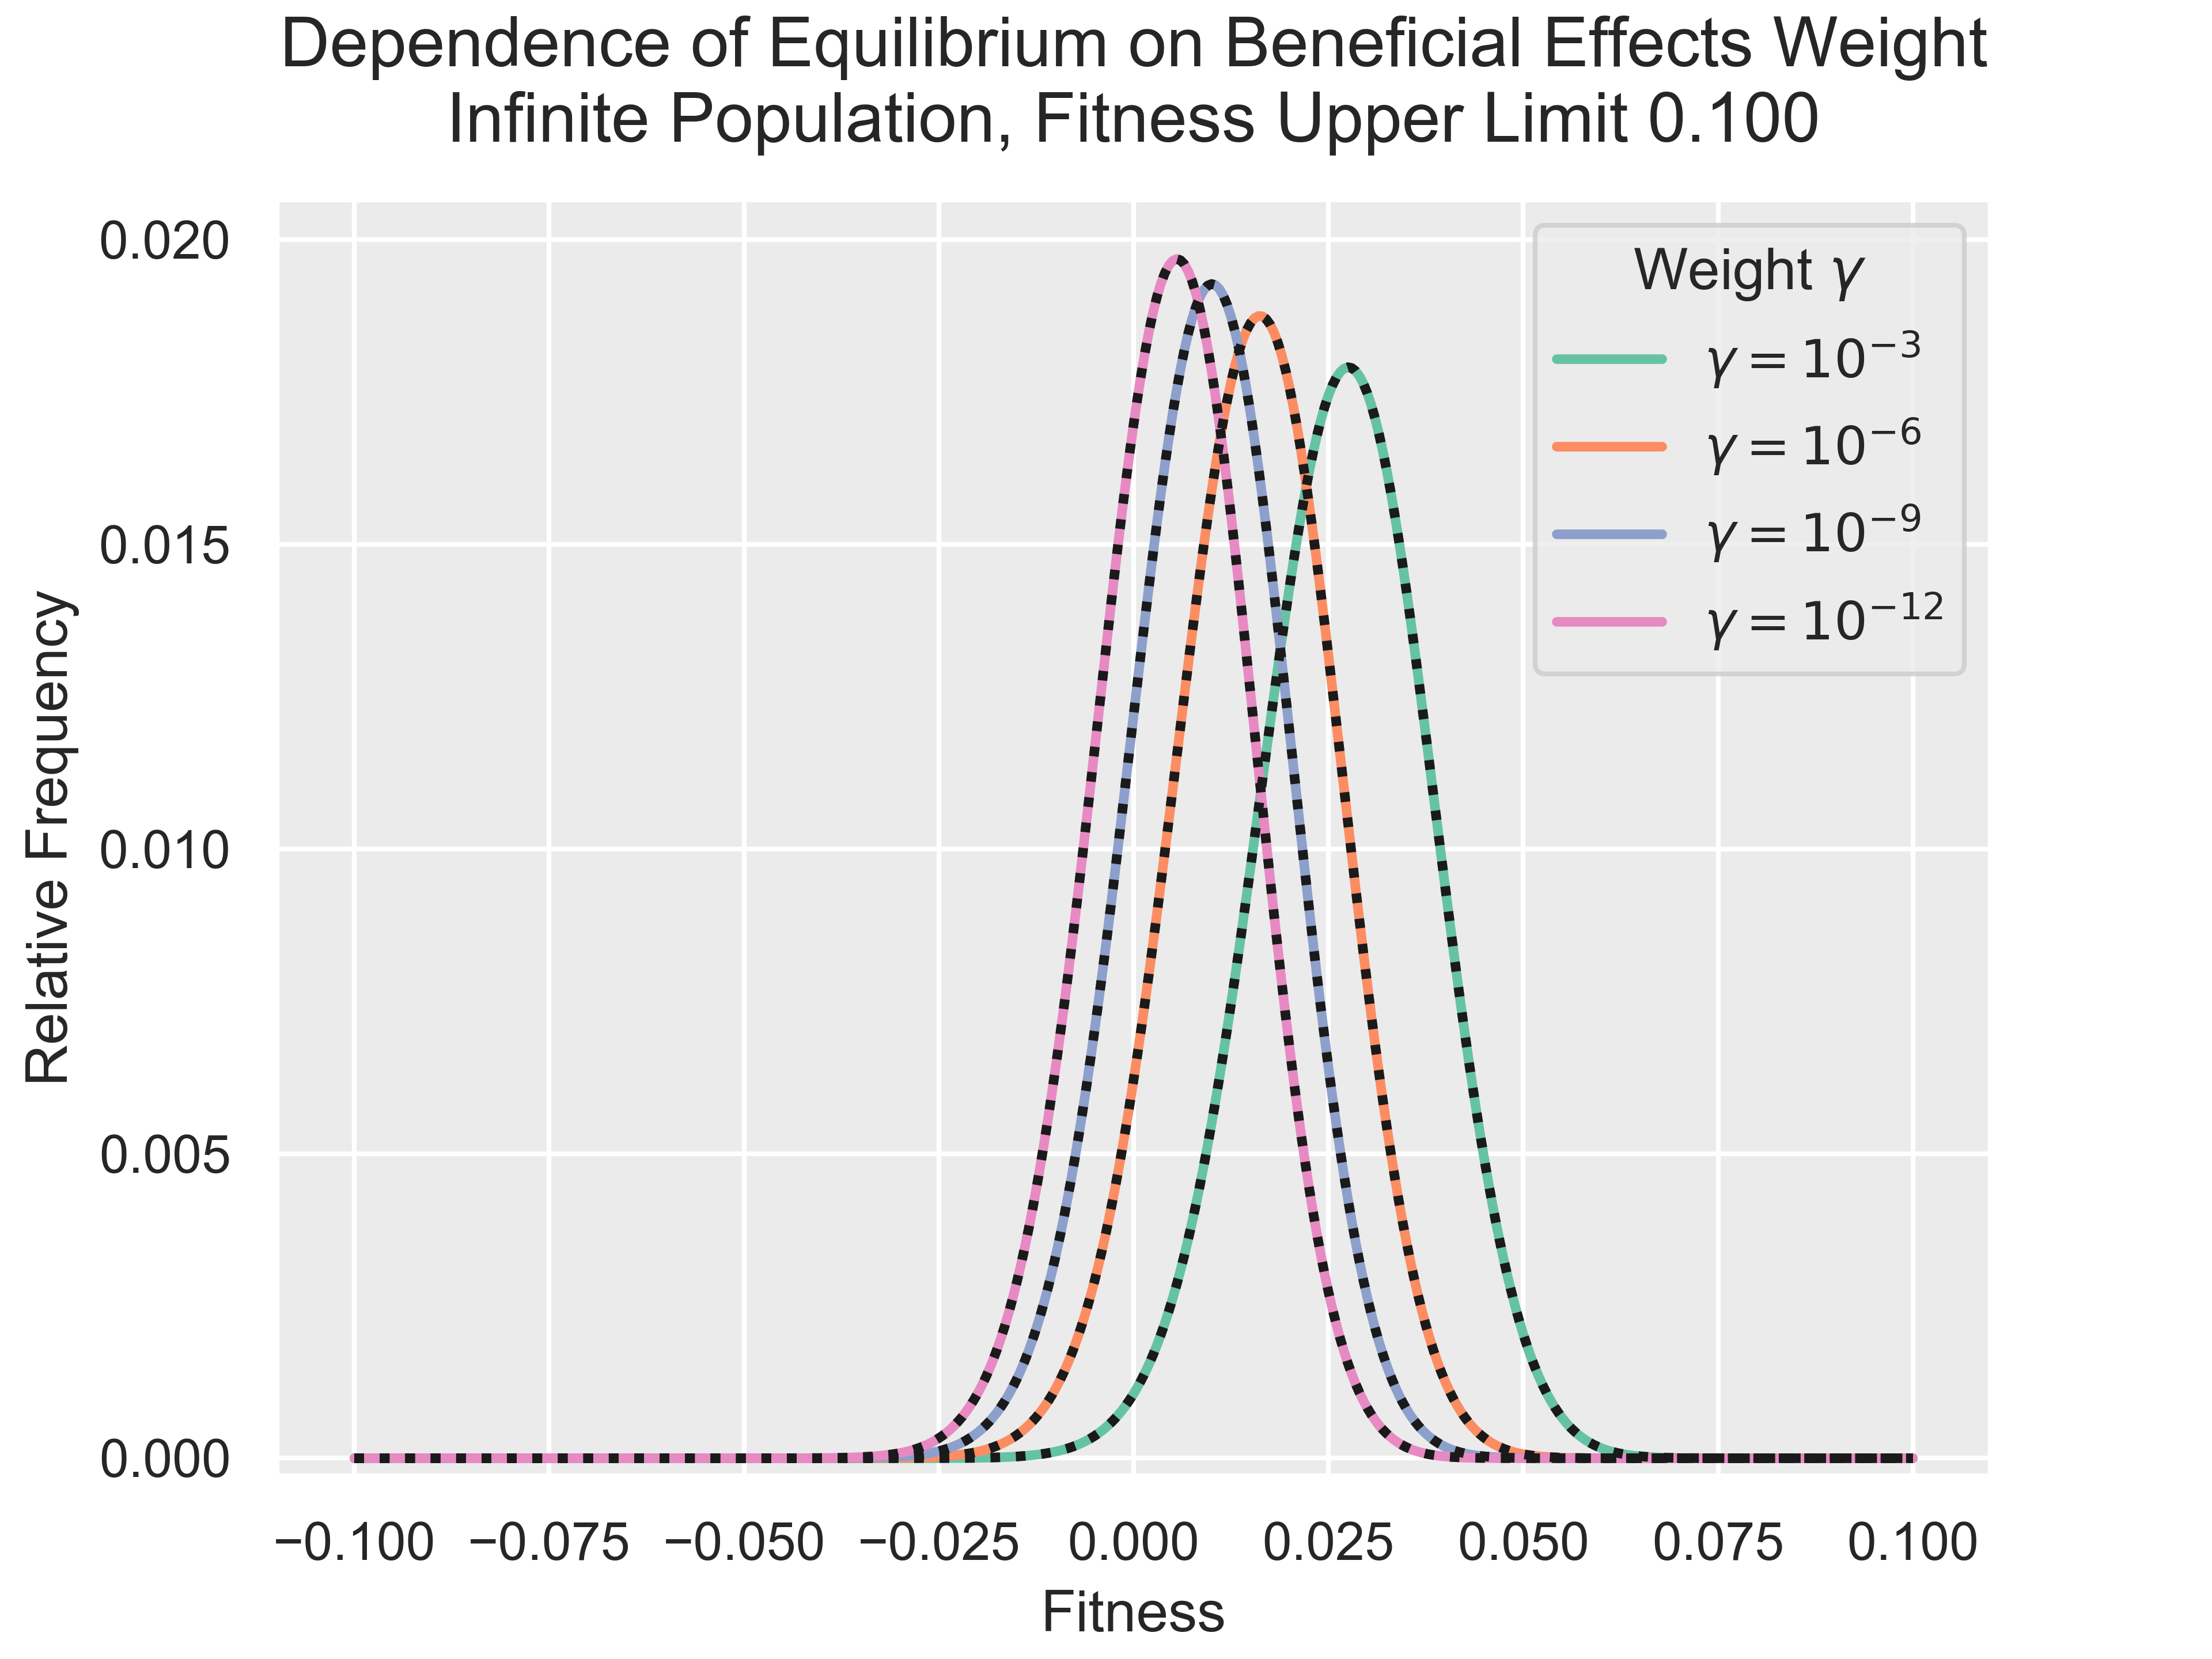

In [86]:
eq.plot_column(3)
eq.save_and_display(DIR+'tmp.png')

**Verify that all equilibrium approximation errors are small.**

That is, verify that $\text{mare}(\tilde{\alpha} \tilde{\mathbf{v}}, W\!\tilde{\mathbf{v}})$ is small for all eigenpairs $(\tilde{\alpha}, \tilde{\mathbf{v}})$ calculated by the function `equilibrium`.

In [87]:
print('Eigenpair approximation errors per equilibrium():\n')
print_array(eq.eigen_error)
print('\nMax approximation error:', np.max(eq.eigen_error))

Eigenpair approximation errors per equilibrium():

 6.36e-16 5.57e-16 6.02e-16 7.15e-16 8.90e-16 1.04e-15 8.86e-16 6.37e-16
 5.91e-16 5.44e-16 6.41e-16 6.72e-16 4.87e-16 6.58e-16 7.73e-16 6.28e-16
 5.97e-16 4.44e-16 6.38e-16 5.46e-16 6.08e-16 6.35e-16 7.50e-16 6.15e-16
 4.43e-16 6.61e-16 5.84e-16 6.09e-16 6.64e-16 6.84e-16 7.25e-16 7.16e-16

Max approximation error: 1.0370261520032004e-15


**Verify that all of the alternative approximation errors are small.**

That is, verify that the maximum absolute difference of $\tilde{\alpha} \mathbf{v}$ and $W\tilde{\mathbf{v}}$ is small for all approximate eigenpairs $(\tilde{\alpha}, \tilde{\mathbf{v}})$ calculated by the function `alt_equilibrium`.

In [88]:
print('Eigenpair approximation errors per alt_equilibrium():\n')
print_array(eq.alt_eigen_error)
print('\nMax approximation error:', np.max(eq.alt_eigen_error))

Eigenpair approximation errors per alt_equilibrium():

 4.55e-18 5.20e-18 1.52e-18 2.17e-18 1.30e-18 6.07e-18 1.73e-18 2.17e-18
 3.25e-18 6.29e-18 6.29e-18 7.37e-18 3.90e-18 6.07e-18 3.69e-18 4.12e-18
 8.89e-18 6.51e-18 6.29e-18 7.81e-18 9.11e-18 7.37e-18 8.67e-18 6.29e-18
 1.46e-16 3.58e-17 6.29e-18 8.24e-18 6.07e-18 9.54e-18 7.37e-18 7.81e-18

Max approximation error: 1.4582519219930035e-16


The default value of the `max_error` parameter of `alt_equilibrium` is `1e-16`, and the case in which the (very small) error is `1.46e-16` (lower left corner of the array of values) accounts for the one "Maximum number of iterations exceeded" warning above.

**Verify that calculated and recalculated eigenvalues are close.**

In [89]:
print('Absolute differences in eigenvalues:\n')
print_array(np.abs(eq.alt_e_value - eq.e_value))
print('\nMax absolute difference:', mad(eq.alt_e_value, eq.e_value))

Absolute differences in eigenvalues:

 2.64e-16 1.80e-16 0.00e+00 1.39e-16 2.78e-17 4.16e-16 5.55e-17 0.00e+00
 4.72e-16 9.85e-16 4.30e-16 4.44e-16 5.00e-16 1.50e-15 2.78e-17 0.00e+00
 3.28e-15 2.86e-15 1.80e-15 2.23e-15 4.54e-15 1.78e-15 1.61e-15 8.60e-16
 9.07e-14 1.69e-15 3.28e-15 2.96e-15 3.62e-15 3.36e-15 3.28e-15 3.89e-15

Max absolute difference: 9.067746553625966e-14


The maximum absolute difference of eigenvalues is in the lower left corner of the array. That is, it is the case in which the approximation error of `alt_equilibrium` is greatest. The following cell shows that the most-different eigenvalues are very similar.

In [90]:
def most_different_e_values(eq):
    index = np.argmax(np.abs(eq.alt_e_value - eq.e_value))
    indices = np.unravel_index(index, eq.e_value.shape)
    print('From (row, column) :', indices)
    print('Per equilibrium    :', eq.e_value[indices])
    print('Per alt_equilibrium:', eq.alt_e_value[indices])

most_different_e_values(eq)

From (row, column) : (3, 0)
Per equilibrium    : 0.06116123067373641
Per alt_equilibrium: 0.06116123067364573


**Verify that the mean fitness at equilibrium is the eigenvalue.**

For each pair $(\alpha, \mathbf{v})$ of eigenvalue and equilibrium (eigenvector), 

\begin{equation*}
   \sum_{i=1}^n v_i m_i = \alpha.
\end{equation*}

For the eigenpairs calculated by `equilibrium`, the equality holds almost exactly:

In [91]:
print('Absolute differences of eigenvalues and mean fitnesses:\n')
print_array(np.abs(eq.mean - eq.e_value).astype(float))
print('\nMax absolute difference:', mad(eq.mean, eq.e_value))

Absolute differences of eigenvalues and mean fitnesses:

 1.39e-17 1.39e-17 0.00e+00 2.78e-17 0.00e+00 0.00e+00 2.78e-17 0.00e+00
 0.00e+00 0.00e+00 1.39e-17 0.00e+00 0.00e+00 2.78e-17 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 1.39e-17 0.00e+00 1.39e-17 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.39e-17 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.78e-17 0.00e+00

Max absolute difference: 2.7755575615628914e-17


**Verify that eigenvalues are the largest real eigenvalues.**

For each of the 36 cases of $W\!,$ we verify that the eigenvalue of $W$ calculated by the `equilibrium` function is closer to the largest real eigenvalue of $W\!,$ calculated by the `eigs` function of SciPy's lineary algebra package, than to any other of the eigenvalues of $W.$

In [92]:
def verify_largest_eig(W, e_value):
    # Verify that `e_value` is closer, by measure of Euclidean distance
    # in the complex plane, to the largest real (no imaginary part)
    # eigenvalue of `W` than to any other of the eigenvalues.
    def distance(e_val):
        return (e_val.real - e_value)**2 + e_val.imag**2
    #
    W = W.astype(float)
    e_values, e_vectors = linalg.eig(W)
    real_e_values = e_values[e_values.imag == 0.0]
    largest = np.argmax(real_e_values)
    min_dist = distance(real_e_values[largest])
    for e_val in e_values:
        if distance(e_val) < min_dist:
            s = '{} is closer to e_value {} than is {}'
            print(s.format(e_val, e_value, real_e_values[largest]))
            raise Exception()

def check_eigenvalues(eq):
    found_error = False
    for i in range(eq.params.shape[0]):
        for j in range(eq.params.shape[1]):
            try:
                verify_largest_eig(eq.params[i,j].W, eq.e_value[i,j])
            except Exception as e:
                print('in row {}, col {}'.format(i, j))
                found_error = True
    if not found_error:
        print('Largest real eigenvalue in all cases')
        
check_eigenvalues(eq)

Largest real eigenvalue in all cases


In [93]:
"""
Indicate when this code cell was last executed.
"""
print("Time stamp:", datetime.now())

Time stamp: 2020-06-24 00:07:07.270193
